In [1]:
import os
import os.path
import glob
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score

import matplotlib.pyplot as plt
import matplotlib.cm as colormap
plt.rcParams['image.cmap'] = 'Pastel1'

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D

Using TensorFlow backend.


In [2]:
imagedir = "retina-dataset"

In [18]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
#X = np.zeros((num_samples, width, height, channels))
cnt = 0
#list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        #list_paths.append(os.path.join(os.getcwd(),img_file))
        #img = image.load_img(img_file, target_size=(224, 224))
        #x = image.img_to_array(img)
        #x = np.expand_dims(x, axis=0)
        #x = preprocess_input(x)
        #X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         Exudate	Number of images: 67600
Label: 1	Family:     Non_Exudate	Number of images: 70043
Processing images ...
Images processed: 137643


In [4]:
#X.shape

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
filename = 'retina-resnet50features-avgpool.npy'
if os.path.exists(filename):
    print("Loading ResNet50 extracted features from %s ..." %(filename))
    resnet50features = np.load(filename)
else:
    print("Extracting features from ResNet50 layers ...")
    resnet50features = base_model.predict(X)
    print("Saving ResNet50 extracted features into %s ..." %(filename))
    np.save(filename, resnet50features)

Loading ResNet50 extracted features from retina-resnet50features-avgpool.npy ...


In [8]:
resnet50features.shape

(137643, 2048)

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
#for index in skf.split(X, y):    
for index in skf.split(resnet50features, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Training top_model and saving min training loss weights
num_epochs=20000
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
early_stopping = EarlyStopping(verbose=1, patience=20, monitor='val_loss')
checkpointer = ModelCheckpoint(filepath='retina-topweights-max_val_acc-resnet50-Adam-20000epochs_earlystop.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='max')
callbacks_list = [early_stopping, checkpointer]
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = resnet50features[train_indices]
    Y_train = Y[train_indices]
    X_test = resnet50features[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    top_input = Input(shape=resnet50features.shape[1:])
    predict = Dense(num_classes, activation='softmax', name='predictions')(top_input)
    top_model = Model(input=top_input, output=predict)                            
    top_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    start = time.time()
    h = top_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=X_train.shape[0], verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = top_model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`


Train on 110114 samples, validate on 27529 samples
Epoch 1/20000
110114/110114 [==============================] - 1s - loss: 0.7910 - acc: 0.4853 - val_loss: 0.7069 - val_acc: 0.4920
Epoch 2/20000
110114/110114 [==============================] - 1s - loss: 0.7071 - acc: 0.4933 - val_loss: 0.6512 - val_acc: 0.6512
Epoch 3/20000
110114/110114 [==============================] - 1s - loss: 0.6518 - acc: 0.6491 - val_loss: 0.6396 - val_acc: 0.6444
Epoch 4/20000
110114/110114 [==============================] - 1s - loss: 0.6407 - acc: 0.6419 - val_loss: 0.6351 - val_acc: 0.6213
Epoch 5/20000
110114/110114 [==============================] - 1s - loss: 0.6367 - acc: 0.6174 - val_loss: 0.6201 - val_acc: 0.6388
Epoch 6/20000
110114/110114 [==============================] - 1s - loss: 0.6220 - acc: 0.6340 - val_loss: 0.5941 - val_acc: 0.6798
Epoch 7/20000
110114/110114 [==============================] - 1s - loss: 0.5960 - acc: 0.6788 - val_loss: 0.5652 - val_acc: 0.7279
Epoch 8/20000
110114/1101

110114/110114 [==============================] - 1s - loss: 0.3241 - acc: 0.8635 - val_loss: 0.3226 - val_acc: 0.8638
Epoch 124/20000
110114/110114 [==============================] - 1s - loss: 0.3234 - acc: 0.8640 - val_loss: 0.3219 - val_acc: 0.8642
Epoch 125/20000
110114/110114 [==============================] - 1s - loss: 0.3227 - acc: 0.8645 - val_loss: 0.3213 - val_acc: 0.8646
Epoch 126/20000
110114/110114 [==============================] - 1s - loss: 0.3220 - acc: 0.8649 - val_loss: 0.3206 - val_acc: 0.8649
Epoch 127/20000
110114/110114 [==============================] - 1s - loss: 0.3213 - acc: 0.8652 - val_loss: 0.3199 - val_acc: 0.8652
Epoch 128/20000
110114/110114 [==============================] - 1s - loss: 0.3206 - acc: 0.8655 - val_loss: 0.3192 - val_acc: 0.8656
Epoch 129/20000
110114/110114 [==============================] - 1s - loss: 0.3200 - acc: 0.8659 - val_loss: 0.3185 - val_acc: 0.8661
Epoch 130/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2662 - acc: 0.8943 - val_loss: 0.2657 - val_acc: 0.8942
Epoch 246/20000
110114/110114 [==============================] - 1s - loss: 0.2659 - acc: 0.8947 - val_loss: 0.2654 - val_acc: 0.8943
Epoch 247/20000
110114/110114 [==============================] - 1s - loss: 0.2656 - acc: 0.8948 - val_loss: 0.2651 - val_acc: 0.8945
Epoch 248/20000
110114/110114 [==============================] - 1s - loss: 0.2653 - acc: 0.8949 - val_loss: 0.2648 - val_acc: 0.8947
Epoch 249/20000
110114/110114 [==============================] - 1s - loss: 0.2650 - acc: 0.8951 - val_loss: 0.2645 - val_acc: 0.8949
Epoch 250/20000
110114/110114 [==============================] - 1s - loss: 0.2647 - acc: 0.8951 - val_loss: 0.2641 - val_acc: 0.8949
Epoch 251/20000
110114/110114 [==============================] - 1s - loss: 0.2643 - acc: 0.8952 - val_loss: 0.2638 - val_acc: 0.8951
Epoch 252/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2362 - acc: 0.9074 - val_loss: 0.2360 - val_acc: 0.9059
Epoch 368/20000
110114/110114 [==============================] - 1s - loss: 0.2360 - acc: 0.9074 - val_loss: 0.2358 - val_acc: 0.9060
Epoch 369/20000
110114/110114 [==============================] - 1s - loss: 0.2358 - acc: 0.9075 - val_loss: 0.2356 - val_acc: 0.9062
Epoch 370/20000
110114/110114 [==============================] - 1s - loss: 0.2356 - acc: 0.9076 - val_loss: 0.2354 - val_acc: 0.9063
Epoch 371/20000
110114/110114 [==============================] - 1s - loss: 0.2354 - acc: 0.9076 - val_loss: 0.2352 - val_acc: 0.9064
Epoch 372/20000
110114/110114 [==============================] - 1s - loss: 0.2352 - acc: 0.9077 - val_loss: 0.2350 - val_acc: 0.9064
Epoch 373/20000
110114/110114 [==============================] - 1s - loss: 0.2350 - acc: 0.9077 - val_loss: 0.2348 - val_acc: 0.9065
Epoch 374/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2169 - acc: 0.9150 - val_loss: 0.2169 - val_acc: 0.9143
Epoch 490/20000
110114/110114 [==============================] - 1s - loss: 0.2168 - acc: 0.9150 - val_loss: 0.2167 - val_acc: 0.9144
Epoch 491/20000
110114/110114 [==============================] - 1s - loss: 0.2167 - acc: 0.9151 - val_loss: 0.2166 - val_acc: 0.9145
Epoch 492/20000
110114/110114 [==============================] - 1s - loss: 0.2166 - acc: 0.9151 - val_loss: 0.2165 - val_acc: 0.9145
Epoch 493/20000
110114/110114 [==============================] - 1s - loss: 0.2164 - acc: 0.9151 - val_loss: 0.2163 - val_acc: 0.9146
Epoch 494/20000
110114/110114 [==============================] - 1s - loss: 0.2163 - acc: 0.9152 - val_loss: 0.2162 - val_acc: 0.9145
Epoch 495/20000
110114/110114 [==============================] - 1s - loss: 0.2162 - acc: 0.9152 - val_loss: 0.2161 - val_acc: 0.9146
Epoch 496/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2032 - acc: 0.9201 - val_loss: 0.2033 - val_acc: 0.9202
Epoch 612/20000
110114/110114 [==============================] - 1s - loss: 0.2032 - acc: 0.9201 - val_loss: 0.2032 - val_acc: 0.9202
Epoch 613/20000
110114/110114 [==============================] - 1s - loss: 0.2031 - acc: 0.9202 - val_loss: 0.2031 - val_acc: 0.9203
Epoch 614/20000
110114/110114 [==============================] - 1s - loss: 0.2030 - acc: 0.9203 - val_loss: 0.2030 - val_acc: 0.9202
Epoch 615/20000
110114/110114 [==============================] - 1s - loss: 0.2029 - acc: 0.9203 - val_loss: 0.2029 - val_acc: 0.9203
Epoch 616/20000
110114/110114 [==============================] - 1s - loss: 0.2028 - acc: 0.9204 - val_loss: 0.2028 - val_acc: 0.9203
Epoch 617/20000
110114/110114 [==============================] - 1s - loss: 0.2027 - acc: 0.9205 - val_loss: 0.2027 - val_acc: 0.9204
Epoch 618/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1928 - acc: 0.9241 - val_loss: 0.1930 - val_acc: 0.9249
Epoch 734/20000
110114/110114 [==============================] - 1s - loss: 0.1928 - acc: 0.9242 - val_loss: 0.1929 - val_acc: 0.9250
Epoch 735/20000
110114/110114 [==============================] - 1s - loss: 0.1927 - acc: 0.9242 - val_loss: 0.1928 - val_acc: 0.9250
Epoch 736/20000
110114/110114 [==============================] - 1s - loss: 0.1926 - acc: 0.9242 - val_loss: 0.1927 - val_acc: 0.9250
Epoch 737/20000
110114/110114 [==============================] - 1s - loss: 0.1925 - acc: 0.9242 - val_loss: 0.1927 - val_acc: 0.9250
Epoch 738/20000
110114/110114 [==============================] - 1s - loss: 0.1925 - acc: 0.9242 - val_loss: 0.1926 - val_acc: 0.9250
Epoch 739/20000
110114/110114 [==============================] - 1s - loss: 0.1924 - acc: 0.9243 - val_loss: 0.1925 - val_acc: 0.9250
Epoch 740/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1846 - acc: 0.9276 - val_loss: 0.1848 - val_acc: 0.9277
Epoch 856/20000
110114/110114 [==============================] - 1s - loss: 0.1845 - acc: 0.9277 - val_loss: 0.1848 - val_acc: 0.9277
Epoch 857/20000
110114/110114 [==============================] - 1s - loss: 0.1844 - acc: 0.9277 - val_loss: 0.1847 - val_acc: 0.9277
Epoch 858/20000
110114/110114 [==============================] - 1s - loss: 0.1844 - acc: 0.9277 - val_loss: 0.1847 - val_acc: 0.9277
Epoch 859/20000
110114/110114 [==============================] - 1s - loss: 0.1843 - acc: 0.9277 - val_loss: 0.1846 - val_acc: 0.9277
Epoch 860/20000
110114/110114 [==============================] - 1s - loss: 0.1843 - acc: 0.9277 - val_loss: 0.1845 - val_acc: 0.9277
Epoch 861/20000
110114/110114 [==============================] - 1s - loss: 0.1842 - acc: 0.9277 - val_loss: 0.1845 - val_acc: 0.9278
Epoch 862/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1778 - acc: 0.9301 - val_loss: 0.1782 - val_acc: 0.9307
Epoch 978/20000
110114/110114 [==============================] - 1s - loss: 0.1777 - acc: 0.9301 - val_loss: 0.1781 - val_acc: 0.9307
Epoch 979/20000
110114/110114 [==============================] - 1s - loss: 0.1777 - acc: 0.9301 - val_loss: 0.1781 - val_acc: 0.9307
Epoch 980/20000
110114/110114 [==============================] - 1s - loss: 0.1776 - acc: 0.9301 - val_loss: 0.1780 - val_acc: 0.9307
Epoch 981/20000
110114/110114 [==============================] - 1s - loss: 0.1776 - acc: 0.9301 - val_loss: 0.1780 - val_acc: 0.9307
Epoch 982/20000
110114/110114 [==============================] - 1s - loss: 0.1775 - acc: 0.9302 - val_loss: 0.1780 - val_acc: 0.9307
Epoch 983/20000
110114/110114 [==============================] - 1s - loss: 0.1775 - acc: 0.9302 - val_loss: 0.1779 - val_acc: 0.9307
Epoch 984/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1721 - acc: 0.9325 - val_loss: 0.1727 - val_acc: 0.9328
Epoch 1098/20000
110114/110114 [==============================] - 1s - loss: 0.1721 - acc: 0.9325 - val_loss: 0.1727 - val_acc: 0.9328
Epoch 1099/20000
110114/110114 [==============================] - 1s - loss: 0.1720 - acc: 0.9325 - val_loss: 0.1727 - val_acc: 0.9329
Epoch 1100/20000
110114/110114 [==============================] - 1s - loss: 0.1720 - acc: 0.9325 - val_loss: 0.1726 - val_acc: 0.9329
Epoch 1101/20000
110114/110114 [==============================] - 1s - loss: 0.1719 - acc: 0.9325 - val_loss: 0.1726 - val_acc: 0.9330
Epoch 1102/20000
110114/110114 [==============================] - 1s - loss: 0.1719 - acc: 0.9326 - val_loss: 0.1725 - val_acc: 0.9330
Epoch 1103/20000
110114/110114 [==============================] - 1s - loss: 0.1719 - acc: 0.9326 - val_loss: 0.1725 - val_acc: 0.9330
Epoch 1104/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1673 - acc: 0.9346 - val_loss: 0.1681 - val_acc: 0.9347
Epoch 1218/20000
110114/110114 [==============================] - 1s - loss: 0.1672 - acc: 0.9346 - val_loss: 0.1680 - val_acc: 0.9347
Epoch 1219/20000
110114/110114 [==============================] - 1s - loss: 0.1672 - acc: 0.9346 - val_loss: 0.1680 - val_acc: 0.9347
Epoch 1220/20000
110114/110114 [==============================] - 1s - loss: 0.1671 - acc: 0.9346 - val_loss: 0.1680 - val_acc: 0.9347
Epoch 1221/20000
110114/110114 [==============================] - 1s - loss: 0.1671 - acc: 0.9346 - val_loss: 0.1679 - val_acc: 0.9347
Epoch 1222/20000
110114/110114 [==============================] - 1s - loss: 0.1671 - acc: 0.9346 - val_loss: 0.1679 - val_acc: 0.9347
Epoch 1223/20000
110114/110114 [==============================] - 1s - loss: 0.1670 - acc: 0.9346 - val_loss: 0.1679 - val_acc: 0.9347
Epoch 1224/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1630 - acc: 0.9361 - val_loss: 0.1641 - val_acc: 0.9362
Epoch 1338/20000
110114/110114 [==============================] - 1s - loss: 0.1630 - acc: 0.9361 - val_loss: 0.1640 - val_acc: 0.9362
Epoch 1339/20000
110114/110114 [==============================] - 1s - loss: 0.1630 - acc: 0.9361 - val_loss: 0.1640 - val_acc: 0.9362
Epoch 1340/20000
110114/110114 [==============================] - 1s - loss: 0.1629 - acc: 0.9361 - val_loss: 0.1640 - val_acc: 0.9362
Epoch 1341/20000
110114/110114 [==============================] - 1s - loss: 0.1629 - acc: 0.9361 - val_loss: 0.1639 - val_acc: 0.9363
Epoch 1342/20000
110114/110114 [==============================] - 1s - loss: 0.1629 - acc: 0.9361 - val_loss: 0.1639 - val_acc: 0.9363
Epoch 1343/20000
110114/110114 [==============================] - 1s - loss: 0.1628 - acc: 0.9362 - val_loss: 0.1639 - val_acc: 0.9363
Epoch 1344/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1593 - acc: 0.9377 - val_loss: 0.1605 - val_acc: 0.9373
Epoch 1458/20000
110114/110114 [==============================] - 1s - loss: 0.1592 - acc: 0.9377 - val_loss: 0.1605 - val_acc: 0.9373
Epoch 1459/20000
110114/110114 [==============================] - 1s - loss: 0.1592 - acc: 0.9377 - val_loss: 0.1605 - val_acc: 0.9373
Epoch 1460/20000
110114/110114 [==============================] - 1s - loss: 0.1592 - acc: 0.9377 - val_loss: 0.1604 - val_acc: 0.9373
Epoch 1461/20000
110114/110114 [==============================] - 1s - loss: 0.1591 - acc: 0.9377 - val_loss: 0.1604 - val_acc: 0.9373
Epoch 1462/20000
110114/110114 [==============================] - 1s - loss: 0.1591 - acc: 0.9377 - val_loss: 0.1604 - val_acc: 0.9373
Epoch 1463/20000
110114/110114 [==============================] - 1s - loss: 0.1591 - acc: 0.9377 - val_loss: 0.1604 - val_acc: 0.9373
Epoch 1464/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1559 - acc: 0.9390 - val_loss: 0.1574 - val_acc: 0.9386
Epoch 1578/20000
110114/110114 [==============================] - 1s - loss: 0.1559 - acc: 0.9390 - val_loss: 0.1574 - val_acc: 0.9386
Epoch 1579/20000
110114/110114 [==============================] - 1s - loss: 0.1559 - acc: 0.9390 - val_loss: 0.1574 - val_acc: 0.9386
Epoch 1580/20000
110114/110114 [==============================] - 1s - loss: 0.1558 - acc: 0.9390 - val_loss: 0.1573 - val_acc: 0.9386
Epoch 1581/20000
110114/110114 [==============================] - 1s - loss: 0.1558 - acc: 0.9390 - val_loss: 0.1573 - val_acc: 0.9386
Epoch 1582/20000
110114/110114 [==============================] - 1s - loss: 0.1558 - acc: 0.9390 - val_loss: 0.1573 - val_acc: 0.9386
Epoch 1583/20000
110114/110114 [==============================] - 1s - loss: 0.1558 - acc: 0.9391 - val_loss: 0.1573 - val_acc: 0.9386
Epoch 1584/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1529 - acc: 0.9405 - val_loss: 0.1546 - val_acc: 0.9401
Epoch 1698/20000
110114/110114 [==============================] - 1s - loss: 0.1529 - acc: 0.9405 - val_loss: 0.1546 - val_acc: 0.9401
Epoch 1699/20000
110114/110114 [==============================] - 1s - loss: 0.1529 - acc: 0.9405 - val_loss: 0.1546 - val_acc: 0.9402
Epoch 1700/20000
110114/110114 [==============================] - 1s - loss: 0.1528 - acc: 0.9405 - val_loss: 0.1546 - val_acc: 0.9402
Epoch 1701/20000
110114/110114 [==============================] - 1s - loss: 0.1528 - acc: 0.9406 - val_loss: 0.1545 - val_acc: 0.9402
Epoch 1702/20000
110114/110114 [==============================] - 1s - loss: 0.1528 - acc: 0.9406 - val_loss: 0.1545 - val_acc: 0.9402
Epoch 1703/20000
110114/110114 [==============================] - 1s - loss: 0.1528 - acc: 0.9406 - val_loss: 0.1545 - val_acc: 0.9402
Epoch 1704/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1502 - acc: 0.9416 - val_loss: 0.1521 - val_acc: 0.9411
Epoch 1818/20000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9415 - val_loss: 0.1521 - val_acc: 0.9411
Epoch 1819/20000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9416 - val_loss: 0.1521 - val_acc: 0.9411
Epoch 1820/20000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9416 - val_loss: 0.1521 - val_acc: 0.9411
Epoch 1821/20000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9416 - val_loss: 0.1520 - val_acc: 0.9411
Epoch 1822/20000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9416 - val_loss: 0.1520 - val_acc: 0.9411
Epoch 1823/20000
110114/110114 [==============================] - 1s - loss: 0.1500 - acc: 0.9416 - val_loss: 0.1520 - val_acc: 0.9411
Epoch 1824/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1477 - acc: 0.9424 - val_loss: 0.1499 - val_acc: 0.9420
Epoch 1938/20000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9424 - val_loss: 0.1498 - val_acc: 0.9420
Epoch 1939/20000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9424 - val_loss: 0.1498 - val_acc: 0.9420
Epoch 1940/20000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9424 - val_loss: 0.1498 - val_acc: 0.9420
Epoch 1941/20000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9424 - val_loss: 0.1498 - val_acc: 0.9420
Epoch 1942/20000
110114/110114 [==============================] - 1s - loss: 0.1476 - acc: 0.9424 - val_loss: 0.1498 - val_acc: 0.9420
Epoch 1943/20000
110114/110114 [==============================] - 1s - loss: 0.1475 - acc: 0.9424 - val_loss: 0.1497 - val_acc: 0.9420
Epoch 1944/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1454 - acc: 0.9432 - val_loss: 0.1478 - val_acc: 0.9428
Epoch 2058/20000
110114/110114 [==============================] - 1s - loss: 0.1453 - acc: 0.9432 - val_loss: 0.1478 - val_acc: 0.9428
Epoch 2059/20000
110114/110114 [==============================] - 1s - loss: 0.1453 - acc: 0.9433 - val_loss: 0.1478 - val_acc: 0.9428
Epoch 2060/20000
110114/110114 [==============================] - 1s - loss: 0.1453 - acc: 0.9433 - val_loss: 0.1478 - val_acc: 0.9428
Epoch 2061/20000
110114/110114 [==============================] - 1s - loss: 0.1453 - acc: 0.9433 - val_loss: 0.1477 - val_acc: 0.9428
Epoch 2062/20000
110114/110114 [==============================] - 1s - loss: 0.1453 - acc: 0.9433 - val_loss: 0.1477 - val_acc: 0.9428
Epoch 2063/20000
110114/110114 [==============================] - 1s - loss: 0.1453 - acc: 0.9433 - val_loss: 0.1477 - val_acc: 0.9428
Epoch 2064/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1432 - acc: 0.9441 - val_loss: 0.1459 - val_acc: 0.9437
Epoch 2178/20000
110114/110114 [==============================] - 1s - loss: 0.1432 - acc: 0.9442 - val_loss: 0.1459 - val_acc: 0.9437
Epoch 2179/20000
110114/110114 [==============================] - 1s - loss: 0.1432 - acc: 0.9441 - val_loss: 0.1459 - val_acc: 0.9437
Epoch 2180/20000
110114/110114 [==============================] - 1s - loss: 0.1432 - acc: 0.9441 - val_loss: 0.1459 - val_acc: 0.9437
Epoch 2181/20000
110114/110114 [==============================] - 1s - loss: 0.1432 - acc: 0.9441 - val_loss: 0.1459 - val_acc: 0.9437
Epoch 2182/20000
110114/110114 [==============================] - 1s - loss: 0.1432 - acc: 0.9441 - val_loss: 0.1458 - val_acc: 0.9437
Epoch 2183/20000
110114/110114 [==============================] - 1s - loss: 0.1431 - acc: 0.9441 - val_loss: 0.1458 - val_acc: 0.9438
Epoch 2184/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1413 - acc: 0.9448 - val_loss: 0.1442 - val_acc: 0.9442
Epoch 2298/20000
110114/110114 [==============================] - 1s - loss: 0.1413 - acc: 0.9449 - val_loss: 0.1442 - val_acc: 0.9442
Epoch 2299/20000
110114/110114 [==============================] - 1s - loss: 0.1412 - acc: 0.9449 - val_loss: 0.1442 - val_acc: 0.9442
Epoch 2300/20000
110114/110114 [==============================] - 1s - loss: 0.1412 - acc: 0.9449 - val_loss: 0.1442 - val_acc: 0.9442
Epoch 2301/20000
110114/110114 [==============================] - 1s - loss: 0.1412 - acc: 0.9449 - val_loss: 0.1441 - val_acc: 0.9442
Epoch 2302/20000
110114/110114 [==============================] - 1s - loss: 0.1412 - acc: 0.9449 - val_loss: 0.1441 - val_acc: 0.9442
Epoch 2303/20000
110114/110114 [==============================] - 1s - loss: 0.1412 - acc: 0.9449 - val_loss: 0.1441 - val_acc: 0.9442
Epoch 2304/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1395 - acc: 0.9456 - val_loss: 0.1426 - val_acc: 0.9446
Epoch 2418/20000
110114/110114 [==============================] - 1s - loss: 0.1394 - acc: 0.9456 - val_loss: 0.1426 - val_acc: 0.9446
Epoch 2419/20000
110114/110114 [==============================] - 1s - loss: 0.1394 - acc: 0.9457 - val_loss: 0.1426 - val_acc: 0.9446
Epoch 2420/20000
110114/110114 [==============================] - 1s - loss: 0.1394 - acc: 0.9457 - val_loss: 0.1426 - val_acc: 0.9446
Epoch 2421/20000
110114/110114 [==============================] - 1s - loss: 0.1394 - acc: 0.9457 - val_loss: 0.1426 - val_acc: 0.9446
Epoch 2422/20000
110114/110114 [==============================] - 1s - loss: 0.1394 - acc: 0.9457 - val_loss: 0.1425 - val_acc: 0.9446
Epoch 2423/20000
110114/110114 [==============================] - 1s - loss: 0.1394 - acc: 0.9457 - val_loss: 0.1425 - val_acc: 0.9446
Epoch 2424/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1377 - acc: 0.9465 - val_loss: 0.1411 - val_acc: 0.9451
Epoch 2538/20000
110114/110114 [==============================] - 1s - loss: 0.1377 - acc: 0.9465 - val_loss: 0.1411 - val_acc: 0.9451
Epoch 2539/20000
110114/110114 [==============================] - 1s - loss: 0.1377 - acc: 0.9465 - val_loss: 0.1411 - val_acc: 0.9451
Epoch 2540/20000
110114/110114 [==============================] - 1s - loss: 0.1377 - acc: 0.9465 - val_loss: 0.1411 - val_acc: 0.9451
Epoch 2541/20000
110114/110114 [==============================] - 1s - loss: 0.1377 - acc: 0.9465 - val_loss: 0.1411 - val_acc: 0.9451
Epoch 2542/20000
110114/110114 [==============================] - 1s - loss: 0.1377 - acc: 0.9465 - val_loss: 0.1411 - val_acc: 0.9451
Epoch 2543/20000
110114/110114 [==============================] - 1s - loss: 0.1377 - acc: 0.9465 - val_loss: 0.1411 - val_acc: 0.9451
Epoch 2544/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1361 - acc: 0.9472 - val_loss: 0.1398 - val_acc: 0.9454
Epoch 2658/20000
110114/110114 [==============================] - 1s - loss: 0.1361 - acc: 0.9472 - val_loss: 0.1398 - val_acc: 0.9454
Epoch 2659/20000
110114/110114 [==============================] - 1s - loss: 0.1361 - acc: 0.9472 - val_loss: 0.1398 - val_acc: 0.9454
Epoch 2660/20000
110114/110114 [==============================] - 1s - loss: 0.1361 - acc: 0.9472 - val_loss: 0.1397 - val_acc: 0.9454
Epoch 2661/20000
110114/110114 [==============================] - 1s - loss: 0.1361 - acc: 0.9472 - val_loss: 0.1397 - val_acc: 0.9454
Epoch 2662/20000
110114/110114 [==============================] - 1s - loss: 0.1361 - acc: 0.9473 - val_loss: 0.1397 - val_acc: 0.9454
Epoch 2663/20000
110114/110114 [==============================] - 1s - loss: 0.1361 - acc: 0.9473 - val_loss: 0.1397 - val_acc: 0.9454
Epoch 2664/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.1385 - val_acc: 0.9457
Epoch 2778/20000
110114/110114 [==============================] - 1s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.1385 - val_acc: 0.9457
Epoch 2779/20000
110114/110114 [==============================] - 1s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.1385 - val_acc: 0.9457
Epoch 2780/20000
110114/110114 [==============================] - 1s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.1385 - val_acc: 0.9457
Epoch 2781/20000
110114/110114 [==============================] - 1s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.1385 - val_acc: 0.9457
Epoch 2782/20000
110114/110114 [==============================] - 1s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.1385 - val_acc: 0.9457
Epoch 2783/20000
110114/110114 [==============================] - 1s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.1384 - val_acc: 0.9457
Epoch 2784/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1332 - acc: 0.9481 - val_loss: 0.1373 - val_acc: 0.9459
Epoch 2898/20000
110114/110114 [==============================] - 1s - loss: 0.1332 - acc: 0.9481 - val_loss: 0.1373 - val_acc: 0.9459
Epoch 2899/20000
110114/110114 [==============================] - 1s - loss: 0.1332 - acc: 0.9482 - val_loss: 0.1373 - val_acc: 0.9459
Epoch 2900/20000
110114/110114 [==============================] - 1s - loss: 0.1332 - acc: 0.9482 - val_loss: 0.1373 - val_acc: 0.9459
Epoch 2901/20000
110114/110114 [==============================] - 1s - loss: 0.1332 - acc: 0.9482 - val_loss: 0.1373 - val_acc: 0.9459
Epoch 2902/20000
110114/110114 [==============================] - 1s - loss: 0.1332 - acc: 0.9482 - val_loss: 0.1373 - val_acc: 0.9459
Epoch 2903/20000
110114/110114 [==============================] - 1s - loss: 0.1332 - acc: 0.9482 - val_loss: 0.1373 - val_acc: 0.9459
Epoch 2904/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1319 - acc: 0.9485 - val_loss: 0.1362 - val_acc: 0.9465
Epoch 3018/20000
110114/110114 [==============================] - 1s - loss: 0.1319 - acc: 0.9485 - val_loss: 0.1362 - val_acc: 0.9465
Epoch 3019/20000
110114/110114 [==============================] - 1s - loss: 0.1319 - acc: 0.9485 - val_loss: 0.1362 - val_acc: 0.9465
Epoch 3020/20000
110114/110114 [==============================] - 1s - loss: 0.1319 - acc: 0.9485 - val_loss: 0.1362 - val_acc: 0.9466
Epoch 3021/20000
110114/110114 [==============================] - 1s - loss: 0.1319 - acc: 0.9485 - val_loss: 0.1362 - val_acc: 0.9465
Epoch 3022/20000
110114/110114 [==============================] - 1s - loss: 0.1319 - acc: 0.9485 - val_loss: 0.1362 - val_acc: 0.9465
Epoch 3023/20000
110114/110114 [==============================] - 1s - loss: 0.1318 - acc: 0.9485 - val_loss: 0.1362 - val_acc: 0.9465
Epoch 3024/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1307 - acc: 0.9489 - val_loss: 0.1352 - val_acc: 0.9471
Epoch 3138/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9489 - val_loss: 0.1352 - val_acc: 0.9471
Epoch 3139/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9489 - val_loss: 0.1352 - val_acc: 0.9471
Epoch 3140/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9489 - val_loss: 0.1352 - val_acc: 0.9470
Epoch 3141/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9489 - val_loss: 0.1352 - val_acc: 0.9470
Epoch 3142/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9489 - val_loss: 0.1352 - val_acc: 0.9471
Epoch 3143/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9489 - val_loss: 0.1351 - val_acc: 0.9471
Epoch 3144/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1295 - acc: 0.9493 - val_loss: 0.1342 - val_acc: 0.9473
Epoch 3258/20000
110114/110114 [==============================] - 1s - loss: 0.1295 - acc: 0.9493 - val_loss: 0.1342 - val_acc: 0.9473
Epoch 3259/20000
110114/110114 [==============================] - 1s - loss: 0.1294 - acc: 0.9493 - val_loss: 0.1342 - val_acc: 0.9474
Epoch 3260/20000
110114/110114 [==============================] - 1s - loss: 0.1294 - acc: 0.9493 - val_loss: 0.1342 - val_acc: 0.9474
Epoch 3261/20000
110114/110114 [==============================] - 1s - loss: 0.1294 - acc: 0.9493 - val_loss: 0.1342 - val_acc: 0.9474
Epoch 3262/20000
110114/110114 [==============================] - 1s - loss: 0.1294 - acc: 0.9493 - val_loss: 0.1342 - val_acc: 0.9474
Epoch 3263/20000
110114/110114 [==============================] - 1s - loss: 0.1294 - acc: 0.9493 - val_loss: 0.1342 - val_acc: 0.9474
Epoch 3264/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1283 - acc: 0.9498 - val_loss: 0.1333 - val_acc: 0.9476
Epoch 3378/20000
110114/110114 [==============================] - 1s - loss: 0.1283 - acc: 0.9498 - val_loss: 0.1333 - val_acc: 0.9476
Epoch 3379/20000
110114/110114 [==============================] - 1s - loss: 0.1283 - acc: 0.9498 - val_loss: 0.1333 - val_acc: 0.9476
Epoch 3380/20000
110114/110114 [==============================] - 1s - loss: 0.1283 - acc: 0.9498 - val_loss: 0.1333 - val_acc: 0.9476
Epoch 3381/20000
110114/110114 [==============================] - 1s - loss: 0.1283 - acc: 0.9498 - val_loss: 0.1333 - val_acc: 0.9476
Epoch 3382/20000
110114/110114 [==============================] - 1s - loss: 0.1283 - acc: 0.9498 - val_loss: 0.1333 - val_acc: 0.9476
Epoch 3383/20000
110114/110114 [==============================] - 1s - loss: 0.1283 - acc: 0.9498 - val_loss: 0.1333 - val_acc: 0.9476
Epoch 3384/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1273 - acc: 0.9503 - val_loss: 0.1325 - val_acc: 0.9475
Epoch 3498/20000
110114/110114 [==============================] - 1s - loss: 0.1273 - acc: 0.9503 - val_loss: 0.1325 - val_acc: 0.9475
Epoch 3499/20000
110114/110114 [==============================] - 1s - loss: 0.1272 - acc: 0.9503 - val_loss: 0.1325 - val_acc: 0.9475
Epoch 3500/20000
110114/110114 [==============================] - 1s - loss: 0.1272 - acc: 0.9503 - val_loss: 0.1325 - val_acc: 0.9475
Epoch 3501/20000
110114/110114 [==============================] - 1s - loss: 0.1272 - acc: 0.9503 - val_loss: 0.1324 - val_acc: 0.9475
Epoch 3502/20000
110114/110114 [==============================] - 1s - loss: 0.1272 - acc: 0.9503 - val_loss: 0.1324 - val_acc: 0.9475
Epoch 3503/20000
110114/110114 [==============================] - 1s - loss: 0.1272 - acc: 0.9503 - val_loss: 0.1324 - val_acc: 0.9475
Epoch 3504/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1317 - val_acc: 0.9476
Epoch 3618/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1317 - val_acc: 0.9476
Epoch 3619/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1317 - val_acc: 0.9476
Epoch 3620/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1317 - val_acc: 0.9476
Epoch 3621/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1316 - val_acc: 0.9476
Epoch 3622/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9508 - val_loss: 0.1316 - val_acc: 0.9476
Epoch 3623/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9508 - val_loss: 0.1316 - val_acc: 0.9476
Epoch 3624/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1253 - acc: 0.9511 - val_loss: 0.1309 - val_acc: 0.9480
Epoch 3738/20000
110114/110114 [==============================] - 1s - loss: 0.1253 - acc: 0.9511 - val_loss: 0.1309 - val_acc: 0.9480
Epoch 3739/20000
110114/110114 [==============================] - 1s - loss: 0.1253 - acc: 0.9511 - val_loss: 0.1309 - val_acc: 0.9480
Epoch 3740/20000
110114/110114 [==============================] - 1s - loss: 0.1252 - acc: 0.9511 - val_loss: 0.1309 - val_acc: 0.9480
Epoch 3741/20000
110114/110114 [==============================] - 1s - loss: 0.1252 - acc: 0.9511 - val_loss: 0.1309 - val_acc: 0.9480
Epoch 3742/20000
110114/110114 [==============================] - 1s - loss: 0.1252 - acc: 0.9511 - val_loss: 0.1309 - val_acc: 0.9480
Epoch 3743/20000
110114/110114 [==============================] - 1s - loss: 0.1252 - acc: 0.9511 - val_loss: 0.1309 - val_acc: 0.9480
Epoch 3744/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1244 - acc: 0.9513 - val_loss: 0.1302 - val_acc: 0.9481
Epoch 3858/20000
110114/110114 [==============================] - 1s - loss: 0.1243 - acc: 0.9513 - val_loss: 0.1302 - val_acc: 0.9481
Epoch 3859/20000
110114/110114 [==============================] - 1s - loss: 0.1243 - acc: 0.9513 - val_loss: 0.1302 - val_acc: 0.9481
Epoch 3860/20000
110114/110114 [==============================] - 1s - loss: 0.1243 - acc: 0.9513 - val_loss: 0.1302 - val_acc: 0.9481
Epoch 3861/20000
110114/110114 [==============================] - 1s - loss: 0.1243 - acc: 0.9514 - val_loss: 0.1302 - val_acc: 0.9481
Epoch 3862/20000
110114/110114 [==============================] - 1s - loss: 0.1243 - acc: 0.9514 - val_loss: 0.1302 - val_acc: 0.9481
Epoch 3863/20000
110114/110114 [==============================] - 1s - loss: 0.1243 - acc: 0.9514 - val_loss: 0.1302 - val_acc: 0.9481
Epoch 3864/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1235 - acc: 0.9516 - val_loss: 0.1296 - val_acc: 0.9478
Epoch 3978/20000
110114/110114 [==============================] - 1s - loss: 0.1235 - acc: 0.9517 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3979/20000
110114/110114 [==============================] - 1s - loss: 0.1235 - acc: 0.9517 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3980/20000
110114/110114 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3981/20000
110114/110114 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3982/20000
110114/110114 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3983/20000
110114/110114 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3984/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1226 - acc: 0.9520 - val_loss: 0.1289 - val_acc: 0.9479
Epoch 4098/20000
110114/110114 [==============================] - 1s - loss: 0.1226 - acc: 0.9520 - val_loss: 0.1289 - val_acc: 0.9479
Epoch 4099/20000
110114/110114 [==============================] - 1s - loss: 0.1226 - acc: 0.9520 - val_loss: 0.1289 - val_acc: 0.9479
Epoch 4100/20000
110114/110114 [==============================] - 1s - loss: 0.1226 - acc: 0.9520 - val_loss: 0.1289 - val_acc: 0.9479
Epoch 4101/20000
110114/110114 [==============================] - 1s - loss: 0.1226 - acc: 0.9520 - val_loss: 0.1289 - val_acc: 0.9479
Epoch 4102/20000
110114/110114 [==============================] - 1s - loss: 0.1226 - acc: 0.9520 - val_loss: 0.1289 - val_acc: 0.9479
Epoch 4103/20000
110114/110114 [==============================] - 1s - loss: 0.1226 - acc: 0.9520 - val_loss: 0.1289 - val_acc: 0.9479
Epoch 4104/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1218 - acc: 0.9523 - val_loss: 0.1283 - val_acc: 0.9480
Epoch 4218/20000
110114/110114 [==============================] - 1s - loss: 0.1218 - acc: 0.9523 - val_loss: 0.1283 - val_acc: 0.9480
Epoch 4219/20000
110114/110114 [==============================] - 1s - loss: 0.1218 - acc: 0.9523 - val_loss: 0.1283 - val_acc: 0.9480
Epoch 4220/20000
110114/110114 [==============================] - 1s - loss: 0.1218 - acc: 0.9523 - val_loss: 0.1283 - val_acc: 0.9480
Epoch 4221/20000
110114/110114 [==============================] - 1s - loss: 0.1218 - acc: 0.9523 - val_loss: 0.1283 - val_acc: 0.9480
Epoch 4222/20000
110114/110114 [==============================] - 1s - loss: 0.1218 - acc: 0.9523 - val_loss: 0.1283 - val_acc: 0.9479
Epoch 4223/20000
110114/110114 [==============================] - 1s - loss: 0.1218 - acc: 0.9523 - val_loss: 0.1283 - val_acc: 0.9479
Epoch 4224/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9525 - val_loss: 0.1278 - val_acc: 0.9484
Epoch 4338/20000
110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9525 - val_loss: 0.1278 - val_acc: 0.9485
Epoch 4339/20000
110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9525 - val_loss: 0.1278 - val_acc: 0.9485
Epoch 4340/20000
110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9525 - val_loss: 0.1278 - val_acc: 0.9485
Epoch 4341/20000
110114/110114 [==============================] - 1s - loss: 0.1210 - acc: 0.9525 - val_loss: 0.1278 - val_acc: 0.9485
Epoch 4342/20000
110114/110114 [==============================] - 1s - loss: 0.1210 - acc: 0.9525 - val_loss: 0.1278 - val_acc: 0.9485
Epoch 4343/20000
110114/110114 [==============================] - 1s - loss: 0.1210 - acc: 0.9525 - val_loss: 0.1278 - val_acc: 0.9485
Epoch 4344/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9527 - val_loss: 0.1273 - val_acc: 0.9488
Epoch 4458/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9527 - val_loss: 0.1273 - val_acc: 0.9488
Epoch 4459/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9528 - val_loss: 0.1273 - val_acc: 0.9488
Epoch 4460/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9528 - val_loss: 0.1273 - val_acc: 0.9488
Epoch 4461/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9528 - val_loss: 0.1273 - val_acc: 0.9488
Epoch 4462/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9528 - val_loss: 0.1273 - val_acc: 0.9488
Epoch 4463/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9528 - val_loss: 0.1273 - val_acc: 0.9488
Epoch 4464/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9530 - val_loss: 0.1268 - val_acc: 0.9492
Epoch 4578/20000
110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9530 - val_loss: 0.1268 - val_acc: 0.9492
Epoch 4579/20000
110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9530 - val_loss: 0.1268 - val_acc: 0.9492
Epoch 4580/20000
110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9530 - val_loss: 0.1268 - val_acc: 0.9492
Epoch 4581/20000
110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9530 - val_loss: 0.1268 - val_acc: 0.9492
Epoch 4582/20000
110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9530 - val_loss: 0.1268 - val_acc: 0.9492
Epoch 4583/20000
110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9530 - val_loss: 0.1268 - val_acc: 0.9492
Epoch 4584/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1190 - acc: 0.9532 - val_loss: 0.1263 - val_acc: 0.9493
Epoch 4698/20000
110114/110114 [==============================] - 1s - loss: 0.1190 - acc: 0.9532 - val_loss: 0.1263 - val_acc: 0.9493
Epoch 4699/20000
110114/110114 [==============================] - 1s - loss: 0.1190 - acc: 0.9532 - val_loss: 0.1263 - val_acc: 0.9493
Epoch 4700/20000
110114/110114 [==============================] - 1s - loss: 0.1190 - acc: 0.9532 - val_loss: 0.1263 - val_acc: 0.9493
Epoch 4701/20000
110114/110114 [==============================] - 1s - loss: 0.1190 - acc: 0.9532 - val_loss: 0.1263 - val_acc: 0.9493
Epoch 4702/20000
110114/110114 [==============================] - 1s - loss: 0.1190 - acc: 0.9532 - val_loss: 0.1263 - val_acc: 0.9493
Epoch 4703/20000
110114/110114 [==============================] - 1s - loss: 0.1189 - acc: 0.9532 - val_loss: 0.1263 - val_acc: 0.9493
Epoch 4704/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1183 - acc: 0.9533 - val_loss: 0.1259 - val_acc: 0.9494
Epoch 4818/20000
110114/110114 [==============================] - 1s - loss: 0.1183 - acc: 0.9533 - val_loss: 0.1259 - val_acc: 0.9494
Epoch 4819/20000
110114/110114 [==============================] - 1s - loss: 0.1183 - acc: 0.9533 - val_loss: 0.1259 - val_acc: 0.9495
Epoch 4820/20000
110114/110114 [==============================] - 1s - loss: 0.1183 - acc: 0.9534 - val_loss: 0.1259 - val_acc: 0.9495
Epoch 4821/20000
110114/110114 [==============================] - 1s - loss: 0.1183 - acc: 0.9534 - val_loss: 0.1259 - val_acc: 0.9495
Epoch 4822/20000
110114/110114 [==============================] - 1s - loss: 0.1183 - acc: 0.9534 - val_loss: 0.1259 - val_acc: 0.9495
Epoch 4823/20000
110114/110114 [==============================] - 1s - loss: 0.1183 - acc: 0.9534 - val_loss: 0.1259 - val_acc: 0.9495
Epoch 4824/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1177 - acc: 0.9536 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 4938/20000
110114/110114 [==============================] - 1s - loss: 0.1177 - acc: 0.9536 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 4939/20000
110114/110114 [==============================] - 1s - loss: 0.1177 - acc: 0.9536 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 4940/20000
110114/110114 [==============================] - 1s - loss: 0.1177 - acc: 0.9536 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 4941/20000
110114/110114 [==============================] - 1s - loss: 0.1177 - acc: 0.9536 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 4942/20000
110114/110114 [==============================] - 1s - loss: 0.1177 - acc: 0.9536 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 4943/20000
110114/110114 [==============================] - 1s - loss: 0.1177 - acc: 0.9536 - val_loss: 0.1255 - val_acc: 0.9494
Epoch 4944/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1172 - acc: 0.9538 - val_loss: 0.1251 - val_acc: 0.9497
Epoch 5058/20000
110114/110114 [==============================] - 1s - loss: 0.1172 - acc: 0.9538 - val_loss: 0.1251 - val_acc: 0.9497
Epoch 5059/20000
110114/110114 [==============================] - 1s - loss: 0.1172 - acc: 0.9538 - val_loss: 0.1251 - val_acc: 0.9497
Epoch 5060/20000
110114/110114 [==============================] - 1s - loss: 0.1171 - acc: 0.9538 - val_loss: 0.1251 - val_acc: 0.9497
Epoch 5061/20000
110114/110114 [==============================] - 1s - loss: 0.1171 - acc: 0.9538 - val_loss: 0.1251 - val_acc: 0.9496
Epoch 5062/20000
110114/110114 [==============================] - 1s - loss: 0.1171 - acc: 0.9538 - val_loss: 0.1251 - val_acc: 0.9496
Epoch 5063/20000
110114/110114 [==============================] - 1s - loss: 0.1171 - acc: 0.9538 - val_loss: 0.1251 - val_acc: 0.9496
Epoch 5064/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1166 - acc: 0.9541 - val_loss: 0.1248 - val_acc: 0.9497
Epoch 5178/20000
110114/110114 [==============================] - 1s - loss: 0.1166 - acc: 0.9541 - val_loss: 0.1248 - val_acc: 0.9497
Epoch 5179/20000
110114/110114 [==============================] - 1s - loss: 0.1166 - acc: 0.9541 - val_loss: 0.1248 - val_acc: 0.9497
Epoch 5180/20000
110114/110114 [==============================] - 1s - loss: 0.1166 - acc: 0.9542 - val_loss: 0.1248 - val_acc: 0.9497
Epoch 5181/20000
110114/110114 [==============================] - 1s - loss: 0.1166 - acc: 0.9542 - val_loss: 0.1248 - val_acc: 0.9497
Epoch 5182/20000
110114/110114 [==============================] - 1s - loss: 0.1166 - acc: 0.9542 - val_loss: 0.1248 - val_acc: 0.9497
Epoch 5183/20000
110114/110114 [==============================] - 1s - loss: 0.1166 - acc: 0.9542 - val_loss: 0.1248 - val_acc: 0.9497
Epoch 5184/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1161 - acc: 0.9544 - val_loss: 0.1245 - val_acc: 0.9499
Epoch 5298/20000
110114/110114 [==============================] - 1s - loss: 0.1161 - acc: 0.9544 - val_loss: 0.1245 - val_acc: 0.9499
Epoch 5299/20000
110114/110114 [==============================] - 1s - loss: 0.1161 - acc: 0.9544 - val_loss: 0.1245 - val_acc: 0.9499
Epoch 5300/20000
110114/110114 [==============================] - 1s - loss: 0.1161 - acc: 0.9544 - val_loss: 0.1245 - val_acc: 0.9499
Epoch 5301/20000
110114/110114 [==============================] - 1s - loss: 0.1161 - acc: 0.9544 - val_loss: 0.1245 - val_acc: 0.9499
Epoch 5302/20000
110114/110114 [==============================] - 1s - loss: 0.1161 - acc: 0.9544 - val_loss: 0.1245 - val_acc: 0.9499
Epoch 5303/20000
110114/110114 [==============================] - 1s - loss: 0.1161 - acc: 0.9544 - val_loss: 0.1245 - val_acc: 0.9499
Epoch 5304/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9546 - val_loss: 0.1242 - val_acc: 0.9502
Epoch 5418/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9546 - val_loss: 0.1242 - val_acc: 0.9502
Epoch 5419/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9546 - val_loss: 0.1242 - val_acc: 0.9502
Epoch 5420/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9546 - val_loss: 0.1242 - val_acc: 0.9502
Epoch 5421/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9547 - val_loss: 0.1242 - val_acc: 0.9502
Epoch 5422/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9546 - val_loss: 0.1242 - val_acc: 0.9502
Epoch 5423/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9546 - val_loss: 0.1242 - val_acc: 0.9502
Epoch 5424/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1239 - val_acc: 0.9503
Epoch 5538/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1239 - val_acc: 0.9503
Epoch 5539/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1239 - val_acc: 0.9503
Epoch 5540/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1239 - val_acc: 0.9503
Epoch 5541/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1239 - val_acc: 0.9502
Epoch 5542/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1239 - val_acc: 0.9502
Epoch 5543/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1239 - val_acc: 0.9502
Epoch 5544/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9548 - val_loss: 0.1237 - val_acc: 0.9503
Epoch 5658/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9548 - val_loss: 0.1236 - val_acc: 0.9503
Epoch 5659/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9548 - val_loss: 0.1236 - val_acc: 0.9503
Epoch 5660/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9548 - val_loss: 0.1236 - val_acc: 0.9503
Epoch 5661/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9548 - val_loss: 0.1236 - val_acc: 0.9503
Epoch 5662/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9548 - val_loss: 0.1236 - val_acc: 0.9503
Epoch 5663/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9548 - val_loss: 0.1236 - val_acc: 0.9503
Epoch 5664/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1234 - val_acc: 0.9505
Epoch 5778/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1234 - val_acc: 0.9505
Epoch 5779/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1234 - val_acc: 0.9505
Epoch 5780/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1234 - val_acc: 0.9505
Epoch 5781/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1234 - val_acc: 0.9505
Epoch 5782/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1234 - val_acc: 0.9505
Epoch 5783/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1234 - val_acc: 0.9505
Epoch 5784/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9552 - val_loss: 0.1232 - val_acc: 0.9507
Epoch 5898/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9552 - val_loss: 0.1232 - val_acc: 0.9507
Epoch 5899/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9553 - val_loss: 0.1232 - val_acc: 0.9507
Epoch 5900/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9553 - val_loss: 0.1232 - val_acc: 0.9507
Epoch 5901/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9553 - val_loss: 0.1232 - val_acc: 0.9507
Epoch 5902/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9553 - val_loss: 0.1232 - val_acc: 0.9507
Epoch 5903/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9553 - val_loss: 0.1232 - val_acc: 0.9507
Epoch 5904/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1134 - acc: 0.9553 - val_loss: 0.1230 - val_acc: 0.9508
Epoch 6018/20000
110114/110114 [==============================] - 1s - loss: 0.1134 - acc: 0.9553 - val_loss: 0.1230 - val_acc: 0.9508
Epoch 6019/20000
110114/110114 [==============================] - 1s - loss: 0.1134 - acc: 0.9553 - val_loss: 0.1230 - val_acc: 0.9508
Epoch 6020/20000
110114/110114 [==============================] - 1s - loss: 0.1134 - acc: 0.9553 - val_loss: 0.1230 - val_acc: 0.9508
Epoch 6021/20000
110114/110114 [==============================] - 1s - loss: 0.1134 - acc: 0.9553 - val_loss: 0.1230 - val_acc: 0.9508
Epoch 6022/20000
110114/110114 [==============================] - 1s - loss: 0.1134 - acc: 0.9553 - val_loss: 0.1230 - val_acc: 0.9508
Epoch 6023/20000
110114/110114 [==============================] - 1s - loss: 0.1134 - acc: 0.9553 - val_loss: 0.1230 - val_acc: 0.9508
Epoch 6024/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1130 - acc: 0.9554 - val_loss: 0.1228 - val_acc: 0.9508
Epoch 6138/20000
110114/110114 [==============================] - 1s - loss: 0.1130 - acc: 0.9554 - val_loss: 0.1228 - val_acc: 0.9508
Epoch 6139/20000
110114/110114 [==============================] - 1s - loss: 0.1130 - acc: 0.9554 - val_loss: 0.1228 - val_acc: 0.9508
Epoch 6140/20000
110114/110114 [==============================] - 1s - loss: 0.1130 - acc: 0.9554 - val_loss: 0.1228 - val_acc: 0.9508
Epoch 6141/20000
110114/110114 [==============================] - 1s - loss: 0.1130 - acc: 0.9554 - val_loss: 0.1228 - val_acc: 0.9508
Epoch 6142/20000
110114/110114 [==============================] - 1s - loss: 0.1130 - acc: 0.9554 - val_loss: 0.1228 - val_acc: 0.9507
Epoch 6143/20000
110114/110114 [==============================] - 1s - loss: 0.1130 - acc: 0.9554 - val_loss: 0.1228 - val_acc: 0.9507
Epoch 6144/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9554 - val_loss: 0.1227 - val_acc: 0.9509
Epoch 6258/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9554 - val_loss: 0.1227 - val_acc: 0.9509
Epoch 6259/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9554 - val_loss: 0.1227 - val_acc: 0.9509
Epoch 6260/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9554 - val_loss: 0.1227 - val_acc: 0.9509
Epoch 6261/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9554 - val_loss: 0.1227 - val_acc: 0.9509
Epoch 6262/20000
110114/110114 [==============================] - 1s - loss: 0.1126 - acc: 0.9554 - val_loss: 0.1227 - val_acc: 0.9509
Epoch 6263/20000
110114/110114 [==============================] - 1s - loss: 0.1126 - acc: 0.9554 - val_loss: 0.1227 - val_acc: 0.9509
Epoch 6264/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9556 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 6378/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9556 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 6379/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9556 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 6380/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9556 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 6381/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9556 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 6382/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9556 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 6383/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9556 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 6384/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1120 - acc: 0.9557 - val_loss: 0.1224 - val_acc: 0.9511
Epoch 6498/20000
110114/110114 [==============================] - 1s - loss: 0.1120 - acc: 0.9557 - val_loss: 0.1224 - val_acc: 0.9511
Epoch 6499/20000
110114/110114 [==============================] - 1s - loss: 0.1120 - acc: 0.9557 - val_loss: 0.1224 - val_acc: 0.9511
Epoch 6500/20000
110114/110114 [==============================] - 1s - loss: 0.1120 - acc: 0.9557 - val_loss: 0.1224 - val_acc: 0.9511
Epoch 6501/20000
110114/110114 [==============================] - 1s - loss: 0.1120 - acc: 0.9557 - val_loss: 0.1224 - val_acc: 0.9511
Epoch 6502/20000
110114/110114 [==============================] - 1s - loss: 0.1120 - acc: 0.9557 - val_loss: 0.1224 - val_acc: 0.9511
Epoch 6503/20000
110114/110114 [==============================] - 1s - loss: 0.1120 - acc: 0.9557 - val_loss: 0.1224 - val_acc: 0.9511
Epoch 6504/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.4067 - acc: 0.8096 - val_loss: 0.4012 - val_acc: 0.8127
Epoch 38/20000
110114/110114 [==============================] - 1s - loss: 0.4047 - acc: 0.8104 - val_loss: 0.3992 - val_acc: 0.8123
Epoch 39/20000
110114/110114 [==============================] - 1s - loss: 0.4027 - acc: 0.8107 - val_loss: 0.3974 - val_acc: 0.8123
Epoch 40/20000
110114/110114 [==============================] - 1s - loss: 0.4009 - acc: 0.8109 - val_loss: 0.3958 - val_acc: 0.8123
Epoch 41/20000
110114/110114 [==============================] - 1s - loss: 0.3991 - acc: 0.8106 - val_loss: 0.3942 - val_acc: 0.8126
Epoch 42/20000
110114/110114 [==============================] - 1s - loss: 0.3975 - acc: 0.8109 - val_loss: 0.3927 - val_acc: 0.8128
Epoch 43/20000
110114/110114 [==============================] - 1s - loss: 0.3960 - acc: 0.8112 - val_loss: 0.3911 - val_acc: 0.8139
Epoch 44/20000
110114/110114 [==============================] - 1s - loss: 0.3943 - 

110114/110114 [==============================] - 1s - loss: 0.2890 - acc: 0.8837 - val_loss: 0.2867 - val_acc: 0.8855
Epoch 160/20000
110114/110114 [==============================] - 1s - loss: 0.2885 - acc: 0.8838 - val_loss: 0.2862 - val_acc: 0.8856
Epoch 161/20000
110114/110114 [==============================] - 1s - loss: 0.2880 - acc: 0.8840 - val_loss: 0.2857 - val_acc: 0.8858
Epoch 162/20000
110114/110114 [==============================] - 1s - loss: 0.2875 - acc: 0.8842 - val_loss: 0.2852 - val_acc: 0.8860
Epoch 163/20000
110114/110114 [==============================] - 1s - loss: 0.2871 - acc: 0.8844 - val_loss: 0.2847 - val_acc: 0.8862
Epoch 164/20000
110114/110114 [==============================] - 1s - loss: 0.2866 - acc: 0.8846 - val_loss: 0.2842 - val_acc: 0.8866
Epoch 165/20000
110114/110114 [==============================] - 1s - loss: 0.2861 - acc: 0.8848 - val_loss: 0.2838 - val_acc: 0.8869
Epoch 166/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2461 - acc: 0.9023 - val_loss: 0.2449 - val_acc: 0.9035
Epoch 282/20000
110114/110114 [==============================] - 1s - loss: 0.2458 - acc: 0.9023 - val_loss: 0.2446 - val_acc: 0.9037
Epoch 283/20000
110114/110114 [==============================] - 1s - loss: 0.2456 - acc: 0.9025 - val_loss: 0.2444 - val_acc: 0.9039
Epoch 284/20000
110114/110114 [==============================] - 1s - loss: 0.2453 - acc: 0.9027 - val_loss: 0.2442 - val_acc: 0.9041
Epoch 285/20000
110114/110114 [==============================] - 1s - loss: 0.2451 - acc: 0.9027 - val_loss: 0.2439 - val_acc: 0.9041
Epoch 286/20000
110114/110114 [==============================] - 1s - loss: 0.2448 - acc: 0.9029 - val_loss: 0.2437 - val_acc: 0.9043
Epoch 287/20000
110114/110114 [==============================] - 1s - loss: 0.2446 - acc: 0.9031 - val_loss: 0.2434 - val_acc: 0.9044
Epoch 288/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2216 - acc: 0.9127 - val_loss: 0.2215 - val_acc: 0.9144
Epoch 404/20000
110114/110114 [==============================] - 1s - loss: 0.2215 - acc: 0.9128 - val_loss: 0.2213 - val_acc: 0.9145
Epoch 405/20000
110114/110114 [==============================] - 1s - loss: 0.2213 - acc: 0.9129 - val_loss: 0.2212 - val_acc: 0.9144
Epoch 406/20000
110114/110114 [==============================] - 1s - loss: 0.2212 - acc: 0.9129 - val_loss: 0.2210 - val_acc: 0.9143
Epoch 407/20000
110114/110114 [==============================] - 1s - loss: 0.2210 - acc: 0.9129 - val_loss: 0.2209 - val_acc: 0.9145
Epoch 408/20000
110114/110114 [==============================] - 1s - loss: 0.2208 - acc: 0.9130 - val_loss: 0.2207 - val_acc: 0.9145
Epoch 409/20000
110114/110114 [==============================] - 1s - loss: 0.2207 - acc: 0.9132 - val_loss: 0.2206 - val_acc: 0.9145
Epoch 410/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2052 - acc: 0.9193 - val_loss: 0.2059 - val_acc: 0.9202
Epoch 526/20000
110114/110114 [==============================] - 1s - loss: 0.2051 - acc: 0.9193 - val_loss: 0.2058 - val_acc: 0.9202
Epoch 527/20000
110114/110114 [==============================] - 1s - loss: 0.2050 - acc: 0.9194 - val_loss: 0.2057 - val_acc: 0.9202
Epoch 528/20000
110114/110114 [==============================] - 1s - loss: 0.2049 - acc: 0.9194 - val_loss: 0.2056 - val_acc: 0.9202
Epoch 529/20000
110114/110114 [==============================] - 1s - loss: 0.2048 - acc: 0.9194 - val_loss: 0.2055 - val_acc: 0.9203
Epoch 530/20000
110114/110114 [==============================] - 1s - loss: 0.2047 - acc: 0.9195 - val_loss: 0.2054 - val_acc: 0.9203
Epoch 531/20000
110114/110114 [==============================] - 1s - loss: 0.2045 - acc: 0.9195 - val_loss: 0.2053 - val_acc: 0.9203
Epoch 532/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1932 - acc: 0.9240 - val_loss: 0.1946 - val_acc: 0.9242
Epoch 648/20000
110114/110114 [==============================] - 1s - loss: 0.1931 - acc: 0.9240 - val_loss: 0.1945 - val_acc: 0.9243
Epoch 649/20000
110114/110114 [==============================] - 1s - loss: 0.1930 - acc: 0.9240 - val_loss: 0.1945 - val_acc: 0.9243
Epoch 650/20000
110114/110114 [==============================] - 1s - loss: 0.1929 - acc: 0.9240 - val_loss: 0.1944 - val_acc: 0.9244
Epoch 651/20000
110114/110114 [==============================] - 1s - loss: 0.1929 - acc: 0.9241 - val_loss: 0.1943 - val_acc: 0.9245
Epoch 652/20000
110114/110114 [==============================] - 1s - loss: 0.1928 - acc: 0.9241 - val_loss: 0.1942 - val_acc: 0.9245
Epoch 653/20000
110114/110114 [==============================] - 1s - loss: 0.1927 - acc: 0.9241 - val_loss: 0.1941 - val_acc: 0.9246
Epoch 654/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1839 - acc: 0.9277 - val_loss: 0.1860 - val_acc: 0.9275
Epoch 770/20000
110114/110114 [==============================] - 1s - loss: 0.1838 - acc: 0.9277 - val_loss: 0.1859 - val_acc: 0.9275
Epoch 771/20000
110114/110114 [==============================] - 1s - loss: 0.1838 - acc: 0.9278 - val_loss: 0.1858 - val_acc: 0.9276
Epoch 772/20000
110114/110114 [==============================] - 1s - loss: 0.1837 - acc: 0.9278 - val_loss: 0.1858 - val_acc: 0.9275
Epoch 773/20000
110114/110114 [==============================] - 1s - loss: 0.1836 - acc: 0.9278 - val_loss: 0.1857 - val_acc: 0.9276
Epoch 774/20000
110114/110114 [==============================] - 1s - loss: 0.1836 - acc: 0.9278 - val_loss: 0.1856 - val_acc: 0.9276
Epoch 775/20000
110114/110114 [==============================] - 1s - loss: 0.1835 - acc: 0.9279 - val_loss: 0.1856 - val_acc: 0.9276
Epoch 776/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1764 - acc: 0.9307 - val_loss: 0.1790 - val_acc: 0.9305
Epoch 892/20000
110114/110114 [==============================] - 1s - loss: 0.1764 - acc: 0.9308 - val_loss: 0.1790 - val_acc: 0.9305
Epoch 893/20000
110114/110114 [==============================] - 1s - loss: 0.1763 - acc: 0.9308 - val_loss: 0.1789 - val_acc: 0.9305
Epoch 894/20000
110114/110114 [==============================] - 1s - loss: 0.1762 - acc: 0.9308 - val_loss: 0.1789 - val_acc: 0.9305
Epoch 895/20000
110114/110114 [==============================] - 1s - loss: 0.1762 - acc: 0.9309 - val_loss: 0.1788 - val_acc: 0.9306
Epoch 896/20000
110114/110114 [==============================] - 1s - loss: 0.1761 - acc: 0.9309 - val_loss: 0.1788 - val_acc: 0.9305
Epoch 897/20000
110114/110114 [==============================] - 1s - loss: 0.1761 - acc: 0.9309 - val_loss: 0.1787 - val_acc: 0.9305
Epoch 898/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1702 - acc: 0.9333 - val_loss: 0.1734 - val_acc: 0.9324
Epoch 1014/20000
110114/110114 [==============================] - 1s - loss: 0.1702 - acc: 0.9333 - val_loss: 0.1733 - val_acc: 0.9325
Epoch 1015/20000
110114/110114 [==============================] - 1s - loss: 0.1701 - acc: 0.9333 - val_loss: 0.1733 - val_acc: 0.9325
Epoch 1016/20000
110114/110114 [==============================] - 1s - loss: 0.1701 - acc: 0.9334 - val_loss: 0.1732 - val_acc: 0.9325
Epoch 1017/20000
110114/110114 [==============================] - 1s - loss: 0.1700 - acc: 0.9334 - val_loss: 0.1732 - val_acc: 0.9325
Epoch 1018/20000
110114/110114 [==============================] - 1s - loss: 0.1700 - acc: 0.9334 - val_loss: 0.1731 - val_acc: 0.9325
Epoch 1019/20000
110114/110114 [==============================] - 1s - loss: 0.1699 - acc: 0.9334 - val_loss: 0.1731 - val_acc: 0.9325
Epoch 1020/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1651 - acc: 0.9353 - val_loss: 0.1686 - val_acc: 0.9336
Epoch 1134/20000
110114/110114 [==============================] - 1s - loss: 0.1650 - acc: 0.9353 - val_loss: 0.1686 - val_acc: 0.9336
Epoch 1135/20000
110114/110114 [==============================] - 1s - loss: 0.1650 - acc: 0.9353 - val_loss: 0.1686 - val_acc: 0.9336
Epoch 1136/20000
110114/110114 [==============================] - 1s - loss: 0.1649 - acc: 0.9353 - val_loss: 0.1685 - val_acc: 0.9336
Epoch 1137/20000
110114/110114 [==============================] - 1s - loss: 0.1649 - acc: 0.9354 - val_loss: 0.1685 - val_acc: 0.9336
Epoch 1138/20000
110114/110114 [==============================] - 1s - loss: 0.1649 - acc: 0.9354 - val_loss: 0.1685 - val_acc: 0.9337
Epoch 1139/20000
110114/110114 [==============================] - 1s - loss: 0.1648 - acc: 0.9354 - val_loss: 0.1684 - val_acc: 0.9337
Epoch 1140/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1606 - acc: 0.9371 - val_loss: 0.1646 - val_acc: 0.9357
Epoch 1254/20000
110114/110114 [==============================] - 1s - loss: 0.1606 - acc: 0.9371 - val_loss: 0.1646 - val_acc: 0.9357
Epoch 1255/20000
110114/110114 [==============================] - 1s - loss: 0.1605 - acc: 0.9372 - val_loss: 0.1646 - val_acc: 0.9357
Epoch 1256/20000
110114/110114 [==============================] - 1s - loss: 0.1605 - acc: 0.9372 - val_loss: 0.1645 - val_acc: 0.9358
Epoch 1257/20000
110114/110114 [==============================] - 1s - loss: 0.1605 - acc: 0.9372 - val_loss: 0.1645 - val_acc: 0.9357
Epoch 1258/20000
110114/110114 [==============================] - 1s - loss: 0.1604 - acc: 0.9372 - val_loss: 0.1645 - val_acc: 0.9357
Epoch 1259/20000
110114/110114 [==============================] - 1s - loss: 0.1604 - acc: 0.9372 - val_loss: 0.1644 - val_acc: 0.9358
Epoch 1260/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1567 - acc: 0.9389 - val_loss: 0.1611 - val_acc: 0.9373
Epoch 1374/20000
110114/110114 [==============================] - 1s - loss: 0.1567 - acc: 0.9389 - val_loss: 0.1611 - val_acc: 0.9373
Epoch 1375/20000
110114/110114 [==============================] - 1s - loss: 0.1566 - acc: 0.9389 - val_loss: 0.1611 - val_acc: 0.9373
Epoch 1376/20000
110114/110114 [==============================] - 1s - loss: 0.1566 - acc: 0.9389 - val_loss: 0.1610 - val_acc: 0.9374
Epoch 1377/20000
110114/110114 [==============================] - 1s - loss: 0.1566 - acc: 0.9390 - val_loss: 0.1610 - val_acc: 0.9374
Epoch 1378/20000
110114/110114 [==============================] - 1s - loss: 0.1566 - acc: 0.9390 - val_loss: 0.1610 - val_acc: 0.9374
Epoch 1379/20000
110114/110114 [==============================] - 1s - loss: 0.1565 - acc: 0.9390 - val_loss: 0.1609 - val_acc: 0.9374
Epoch 1380/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1533 - acc: 0.9402 - val_loss: 0.1580 - val_acc: 0.9386
Epoch 1494/20000
110114/110114 [==============================] - 1s - loss: 0.1532 - acc: 0.9403 - val_loss: 0.1580 - val_acc: 0.9386
Epoch 1495/20000
110114/110114 [==============================] - 1s - loss: 0.1532 - acc: 0.9403 - val_loss: 0.1580 - val_acc: 0.9386
Epoch 1496/20000
110114/110114 [==============================] - 1s - loss: 0.1532 - acc: 0.9403 - val_loss: 0.1579 - val_acc: 0.9386
Epoch 1497/20000
110114/110114 [==============================] - 1s - loss: 0.1532 - acc: 0.9403 - val_loss: 0.1579 - val_acc: 0.9386
Epoch 1498/20000
110114/110114 [==============================] - 1s - loss: 0.1531 - acc: 0.9403 - val_loss: 0.1579 - val_acc: 0.9386
Epoch 1499/20000
110114/110114 [==============================] - 1s - loss: 0.1531 - acc: 0.9403 - val_loss: 0.1579 - val_acc: 0.9386
Epoch 1500/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1502 - acc: 0.9414 - val_loss: 0.1553 - val_acc: 0.9398
Epoch 1614/20000
110114/110114 [==============================] - 1s - loss: 0.1502 - acc: 0.9414 - val_loss: 0.1553 - val_acc: 0.9398
Epoch 1615/20000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9414 - val_loss: 0.1552 - val_acc: 0.9398
Epoch 1616/20000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9415 - val_loss: 0.1552 - val_acc: 0.9398
Epoch 1617/20000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9414 - val_loss: 0.1552 - val_acc: 0.9398
Epoch 1618/20000
110114/110114 [==============================] - 1s - loss: 0.1501 - acc: 0.9415 - val_loss: 0.1552 - val_acc: 0.9398
Epoch 1619/20000
110114/110114 [==============================] - 1s - loss: 0.1500 - acc: 0.9415 - val_loss: 0.1551 - val_acc: 0.9398
Epoch 1620/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1474 - acc: 0.9424 - val_loss: 0.1528 - val_acc: 0.9408
Epoch 1734/20000
110114/110114 [==============================] - 1s - loss: 0.1474 - acc: 0.9424 - val_loss: 0.1528 - val_acc: 0.9408
Epoch 1735/20000
110114/110114 [==============================] - 1s - loss: 0.1474 - acc: 0.9424 - val_loss: 0.1528 - val_acc: 0.9408
Epoch 1736/20000
110114/110114 [==============================] - 1s - loss: 0.1473 - acc: 0.9424 - val_loss: 0.1528 - val_acc: 0.9408
Epoch 1737/20000
110114/110114 [==============================] - 1s - loss: 0.1473 - acc: 0.9424 - val_loss: 0.1527 - val_acc: 0.9408
Epoch 1738/20000
110114/110114 [==============================] - 1s - loss: 0.1473 - acc: 0.9424 - val_loss: 0.1527 - val_acc: 0.9408
Epoch 1739/20000
110114/110114 [==============================] - 1s - loss: 0.1473 - acc: 0.9424 - val_loss: 0.1527 - val_acc: 0.9408
Epoch 1740/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1449 - acc: 0.9434 - val_loss: 0.1506 - val_acc: 0.9415
Epoch 1854/20000
110114/110114 [==============================] - 1s - loss: 0.1449 - acc: 0.9435 - val_loss: 0.1506 - val_acc: 0.9415
Epoch 1855/20000
110114/110114 [==============================] - 1s - loss: 0.1449 - acc: 0.9435 - val_loss: 0.1506 - val_acc: 0.9415
Epoch 1856/20000
110114/110114 [==============================] - 1s - loss: 0.1448 - acc: 0.9435 - val_loss: 0.1506 - val_acc: 0.9414
Epoch 1857/20000
110114/110114 [==============================] - 1s - loss: 0.1448 - acc: 0.9435 - val_loss: 0.1505 - val_acc: 0.9414
Epoch 1858/20000
110114/110114 [==============================] - 1s - loss: 0.1448 - acc: 0.9435 - val_loss: 0.1505 - val_acc: 0.9414
Epoch 1859/20000
110114/110114 [==============================] - 1s - loss: 0.1448 - acc: 0.9435 - val_loss: 0.1505 - val_acc: 0.9414
Epoch 1860/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1426 - acc: 0.9444 - val_loss: 0.1486 - val_acc: 0.9420
Epoch 1974/20000
110114/110114 [==============================] - 1s - loss: 0.1426 - acc: 0.9444 - val_loss: 0.1486 - val_acc: 0.9421
Epoch 1975/20000
110114/110114 [==============================] - 1s - loss: 0.1426 - acc: 0.9445 - val_loss: 0.1486 - val_acc: 0.9421
Epoch 1976/20000
110114/110114 [==============================] - 1s - loss: 0.1425 - acc: 0.9445 - val_loss: 0.1486 - val_acc: 0.9421
Epoch 1977/20000
110114/110114 [==============================] - 1s - loss: 0.1425 - acc: 0.9445 - val_loss: 0.1485 - val_acc: 0.9421
Epoch 1978/20000
110114/110114 [==============================] - 1s - loss: 0.1425 - acc: 0.9445 - val_loss: 0.1485 - val_acc: 0.9421
Epoch 1979/20000
110114/110114 [==============================] - 1s - loss: 0.1425 - acc: 0.9445 - val_loss: 0.1485 - val_acc: 0.9421
Epoch 1980/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1405 - acc: 0.9453 - val_loss: 0.1468 - val_acc: 0.9432
Epoch 2094/20000
110114/110114 [==============================] - 1s - loss: 0.1405 - acc: 0.9453 - val_loss: 0.1468 - val_acc: 0.9432
Epoch 2095/20000
110114/110114 [==============================] - 1s - loss: 0.1404 - acc: 0.9453 - val_loss: 0.1467 - val_acc: 0.9432
Epoch 2096/20000
110114/110114 [==============================] - 1s - loss: 0.1404 - acc: 0.9453 - val_loss: 0.1467 - val_acc: 0.9432
Epoch 2097/20000
110114/110114 [==============================] - 1s - loss: 0.1404 - acc: 0.9453 - val_loss: 0.1467 - val_acc: 0.9432
Epoch 2098/20000
110114/110114 [==============================] - 1s - loss: 0.1404 - acc: 0.9453 - val_loss: 0.1467 - val_acc: 0.9432
Epoch 2099/20000
110114/110114 [==============================] - 1s - loss: 0.1404 - acc: 0.9453 - val_loss: 0.1467 - val_acc: 0.9432
Epoch 2100/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9462 - val_loss: 0.1451 - val_acc: 0.9439
Epoch 2214/20000
110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9462 - val_loss: 0.1451 - val_acc: 0.9439
Epoch 2215/20000
110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9462 - val_loss: 0.1451 - val_acc: 0.9439
Epoch 2216/20000
110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9462 - val_loss: 0.1450 - val_acc: 0.9439
Epoch 2217/20000
110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9462 - val_loss: 0.1450 - val_acc: 0.9439
Epoch 2218/20000
110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9462 - val_loss: 0.1450 - val_acc: 0.9439
Epoch 2219/20000
110114/110114 [==============================] - 1s - loss: 0.1384 - acc: 0.9462 - val_loss: 0.1450 - val_acc: 0.9439
Epoch 2220/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1367 - acc: 0.9471 - val_loss: 0.1435 - val_acc: 0.9443
Epoch 2334/20000
110114/110114 [==============================] - 1s - loss: 0.1367 - acc: 0.9471 - val_loss: 0.1435 - val_acc: 0.9443
Epoch 2335/20000
110114/110114 [==============================] - 1s - loss: 0.1367 - acc: 0.9471 - val_loss: 0.1435 - val_acc: 0.9443
Epoch 2336/20000
110114/110114 [==============================] - 1s - loss: 0.1367 - acc: 0.9471 - val_loss: 0.1435 - val_acc: 0.9443
Epoch 2337/20000
110114/110114 [==============================] - 1s - loss: 0.1367 - acc: 0.9471 - val_loss: 0.1435 - val_acc: 0.9443
Epoch 2338/20000
110114/110114 [==============================] - 1s - loss: 0.1367 - acc: 0.9471 - val_loss: 0.1435 - val_acc: 0.9443
Epoch 2339/20000
110114/110114 [==============================] - 1s - loss: 0.1366 - acc: 0.9471 - val_loss: 0.1435 - val_acc: 0.9443
Epoch 2340/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1350 - acc: 0.9479 - val_loss: 0.1421 - val_acc: 0.9453
Epoch 2454/20000
110114/110114 [==============================] - 1s - loss: 0.1350 - acc: 0.9479 - val_loss: 0.1421 - val_acc: 0.9453
Epoch 2455/20000
110114/110114 [==============================] - 1s - loss: 0.1350 - acc: 0.9479 - val_loss: 0.1421 - val_acc: 0.9453
Epoch 2456/20000
110114/110114 [==============================] - 1s - loss: 0.1350 - acc: 0.9479 - val_loss: 0.1421 - val_acc: 0.9453
Epoch 2457/20000
110114/110114 [==============================] - 1s - loss: 0.1350 - acc: 0.9479 - val_loss: 0.1421 - val_acc: 0.9453
Epoch 2458/20000
110114/110114 [==============================] - 1s - loss: 0.1350 - acc: 0.9479 - val_loss: 0.1421 - val_acc: 0.9453
Epoch 2459/20000
110114/110114 [==============================] - 1s - loss: 0.1350 - acc: 0.9479 - val_loss: 0.1421 - val_acc: 0.9453
Epoch 2460/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1335 - acc: 0.9483 - val_loss: 0.1408 - val_acc: 0.9457
Epoch 2574/20000
110114/110114 [==============================] - 1s - loss: 0.1335 - acc: 0.9483 - val_loss: 0.1408 - val_acc: 0.9457
Epoch 2575/20000
110114/110114 [==============================] - 1s - loss: 0.1334 - acc: 0.9483 - val_loss: 0.1408 - val_acc: 0.9457
Epoch 2576/20000
110114/110114 [==============================] - 1s - loss: 0.1334 - acc: 0.9484 - val_loss: 0.1408 - val_acc: 0.9457
Epoch 2577/20000
110114/110114 [==============================] - 1s - loss: 0.1334 - acc: 0.9483 - val_loss: 0.1408 - val_acc: 0.9457
Epoch 2578/20000
110114/110114 [==============================] - 1s - loss: 0.1334 - acc: 0.9483 - val_loss: 0.1408 - val_acc: 0.9457
Epoch 2579/20000
110114/110114 [==============================] - 1s - loss: 0.1334 - acc: 0.9483 - val_loss: 0.1407 - val_acc: 0.9458
Epoch 2580/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1320 - acc: 0.9488 - val_loss: 0.1396 - val_acc: 0.9465
Epoch 2694/20000
110114/110114 [==============================] - 1s - loss: 0.1320 - acc: 0.9488 - val_loss: 0.1396 - val_acc: 0.9465
Epoch 2695/20000
110114/110114 [==============================] - 1s - loss: 0.1320 - acc: 0.9488 - val_loss: 0.1396 - val_acc: 0.9465
Epoch 2696/20000
110114/110114 [==============================] - 1s - loss: 0.1320 - acc: 0.9488 - val_loss: 0.1396 - val_acc: 0.9465
Epoch 2697/20000
110114/110114 [==============================] - 1s - loss: 0.1320 - acc: 0.9488 - val_loss: 0.1395 - val_acc: 0.9465
Epoch 2698/20000
110114/110114 [==============================] - 1s - loss: 0.1319 - acc: 0.9488 - val_loss: 0.1395 - val_acc: 0.9465
Epoch 2699/20000
110114/110114 [==============================] - 1s - loss: 0.1319 - acc: 0.9488 - val_loss: 0.1395 - val_acc: 0.9465
Epoch 2700/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9493 - val_loss: 0.1385 - val_acc: 0.9467
Epoch 2814/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9492 - val_loss: 0.1384 - val_acc: 0.9467
Epoch 2815/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9492 - val_loss: 0.1384 - val_acc: 0.9468
Epoch 2816/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9492 - val_loss: 0.1384 - val_acc: 0.9468
Epoch 2817/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9492 - val_loss: 0.1384 - val_acc: 0.9468
Epoch 2818/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9492 - val_loss: 0.1384 - val_acc: 0.9468
Epoch 2819/20000
110114/110114 [==============================] - 1s - loss: 0.1306 - acc: 0.9492 - val_loss: 0.1384 - val_acc: 0.9468
Epoch 2820/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1293 - acc: 0.9495 - val_loss: 0.1374 - val_acc: 0.9471
Epoch 2934/20000
110114/110114 [==============================] - 1s - loss: 0.1293 - acc: 0.9495 - val_loss: 0.1374 - val_acc: 0.9471
Epoch 2935/20000
110114/110114 [==============================] - 1s - loss: 0.1293 - acc: 0.9495 - val_loss: 0.1374 - val_acc: 0.9471
Epoch 2936/20000
110114/110114 [==============================] - 1s - loss: 0.1293 - acc: 0.9495 - val_loss: 0.1374 - val_acc: 0.9471
Epoch 2937/20000
110114/110114 [==============================] - 1s - loss: 0.1293 - acc: 0.9495 - val_loss: 0.1374 - val_acc: 0.9471
Epoch 2938/20000
110114/110114 [==============================] - 1s - loss: 0.1293 - acc: 0.9495 - val_loss: 0.1374 - val_acc: 0.9471
Epoch 2939/20000
110114/110114 [==============================] - 1s - loss: 0.1293 - acc: 0.9495 - val_loss: 0.1374 - val_acc: 0.9471
Epoch 2940/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1281 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9473
Epoch 3054/20000
110114/110114 [==============================] - 1s - loss: 0.1281 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9473
Epoch 3055/20000
110114/110114 [==============================] - 1s - loss: 0.1281 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9473
Epoch 3056/20000
110114/110114 [==============================] - 1s - loss: 0.1281 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9473
Epoch 3057/20000
110114/110114 [==============================] - 1s - loss: 0.1281 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9473
Epoch 3058/20000
110114/110114 [==============================] - 1s - loss: 0.1280 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9473
Epoch 3059/20000
110114/110114 [==============================] - 1s - loss: 0.1280 - acc: 0.9499 - val_loss: 0.1364 - val_acc: 0.9473
Epoch 3060/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1269 - acc: 0.9505 - val_loss: 0.1355 - val_acc: 0.9478
Epoch 3174/20000
110114/110114 [==============================] - 1s - loss: 0.1269 - acc: 0.9505 - val_loss: 0.1355 - val_acc: 0.9478
Epoch 3175/20000
110114/110114 [==============================] - 1s - loss: 0.1269 - acc: 0.9505 - val_loss: 0.1355 - val_acc: 0.9478
Epoch 3176/20000
110114/110114 [==============================] - 1s - loss: 0.1269 - acc: 0.9505 - val_loss: 0.1355 - val_acc: 0.9478
Epoch 3177/20000
110114/110114 [==============================] - 1s - loss: 0.1269 - acc: 0.9505 - val_loss: 0.1355 - val_acc: 0.9478
Epoch 3178/20000
110114/110114 [==============================] - 1s - loss: 0.1269 - acc: 0.9505 - val_loss: 0.1355 - val_acc: 0.9478
Epoch 3179/20000
110114/110114 [==============================] - 1s - loss: 0.1269 - acc: 0.9505 - val_loss: 0.1355 - val_acc: 0.9478
Epoch 3180/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1258 - acc: 0.9509 - val_loss: 0.1347 - val_acc: 0.9478
Epoch 3294/20000
110114/110114 [==============================] - 1s - loss: 0.1258 - acc: 0.9509 - val_loss: 0.1347 - val_acc: 0.9478
Epoch 3295/20000
110114/110114 [==============================] - 1s - loss: 0.1258 - acc: 0.9509 - val_loss: 0.1346 - val_acc: 0.9478
Epoch 3296/20000
110114/110114 [==============================] - 1s - loss: 0.1258 - acc: 0.9509 - val_loss: 0.1346 - val_acc: 0.9478
Epoch 3297/20000
110114/110114 [==============================] - 1s - loss: 0.1258 - acc: 0.9509 - val_loss: 0.1346 - val_acc: 0.9478
Epoch 3298/20000
110114/110114 [==============================] - 1s - loss: 0.1258 - acc: 0.9509 - val_loss: 0.1346 - val_acc: 0.9478
Epoch 3299/20000
110114/110114 [==============================] - 1s - loss: 0.1258 - acc: 0.9509 - val_loss: 0.1346 - val_acc: 0.9478
Epoch 3300/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1248 - acc: 0.9512 - val_loss: 0.1339 - val_acc: 0.9481
Epoch 3414/20000
110114/110114 [==============================] - 1s - loss: 0.1248 - acc: 0.9512 - val_loss: 0.1339 - val_acc: 0.9481
Epoch 3415/20000
110114/110114 [==============================] - 1s - loss: 0.1248 - acc: 0.9513 - val_loss: 0.1339 - val_acc: 0.9481
Epoch 3416/20000
110114/110114 [==============================] - 1s - loss: 0.1248 - acc: 0.9513 - val_loss: 0.1338 - val_acc: 0.9481
Epoch 3417/20000
110114/110114 [==============================] - 1s - loss: 0.1248 - acc: 0.9513 - val_loss: 0.1338 - val_acc: 0.9481
Epoch 3418/20000
110114/110114 [==============================] - 1s - loss: 0.1248 - acc: 0.9513 - val_loss: 0.1338 - val_acc: 0.9481
Epoch 3419/20000
110114/110114 [==============================] - 1s - loss: 0.1248 - acc: 0.9513 - val_loss: 0.1338 - val_acc: 0.9481
Epoch 3420/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1238 - acc: 0.9516 - val_loss: 0.1331 - val_acc: 0.9482
Epoch 3534/20000
110114/110114 [==============================] - 1s - loss: 0.1238 - acc: 0.9516 - val_loss: 0.1331 - val_acc: 0.9482
Epoch 3535/20000
110114/110114 [==============================] - 1s - loss: 0.1238 - acc: 0.9516 - val_loss: 0.1331 - val_acc: 0.9482
Epoch 3536/20000
110114/110114 [==============================] - 1s - loss: 0.1238 - acc: 0.9516 - val_loss: 0.1331 - val_acc: 0.9482
Epoch 3537/20000
110114/110114 [==============================] - 1s - loss: 0.1238 - acc: 0.9516 - val_loss: 0.1331 - val_acc: 0.9482
Epoch 3538/20000
110114/110114 [==============================] - 1s - loss: 0.1238 - acc: 0.9516 - val_loss: 0.1331 - val_acc: 0.9482
Epoch 3539/20000
110114/110114 [==============================] - 1s - loss: 0.1238 - acc: 0.9516 - val_loss: 0.1331 - val_acc: 0.9482
Epoch 3540/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1229 - acc: 0.9519 - val_loss: 0.1324 - val_acc: 0.9481
Epoch 3654/20000
110114/110114 [==============================] - 1s - loss: 0.1229 - acc: 0.9519 - val_loss: 0.1324 - val_acc: 0.9481
Epoch 3655/20000
110114/110114 [==============================] - 1s - loss: 0.1229 - acc: 0.9519 - val_loss: 0.1324 - val_acc: 0.9481
Epoch 3656/20000
110114/110114 [==============================] - 1s - loss: 0.1229 - acc: 0.9519 - val_loss: 0.1324 - val_acc: 0.9481
Epoch 3657/20000
110114/110114 [==============================] - 1s - loss: 0.1228 - acc: 0.9519 - val_loss: 0.1324 - val_acc: 0.9481
Epoch 3658/20000
110114/110114 [==============================] - 1s - loss: 0.1228 - acc: 0.9519 - val_loss: 0.1324 - val_acc: 0.9481
Epoch 3659/20000
110114/110114 [==============================] - 1s - loss: 0.1228 - acc: 0.9520 - val_loss: 0.1324 - val_acc: 0.9481
Epoch 3660/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9522 - val_loss: 0.1318 - val_acc: 0.9483
Epoch 3774/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9522 - val_loss: 0.1318 - val_acc: 0.9483
Epoch 3775/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9522 - val_loss: 0.1318 - val_acc: 0.9483
Epoch 3776/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9522 - val_loss: 0.1318 - val_acc: 0.9483
Epoch 3777/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9522 - val_loss: 0.1318 - val_acc: 0.9483
Epoch 3778/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9522 - val_loss: 0.1318 - val_acc: 0.9483
Epoch 3779/20000
110114/110114 [==============================] - 1s - loss: 0.1219 - acc: 0.9522 - val_loss: 0.1318 - val_acc: 0.9483
Epoch 3780/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9526 - val_loss: 0.1312 - val_acc: 0.9487
Epoch 3894/20000
110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9526 - val_loss: 0.1312 - val_acc: 0.9487
Epoch 3895/20000
110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9526 - val_loss: 0.1312 - val_acc: 0.9487
Epoch 3896/20000
110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9526 - val_loss: 0.1312 - val_acc: 0.9487
Epoch 3897/20000
110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9526 - val_loss: 0.1312 - val_acc: 0.9487
Epoch 3898/20000
110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9526 - val_loss: 0.1312 - val_acc: 0.9487
Epoch 3899/20000
110114/110114 [==============================] - 1s - loss: 0.1211 - acc: 0.9526 - val_loss: 0.1312 - val_acc: 0.9487
Epoch 3900/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9529 - val_loss: 0.1306 - val_acc: 0.9493
Epoch 4014/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9529 - val_loss: 0.1306 - val_acc: 0.9493
Epoch 4015/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9529 - val_loss: 0.1306 - val_acc: 0.9493
Epoch 4016/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9529 - val_loss: 0.1306 - val_acc: 0.9493
Epoch 4017/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9529 - val_loss: 0.1306 - val_acc: 0.9493
Epoch 4018/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9529 - val_loss: 0.1306 - val_acc: 0.9493
Epoch 4019/20000
110114/110114 [==============================] - 1s - loss: 0.1203 - acc: 0.9529 - val_loss: 0.1306 - val_acc: 0.9493
Epoch 4020/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9531 - val_loss: 0.1301 - val_acc: 0.9494
Epoch 4134/20000
110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9531 - val_loss: 0.1301 - val_acc: 0.9494
Epoch 4135/20000
110114/110114 [==============================] - 1s - loss: 0.1196 - acc: 0.9531 - val_loss: 0.1301 - val_acc: 0.9494
Epoch 4136/20000
110114/110114 [==============================] - 1s - loss: 0.1195 - acc: 0.9531 - val_loss: 0.1301 - val_acc: 0.9494
Epoch 4137/20000
110114/110114 [==============================] - 1s - loss: 0.1195 - acc: 0.9531 - val_loss: 0.1301 - val_acc: 0.9494
Epoch 4138/20000
110114/110114 [==============================] - 1s - loss: 0.1195 - acc: 0.9532 - val_loss: 0.1301 - val_acc: 0.9494
Epoch 4139/20000
110114/110114 [==============================] - 1s - loss: 0.1195 - acc: 0.9532 - val_loss: 0.1301 - val_acc: 0.9494
Epoch 4140/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1188 - acc: 0.9535 - val_loss: 0.1296 - val_acc: 0.9493
Epoch 4254/20000
110114/110114 [==============================] - 1s - loss: 0.1188 - acc: 0.9535 - val_loss: 0.1296 - val_acc: 0.9493
Epoch 4255/20000
110114/110114 [==============================] - 1s - loss: 0.1188 - acc: 0.9535 - val_loss: 0.1296 - val_acc: 0.9493
Epoch 4256/20000
110114/110114 [==============================] - 1s - loss: 0.1188 - acc: 0.9535 - val_loss: 0.1296 - val_acc: 0.9493
Epoch 4257/20000
110114/110114 [==============================] - 1s - loss: 0.1188 - acc: 0.9535 - val_loss: 0.1296 - val_acc: 0.9494
Epoch 4258/20000
110114/110114 [==============================] - 1s - loss: 0.1188 - acc: 0.9535 - val_loss: 0.1296 - val_acc: 0.9494
Epoch 4259/20000
110114/110114 [==============================] - 1s - loss: 0.1188 - acc: 0.9535 - val_loss: 0.1296 - val_acc: 0.9494
Epoch 4260/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9538 - val_loss: 0.1292 - val_acc: 0.9498
Epoch 4374/20000
110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9538 - val_loss: 0.1292 - val_acc: 0.9498
Epoch 4375/20000
110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9538 - val_loss: 0.1292 - val_acc: 0.9498
Epoch 4376/20000
110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9538 - val_loss: 0.1292 - val_acc: 0.9498
Epoch 4377/20000
110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9538 - val_loss: 0.1292 - val_acc: 0.9498
Epoch 4378/20000
110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9538 - val_loss: 0.1292 - val_acc: 0.9498
Epoch 4379/20000
110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9538 - val_loss: 0.1292 - val_acc: 0.9498
Epoch 4380/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9539 - val_loss: 0.1288 - val_acc: 0.9500
Epoch 4494/20000
110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9539 - val_loss: 0.1288 - val_acc: 0.9500
Epoch 4495/20000
110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9539 - val_loss: 0.1288 - val_acc: 0.9500
Epoch 4496/20000
110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9539 - val_loss: 0.1288 - val_acc: 0.9500
Epoch 4497/20000
110114/110114 [==============================] - 1s - loss: 0.1174 - acc: 0.9539 - val_loss: 0.1288 - val_acc: 0.9500
Epoch 4498/20000
110114/110114 [==============================] - 1s - loss: 0.1174 - acc: 0.9539 - val_loss: 0.1288 - val_acc: 0.9500
Epoch 4499/20000
110114/110114 [==============================] - 1s - loss: 0.1174 - acc: 0.9539 - val_loss: 0.1288 - val_acc: 0.9500
Epoch 4500/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1168 - acc: 0.9541 - val_loss: 0.1284 - val_acc: 0.9502
Epoch 4614/20000
110114/110114 [==============================] - 1s - loss: 0.1168 - acc: 0.9541 - val_loss: 0.1284 - val_acc: 0.9502
Epoch 4615/20000
110114/110114 [==============================] - 1s - loss: 0.1168 - acc: 0.9541 - val_loss: 0.1284 - val_acc: 0.9501
Epoch 4616/20000
110114/110114 [==============================] - 1s - loss: 0.1168 - acc: 0.9541 - val_loss: 0.1284 - val_acc: 0.9501
Epoch 4617/20000
110114/110114 [==============================] - 1s - loss: 0.1168 - acc: 0.9541 - val_loss: 0.1284 - val_acc: 0.9501
Epoch 4618/20000
110114/110114 [==============================] - 1s - loss: 0.1168 - acc: 0.9541 - val_loss: 0.1284 - val_acc: 0.9501
Epoch 4619/20000
110114/110114 [==============================] - 1s - loss: 0.1168 - acc: 0.9541 - val_loss: 0.1284 - val_acc: 0.9501
Epoch 4620/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1162 - acc: 0.9543 - val_loss: 0.1281 - val_acc: 0.9502
Epoch 4734/20000
110114/110114 [==============================] - 1s - loss: 0.1162 - acc: 0.9543 - val_loss: 0.1281 - val_acc: 0.9502
Epoch 4735/20000
110114/110114 [==============================] - 1s - loss: 0.1162 - acc: 0.9543 - val_loss: 0.1281 - val_acc: 0.9502
Epoch 4736/20000
110114/110114 [==============================] - 1s - loss: 0.1162 - acc: 0.9543 - val_loss: 0.1281 - val_acc: 0.9502
Epoch 4737/20000
110114/110114 [==============================] - 1s - loss: 0.1162 - acc: 0.9543 - val_loss: 0.1281 - val_acc: 0.9501
Epoch 4738/20000
110114/110114 [==============================] - 1s - loss: 0.1162 - acc: 0.9543 - val_loss: 0.1281 - val_acc: 0.9501
Epoch 4739/20000
110114/110114 [==============================] - 1s - loss: 0.1162 - acc: 0.9543 - val_loss: 0.1281 - val_acc: 0.9501
Epoch 4740/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1157 - acc: 0.9543 - val_loss: 0.1278 - val_acc: 0.9503
Epoch 4854/20000
110114/110114 [==============================] - 1s - loss: 0.1157 - acc: 0.9543 - val_loss: 0.1278 - val_acc: 0.9503
Epoch 4855/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9543 - val_loss: 0.1278 - val_acc: 0.9503
Epoch 4856/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9543 - val_loss: 0.1278 - val_acc: 0.9503
Epoch 4857/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9543 - val_loss: 0.1278 - val_acc: 0.9503
Epoch 4858/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9543 - val_loss: 0.1278 - val_acc: 0.9503
Epoch 4859/20000
110114/110114 [==============================] - 1s - loss: 0.1156 - acc: 0.9543 - val_loss: 0.1278 - val_acc: 0.9502
Epoch 4860/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9545 - val_loss: 0.1275 - val_acc: 0.9503
Epoch 4974/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9545 - val_loss: 0.1275 - val_acc: 0.9502
Epoch 4975/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9545 - val_loss: 0.1275 - val_acc: 0.9502
Epoch 4976/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9545 - val_loss: 0.1275 - val_acc: 0.9502
Epoch 4977/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9545 - val_loss: 0.1275 - val_acc: 0.9503
Epoch 4978/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9545 - val_loss: 0.1275 - val_acc: 0.9503
Epoch 4979/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9545 - val_loss: 0.1275 - val_acc: 0.9503
Epoch 4980/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 5094/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 5095/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 5096/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9547 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 5097/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9547 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 5098/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9547 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 5099/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9547 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 5100/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1141 - acc: 0.9549 - val_loss: 0.1271 - val_acc: 0.9503
Epoch 5214/20000
110114/110114 [==============================] - 1s - loss: 0.1141 - acc: 0.9549 - val_loss: 0.1271 - val_acc: 0.9503
Epoch 5215/20000
110114/110114 [==============================] - 1s - loss: 0.1141 - acc: 0.9549 - val_loss: 0.1271 - val_acc: 0.9503
Epoch 5216/20000
110114/110114 [==============================] - 1s - loss: 0.1141 - acc: 0.9549 - val_loss: 0.1270 - val_acc: 0.9503
Epoch 5217/20000
110114/110114 [==============================] - 1s - loss: 0.1141 - acc: 0.9549 - val_loss: 0.1270 - val_acc: 0.9503
Epoch 5218/20000
110114/110114 [==============================] - 1s - loss: 0.1141 - acc: 0.9549 - val_loss: 0.1270 - val_acc: 0.9503
Epoch 5219/20000
110114/110114 [==============================] - 1s - loss: 0.1141 - acc: 0.9549 - val_loss: 0.1270 - val_acc: 0.9503
Epoch 5220/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1136 - acc: 0.9550 - val_loss: 0.1269 - val_acc: 0.9503
Epoch 5334/20000
110114/110114 [==============================] - 1s - loss: 0.1136 - acc: 0.9550 - val_loss: 0.1269 - val_acc: 0.9503
Epoch 5335/20000
110114/110114 [==============================] - 1s - loss: 0.1136 - acc: 0.9550 - val_loss: 0.1269 - val_acc: 0.9503
Epoch 5336/20000
110114/110114 [==============================] - 1s - loss: 0.1136 - acc: 0.9550 - val_loss: 0.1269 - val_acc: 0.9503
Epoch 5337/20000
110114/110114 [==============================] - 1s - loss: 0.1136 - acc: 0.9550 - val_loss: 0.1269 - val_acc: 0.9503
Epoch 5338/20000
110114/110114 [==============================] - 1s - loss: 0.1136 - acc: 0.9550 - val_loss: 0.1269 - val_acc: 0.9503
Epoch 5339/20000
110114/110114 [==============================] - 1s - loss: 0.1136 - acc: 0.9550 - val_loss: 0.1269 - val_acc: 0.9503
Epoch 5340/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1132 - acc: 0.9551 - val_loss: 0.1267 - val_acc: 0.9503
Epoch 5454/20000
110114/110114 [==============================] - 1s - loss: 0.1132 - acc: 0.9551 - val_loss: 0.1267 - val_acc: 0.9503
Epoch 5455/20000
110114/110114 [==============================] - 1s - loss: 0.1132 - acc: 0.9551 - val_loss: 0.1267 - val_acc: 0.9503
Epoch 5456/20000
110114/110114 [==============================] - 1s - loss: 0.1132 - acc: 0.9551 - val_loss: 0.1267 - val_acc: 0.9503
Epoch 5457/20000
110114/110114 [==============================] - 1s - loss: 0.1132 - acc: 0.9551 - val_loss: 0.1267 - val_acc: 0.9503
Epoch 5458/20000
110114/110114 [==============================] - 1s - loss: 0.1131 - acc: 0.9551 - val_loss: 0.1267 - val_acc: 0.9503
Epoch 5459/20000
110114/110114 [==============================] - 1s - loss: 0.1131 - acc: 0.9551 - val_loss: 0.1267 - val_acc: 0.9503
Epoch 5460/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9552 - val_loss: 0.1265 - val_acc: 0.9503
Epoch 5574/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9552 - val_loss: 0.1265 - val_acc: 0.9503
Epoch 5575/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9552 - val_loss: 0.1265 - val_acc: 0.9503
Epoch 5576/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9552 - val_loss: 0.1265 - val_acc: 0.9503
Epoch 5577/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9552 - val_loss: 0.1265 - val_acc: 0.9503
Epoch 5578/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9552 - val_loss: 0.1265 - val_acc: 0.9503
Epoch 5579/20000
110114/110114 [==============================] - 1s - loss: 0.1127 - acc: 0.9552 - val_loss: 0.1265 - val_acc: 0.9503
Epoch 5580/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1264 - val_acc: 0.9505
Epoch 5694/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1264 - val_acc: 0.9505
Epoch 5695/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1264 - val_acc: 0.9505
Epoch 5696/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1264 - val_acc: 0.9505
Epoch 5697/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1264 - val_acc: 0.9506
Epoch 5698/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1264 - val_acc: 0.9506
Epoch 5699/20000
110114/110114 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1264 - val_acc: 0.9506
Epoch 5700/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9555 - val_loss: 0.1263 - val_acc: 0.9506
Epoch 5814/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9555 - val_loss: 0.1263 - val_acc: 0.9506
Epoch 5815/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9555 - val_loss: 0.1263 - val_acc: 0.9506
Epoch 5816/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9555 - val_loss: 0.1263 - val_acc: 0.9506
Epoch 5817/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9555 - val_loss: 0.1263 - val_acc: 0.9506
Epoch 5818/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9555 - val_loss: 0.1263 - val_acc: 0.9506
Epoch 5819/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9555 - val_loss: 0.1263 - val_acc: 0.9506
Epoch 5820/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1116 - acc: 0.9556 - val_loss: 0.1262 - val_acc: 0.9504
Epoch 5934/20000
110114/110114 [==============================] - 1s - loss: 0.1116 - acc: 0.9556 - val_loss: 0.1262 - val_acc: 0.9504
Epoch 5935/20000
110114/110114 [==============================] - 1s - loss: 0.1116 - acc: 0.9556 - val_loss: 0.1262 - val_acc: 0.9504
Epoch 5936/20000
110114/110114 [==============================] - 1s - loss: 0.1116 - acc: 0.9556 - val_loss: 0.1262 - val_acc: 0.9505
Epoch 5937/20000
110114/110114 [==============================] - 1s - loss: 0.1116 - acc: 0.9556 - val_loss: 0.1262 - val_acc: 0.9505
Epoch 5938/20000
110114/110114 [==============================] - 1s - loss: 0.1116 - acc: 0.9556 - val_loss: 0.1262 - val_acc: 0.9505
Epoch 5939/20000
110114/110114 [==============================] - 1s - loss: 0.1116 - acc: 0.9556 - val_loss: 0.1262 - val_acc: 0.9505
Epoch 5940/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1112 - acc: 0.9558 - val_loss: 0.1262 - val_acc: 0.9506
Epoch 6054/20000
110114/110114 [==============================] - 1s - loss: 0.1112 - acc: 0.9558 - val_loss: 0.1262 - val_acc: 0.9506
Epoch 6055/20000
110114/110114 [==============================] - 1s - loss: 0.1112 - acc: 0.9558 - val_loss: 0.1262 - val_acc: 0.9506
Epoch 6056/20000
110114/110114 [==============================] - 1s - loss: 0.1112 - acc: 0.9558 - val_loss: 0.1262 - val_acc: 0.9507
Epoch 6057/20000
110114/110114 [==============================] - 1s - loss: 0.1112 - acc: 0.9558 - val_loss: 0.1262 - val_acc: 0.9507
Epoch 6058/20000
110114/110114 [==============================] - 1s - loss: 0.1112 - acc: 0.9558 - val_loss: 0.1262 - val_acc: 0.9507
Epoch 6059/20000
110114/110114 [==============================] - 1s - loss: 0.1112 - acc: 0.9558 - val_loss: 0.1262 - val_acc: 0.9507
Epoch 6060/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 2s - loss: 0.1109 - acc: 0.9559 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6174/20000
110114/110114 [==============================] - 2s - loss: 0.1109 - acc: 0.9559 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6175/20000
110114/110114 [==============================] - 2s - loss: 0.1109 - acc: 0.9559 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6176/20000
110114/110114 [==============================] - 2s - loss: 0.1109 - acc: 0.9559 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6177/20000
110114/110114 [==============================] - 2s - loss: 0.1109 - acc: 0.9559 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6178/20000
110114/110114 [==============================] - 2s - loss: 0.1109 - acc: 0.9559 - val_loss: 0.1261 - val_acc: 0.9508
Epoch 6179/20000
110114/110114 [==============================] - 2s - loss: 0.1109 - acc: 0.9559 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6180/20000
110114/110114 [==============================] - 2s - l

110114/110114 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6294/20000
110114/110114 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6295/20000
110114/110114 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6296/20000
110114/110114 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6297/20000
110114/110114 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6298/20000
110114/110114 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6299/20000
110114/110114 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1261 - val_acc: 0.9507
Epoch 6300/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1261 - val_acc: 0.9505
Epoch 6414/20000
110114/110114 [==============================] - 1s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1261 - val_acc: 0.9506
Epoch 6415/20000
110114/110114 [==============================] - 1s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1261 - val_acc: 0.9505
Epoch 6416/20000
110114/110114 [==============================] - 1s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1261 - val_acc: 0.9506
Epoch 6417/20000
110114/110114 [==============================] - 1s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1261 - val_acc: 0.9506
Epoch 6418/20000
110114/110114 [==============================] - 1s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1261 - val_acc: 0.9505
Epoch 6419/20000
110114/110114 [==============================] - 1s - loss: 0.1103 - acc: 0.9562 - val_loss: 0.1261 - val_acc: 0.9504
Epoch 6420/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.3481 - acc: 0.8476 - val_loss: 0.3471 - val_acc: 0.8469
Epoch 97/20000
110114/110114 [==============================] - 1s - loss: 0.3472 - acc: 0.8483 - val_loss: 0.3462 - val_acc: 0.8477
Epoch 98/20000
110114/110114 [==============================] - 1s - loss: 0.3464 - acc: 0.8491 - val_loss: 0.3453 - val_acc: 0.8482
Epoch 99/20000
110114/110114 [==============================] - 1s - loss: 0.3455 - acc: 0.8497 - val_loss: 0.3444 - val_acc: 0.8487
Epoch 100/20000
110114/110114 [==============================] - 1s - loss: 0.3446 - acc: 0.8502 - val_loss: 0.3435 - val_acc: 0.8490
Epoch 101/20000
110114/110114 [==============================] - 1s - loss: 0.3438 - acc: 0.8506 - val_loss: 0.3427 - val_acc: 0.8497
Epoch 102/20000
110114/110114 [==============================] - 1s - loss: 0.3429 - acc: 0.8513 - val_loss: 0.3418 - val_acc: 0.8500
Epoch 103/20000
110114/110114 [==============================] - 1s - loss: 0.342

110114/110114 [==============================] - 1s - loss: 0.2784 - acc: 0.8889 - val_loss: 0.2769 - val_acc: 0.8894
Epoch 219/20000
110114/110114 [==============================] - 1s - loss: 0.2781 - acc: 0.8890 - val_loss: 0.2765 - val_acc: 0.8896
Epoch 220/20000
110114/110114 [==============================] - 1s - loss: 0.2777 - acc: 0.8892 - val_loss: 0.2761 - val_acc: 0.8899
Epoch 221/20000
110114/110114 [==============================] - 1s - loss: 0.2774 - acc: 0.8894 - val_loss: 0.2758 - val_acc: 0.8900
Epoch 222/20000
110114/110114 [==============================] - 1s - loss: 0.2770 - acc: 0.8895 - val_loss: 0.2754 - val_acc: 0.8902
Epoch 223/20000
110114/110114 [==============================] - 1s - loss: 0.2766 - acc: 0.8897 - val_loss: 0.2750 - val_acc: 0.8902
Epoch 224/20000
110114/110114 [==============================] - 1s - loss: 0.2763 - acc: 0.8899 - val_loss: 0.2747 - val_acc: 0.8903
Epoch 225/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2448 - acc: 0.9031 - val_loss: 0.2428 - val_acc: 0.9047
Epoch 341/20000
110114/110114 [==============================] - 1s - loss: 0.2446 - acc: 0.9032 - val_loss: 0.2426 - val_acc: 0.9047
Epoch 342/20000
110114/110114 [==============================] - 1s - loss: 0.2444 - acc: 0.9033 - val_loss: 0.2424 - val_acc: 0.9049
Epoch 343/20000
110114/110114 [==============================] - 1s - loss: 0.2442 - acc: 0.9033 - val_loss: 0.2422 - val_acc: 0.9049
Epoch 344/20000
110114/110114 [==============================] - 1s - loss: 0.2440 - acc: 0.9034 - val_loss: 0.2420 - val_acc: 0.9050
Epoch 345/20000
110114/110114 [==============================] - 1s - loss: 0.2438 - acc: 0.9035 - val_loss: 0.2418 - val_acc: 0.9051
Epoch 346/20000
110114/110114 [==============================] - 1s - loss: 0.2436 - acc: 0.9036 - val_loss: 0.2416 - val_acc: 0.9052
Epoch 347/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2238 - acc: 0.9114 - val_loss: 0.2217 - val_acc: 0.9146
Epoch 463/20000
110114/110114 [==============================] - 1s - loss: 0.2237 - acc: 0.9115 - val_loss: 0.2216 - val_acc: 0.9147
Epoch 464/20000
110114/110114 [==============================] - 1s - loss: 0.2236 - acc: 0.9116 - val_loss: 0.2214 - val_acc: 0.9148
Epoch 465/20000
110114/110114 [==============================] - 1s - loss: 0.2234 - acc: 0.9117 - val_loss: 0.2213 - val_acc: 0.9148
Epoch 466/20000
110114/110114 [==============================] - 1s - loss: 0.2233 - acc: 0.9117 - val_loss: 0.2211 - val_acc: 0.9148
Epoch 467/20000
110114/110114 [==============================] - 1s - loss: 0.2231 - acc: 0.9117 - val_loss: 0.2210 - val_acc: 0.9148
Epoch 468/20000
110114/110114 [==============================] - 1s - loss: 0.2230 - acc: 0.9118 - val_loss: 0.2209 - val_acc: 0.9150
Epoch 469/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.2091 - acc: 0.9175 - val_loss: 0.2069 - val_acc: 0.9202
Epoch 585/20000
110114/110114 [==============================] - 1s - loss: 0.2090 - acc: 0.9176 - val_loss: 0.2068 - val_acc: 0.9202
Epoch 586/20000
110114/110114 [==============================] - 1s - loss: 0.2089 - acc: 0.9176 - val_loss: 0.2067 - val_acc: 0.9202
Epoch 587/20000
110114/110114 [==============================] - 1s - loss: 0.2088 - acc: 0.9176 - val_loss: 0.2066 - val_acc: 0.9203
Epoch 588/20000
110114/110114 [==============================] - 1s - loss: 0.2087 - acc: 0.9177 - val_loss: 0.2065 - val_acc: 0.9203
Epoch 589/20000
110114/110114 [==============================] - 1s - loss: 0.2086 - acc: 0.9177 - val_loss: 0.2064 - val_acc: 0.9204
Epoch 590/20000
110114/110114 [==============================] - 1s - loss: 0.2085 - acc: 0.9178 - val_loss: 0.2063 - val_acc: 0.9204
Epoch 591/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1980 - acc: 0.9223 - val_loss: 0.1958 - val_acc: 0.9243
Epoch 707/20000
110114/110114 [==============================] - 1s - loss: 0.1979 - acc: 0.9223 - val_loss: 0.1958 - val_acc: 0.9243
Epoch 708/20000
110114/110114 [==============================] - 1s - loss: 0.1978 - acc: 0.9223 - val_loss: 0.1957 - val_acc: 0.9243
Epoch 709/20000
110114/110114 [==============================] - 1s - loss: 0.1978 - acc: 0.9223 - val_loss: 0.1956 - val_acc: 0.9243
Epoch 710/20000
110114/110114 [==============================] - 1s - loss: 0.1977 - acc: 0.9223 - val_loss: 0.1955 - val_acc: 0.9244
Epoch 711/20000
110114/110114 [==============================] - 1s - loss: 0.1976 - acc: 0.9224 - val_loss: 0.1954 - val_acc: 0.9245
Epoch 712/20000
110114/110114 [==============================] - 1s - loss: 0.1975 - acc: 0.9225 - val_loss: 0.1954 - val_acc: 0.9247
Epoch 713/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1892 - acc: 0.9254 - val_loss: 0.1871 - val_acc: 0.9276
Epoch 829/20000
110114/110114 [==============================] - 1s - loss: 0.1891 - acc: 0.9254 - val_loss: 0.1870 - val_acc: 0.9276
Epoch 830/20000
110114/110114 [==============================] - 1s - loss: 0.1891 - acc: 0.9255 - val_loss: 0.1870 - val_acc: 0.9276
Epoch 831/20000
110114/110114 [==============================] - 1s - loss: 0.1890 - acc: 0.9255 - val_loss: 0.1869 - val_acc: 0.9276
Epoch 832/20000
110114/110114 [==============================] - 1s - loss: 0.1889 - acc: 0.9255 - val_loss: 0.1869 - val_acc: 0.9276
Epoch 833/20000
110114/110114 [==============================] - 1s - loss: 0.1889 - acc: 0.9256 - val_loss: 0.1868 - val_acc: 0.9277
Epoch 834/20000
110114/110114 [==============================] - 1s - loss: 0.1888 - acc: 0.9257 - val_loss: 0.1867 - val_acc: 0.9276
Epoch 835/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1820 - acc: 0.9285 - val_loss: 0.1800 - val_acc: 0.9298
Epoch 951/20000
110114/110114 [==============================] - 1s - loss: 0.1820 - acc: 0.9285 - val_loss: 0.1800 - val_acc: 0.9298
Epoch 952/20000
110114/110114 [==============================] - 1s - loss: 0.1819 - acc: 0.9285 - val_loss: 0.1799 - val_acc: 0.9298
Epoch 953/20000
110114/110114 [==============================] - 1s - loss: 0.1819 - acc: 0.9285 - val_loss: 0.1799 - val_acc: 0.9299
Epoch 954/20000
110114/110114 [==============================] - 1s - loss: 0.1818 - acc: 0.9285 - val_loss: 0.1798 - val_acc: 0.9299
Epoch 955/20000
110114/110114 [==============================] - 1s - loss: 0.1818 - acc: 0.9285 - val_loss: 0.1797 - val_acc: 0.9299
Epoch 956/20000
110114/110114 [==============================] - 1s - loss: 0.1817 - acc: 0.9286 - val_loss: 0.1797 - val_acc: 0.9299
Epoch 957/20000
110114/110114 [==============================] - 1s - loss: 0.

110114/110114 [==============================] - 1s - loss: 0.1760 - acc: 0.9310 - val_loss: 0.1741 - val_acc: 0.9323
Epoch 1072/20000
110114/110114 [==============================] - 1s - loss: 0.1760 - acc: 0.9311 - val_loss: 0.1741 - val_acc: 0.9324
Epoch 1073/20000
110114/110114 [==============================] - 1s - loss: 0.1760 - acc: 0.9311 - val_loss: 0.1740 - val_acc: 0.9324
Epoch 1074/20000
110114/110114 [==============================] - 1s - loss: 0.1759 - acc: 0.9312 - val_loss: 0.1740 - val_acc: 0.9323
Epoch 1075/20000
110114/110114 [==============================] - 1s - loss: 0.1759 - acc: 0.9312 - val_loss: 0.1739 - val_acc: 0.9323
Epoch 1076/20000
110114/110114 [==============================] - 1s - loss: 0.1758 - acc: 0.9312 - val_loss: 0.1739 - val_acc: 0.9323
Epoch 1077/20000
110114/110114 [==============================] - 1s - loss: 0.1758 - acc: 0.9312 - val_loss: 0.1739 - val_acc: 0.9323
Epoch 1078/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1710 - acc: 0.9332 - val_loss: 0.1691 - val_acc: 0.9338
Epoch 1192/20000
110114/110114 [==============================] - 1s - loss: 0.1709 - acc: 0.9332 - val_loss: 0.1691 - val_acc: 0.9337
Epoch 1193/20000
110114/110114 [==============================] - 1s - loss: 0.1709 - acc: 0.9331 - val_loss: 0.1691 - val_acc: 0.9337
Epoch 1194/20000
110114/110114 [==============================] - 1s - loss: 0.1708 - acc: 0.9331 - val_loss: 0.1690 - val_acc: 0.9338
Epoch 1195/20000
110114/110114 [==============================] - 1s - loss: 0.1708 - acc: 0.9332 - val_loss: 0.1690 - val_acc: 0.9338
Epoch 1196/20000
110114/110114 [==============================] - 1s - loss: 0.1708 - acc: 0.9332 - val_loss: 0.1690 - val_acc: 0.9338
Epoch 1197/20000
110114/110114 [==============================] - 1s - loss: 0.1707 - acc: 0.9332 - val_loss: 0.1689 - val_acc: 0.9338
Epoch 1198/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1665 - acc: 0.9347 - val_loss: 0.1648 - val_acc: 0.9357
Epoch 1312/20000
110114/110114 [==============================] - 1s - loss: 0.1665 - acc: 0.9348 - val_loss: 0.1648 - val_acc: 0.9357
Epoch 1313/20000
110114/110114 [==============================] - 1s - loss: 0.1665 - acc: 0.9347 - val_loss: 0.1648 - val_acc: 0.9357
Epoch 1314/20000
110114/110114 [==============================] - 1s - loss: 0.1664 - acc: 0.9348 - val_loss: 0.1647 - val_acc: 0.9357
Epoch 1315/20000
110114/110114 [==============================] - 1s - loss: 0.1664 - acc: 0.9348 - val_loss: 0.1647 - val_acc: 0.9357
Epoch 1316/20000
110114/110114 [==============================] - 1s - loss: 0.1664 - acc: 0.9348 - val_loss: 0.1647 - val_acc: 0.9357
Epoch 1317/20000
110114/110114 [==============================] - 1s - loss: 0.1663 - acc: 0.9348 - val_loss: 0.1646 - val_acc: 0.9358
Epoch 1318/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1626 - acc: 0.9367 - val_loss: 0.1610 - val_acc: 0.9370
Epoch 1432/20000
110114/110114 [==============================] - 1s - loss: 0.1626 - acc: 0.9367 - val_loss: 0.1610 - val_acc: 0.9369
Epoch 1433/20000
110114/110114 [==============================] - 1s - loss: 0.1626 - acc: 0.9367 - val_loss: 0.1610 - val_acc: 0.9370
Epoch 1434/20000
110114/110114 [==============================] - 1s - loss: 0.1625 - acc: 0.9367 - val_loss: 0.1609 - val_acc: 0.9369
Epoch 1435/20000
110114/110114 [==============================] - 1s - loss: 0.1625 - acc: 0.9367 - val_loss: 0.1609 - val_acc: 0.9369
Epoch 1436/20000
110114/110114 [==============================] - 1s - loss: 0.1625 - acc: 0.9367 - val_loss: 0.1609 - val_acc: 0.9369
Epoch 1437/20000
110114/110114 [==============================] - 1s - loss: 0.1624 - acc: 0.9367 - val_loss: 0.1608 - val_acc: 0.9369
Epoch 1438/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1591 - acc: 0.9379 - val_loss: 0.1577 - val_acc: 0.9384
Epoch 1552/20000
110114/110114 [==============================] - 1s - loss: 0.1591 - acc: 0.9379 - val_loss: 0.1576 - val_acc: 0.9384
Epoch 1553/20000
110114/110114 [==============================] - 1s - loss: 0.1591 - acc: 0.9379 - val_loss: 0.1576 - val_acc: 0.9385
Epoch 1554/20000
110114/110114 [==============================] - 1s - loss: 0.1590 - acc: 0.9379 - val_loss: 0.1576 - val_acc: 0.9385
Epoch 1555/20000
110114/110114 [==============================] - 1s - loss: 0.1590 - acc: 0.9380 - val_loss: 0.1575 - val_acc: 0.9385
Epoch 1556/20000
110114/110114 [==============================] - 1s - loss: 0.1590 - acc: 0.9380 - val_loss: 0.1575 - val_acc: 0.9385
Epoch 1557/20000
110114/110114 [==============================] - 1s - loss: 0.1590 - acc: 0.9380 - val_loss: 0.1575 - val_acc: 0.9385
Epoch 1558/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1560 - acc: 0.9392 - val_loss: 0.1546 - val_acc: 0.9398
Epoch 1672/20000
110114/110114 [==============================] - 1s - loss: 0.1559 - acc: 0.9392 - val_loss: 0.1546 - val_acc: 0.9398
Epoch 1673/20000
110114/110114 [==============================] - 1s - loss: 0.1559 - acc: 0.9392 - val_loss: 0.1546 - val_acc: 0.9398
Epoch 1674/20000
110114/110114 [==============================] - 1s - loss: 0.1559 - acc: 0.9392 - val_loss: 0.1546 - val_acc: 0.9398
Epoch 1675/20000
110114/110114 [==============================] - 1s - loss: 0.1559 - acc: 0.9392 - val_loss: 0.1545 - val_acc: 0.9398
Epoch 1676/20000
110114/110114 [==============================] - 1s - loss: 0.1559 - acc: 0.9392 - val_loss: 0.1545 - val_acc: 0.9398
Epoch 1677/20000
110114/110114 [==============================] - 1s - loss: 0.1558 - acc: 0.9393 - val_loss: 0.1545 - val_acc: 0.9398
Epoch 1678/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1531 - acc: 0.9405 - val_loss: 0.1519 - val_acc: 0.9408
Epoch 1792/20000
110114/110114 [==============================] - 1s - loss: 0.1531 - acc: 0.9405 - val_loss: 0.1519 - val_acc: 0.9409
Epoch 1793/20000
110114/110114 [==============================] - 1s - loss: 0.1531 - acc: 0.9406 - val_loss: 0.1519 - val_acc: 0.9409
Epoch 1794/20000
110114/110114 [==============================] - 1s - loss: 0.1531 - acc: 0.9406 - val_loss: 0.1519 - val_acc: 0.9409
Epoch 1795/20000
110114/110114 [==============================] - 1s - loss: 0.1530 - acc: 0.9406 - val_loss: 0.1518 - val_acc: 0.9409
Epoch 1796/20000
110114/110114 [==============================] - 1s - loss: 0.1530 - acc: 0.9406 - val_loss: 0.1518 - val_acc: 0.9409
Epoch 1797/20000
110114/110114 [==============================] - 1s - loss: 0.1530 - acc: 0.9406 - val_loss: 0.1518 - val_acc: 0.9409
Epoch 1798/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1505 - acc: 0.9417 - val_loss: 0.1495 - val_acc: 0.9418
Epoch 1912/20000
110114/110114 [==============================] - 1s - loss: 0.1505 - acc: 0.9417 - val_loss: 0.1494 - val_acc: 0.9418
Epoch 1913/20000
110114/110114 [==============================] - 1s - loss: 0.1505 - acc: 0.9417 - val_loss: 0.1494 - val_acc: 0.9420
Epoch 1914/20000
110114/110114 [==============================] - 1s - loss: 0.1504 - acc: 0.9417 - val_loss: 0.1494 - val_acc: 0.9420
Epoch 1915/20000
110114/110114 [==============================] - 1s - loss: 0.1504 - acc: 0.9417 - val_loss: 0.1494 - val_acc: 0.9420
Epoch 1916/20000
110114/110114 [==============================] - 1s - loss: 0.1504 - acc: 0.9417 - val_loss: 0.1494 - val_acc: 0.9420
Epoch 1917/20000
110114/110114 [==============================] - 1s - loss: 0.1504 - acc: 0.9418 - val_loss: 0.1493 - val_acc: 0.9419
Epoch 1918/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1481 - acc: 0.9427 - val_loss: 0.1472 - val_acc: 0.9429
Epoch 2032/20000
110114/110114 [==============================] - 1s - loss: 0.1481 - acc: 0.9427 - val_loss: 0.1472 - val_acc: 0.9429
Epoch 2033/20000
110114/110114 [==============================] - 1s - loss: 0.1481 - acc: 0.9427 - val_loss: 0.1472 - val_acc: 0.9429
Epoch 2034/20000
110114/110114 [==============================] - 1s - loss: 0.1481 - acc: 0.9427 - val_loss: 0.1472 - val_acc: 0.9429
Epoch 2035/20000
110114/110114 [==============================] - 1s - loss: 0.1480 - acc: 0.9427 - val_loss: 0.1471 - val_acc: 0.9429
Epoch 2036/20000
110114/110114 [==============================] - 1s - loss: 0.1480 - acc: 0.9427 - val_loss: 0.1471 - val_acc: 0.9429
Epoch 2037/20000
110114/110114 [==============================] - 1s - loss: 0.1480 - acc: 0.9427 - val_loss: 0.1471 - val_acc: 0.9429
Epoch 2038/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1459 - acc: 0.9436 - val_loss: 0.1452 - val_acc: 0.9438
Epoch 2152/20000
110114/110114 [==============================] - 1s - loss: 0.1459 - acc: 0.9436 - val_loss: 0.1451 - val_acc: 0.9438
Epoch 2153/20000
110114/110114 [==============================] - 1s - loss: 0.1459 - acc: 0.9436 - val_loss: 0.1451 - val_acc: 0.9438
Epoch 2154/20000
110114/110114 [==============================] - 1s - loss: 0.1459 - acc: 0.9436 - val_loss: 0.1451 - val_acc: 0.9438
Epoch 2155/20000
110114/110114 [==============================] - 1s - loss: 0.1458 - acc: 0.9436 - val_loss: 0.1451 - val_acc: 0.9438
Epoch 2156/20000
110114/110114 [==============================] - 1s - loss: 0.1458 - acc: 0.9436 - val_loss: 0.1451 - val_acc: 0.9438
Epoch 2157/20000
110114/110114 [==============================] - 1s - loss: 0.1458 - acc: 0.9436 - val_loss: 0.1451 - val_acc: 0.9439
Epoch 2158/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1439 - acc: 0.9442 - val_loss: 0.1433 - val_acc: 0.9442
Epoch 2272/20000
110114/110114 [==============================] - 1s - loss: 0.1438 - acc: 0.9442 - val_loss: 0.1433 - val_acc: 0.9442
Epoch 2273/20000
110114/110114 [==============================] - 1s - loss: 0.1438 - acc: 0.9442 - val_loss: 0.1432 - val_acc: 0.9442
Epoch 2274/20000
110114/110114 [==============================] - 1s - loss: 0.1438 - acc: 0.9442 - val_loss: 0.1432 - val_acc: 0.9442
Epoch 2275/20000
110114/110114 [==============================] - 1s - loss: 0.1438 - acc: 0.9442 - val_loss: 0.1432 - val_acc: 0.9443
Epoch 2276/20000
110114/110114 [==============================] - 1s - loss: 0.1438 - acc: 0.9442 - val_loss: 0.1432 - val_acc: 0.9443
Epoch 2277/20000
110114/110114 [==============================] - 1s - loss: 0.1438 - acc: 0.9442 - val_loss: 0.1432 - val_acc: 0.9443
Epoch 2278/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1420 - acc: 0.9448 - val_loss: 0.1415 - val_acc: 0.9450
Epoch 2392/20000
110114/110114 [==============================] - 1s - loss: 0.1419 - acc: 0.9448 - val_loss: 0.1415 - val_acc: 0.9450
Epoch 2393/20000
110114/110114 [==============================] - 1s - loss: 0.1419 - acc: 0.9449 - val_loss: 0.1415 - val_acc: 0.9450
Epoch 2394/20000
110114/110114 [==============================] - 1s - loss: 0.1419 - acc: 0.9449 - val_loss: 0.1415 - val_acc: 0.9450
Epoch 2395/20000
110114/110114 [==============================] - 1s - loss: 0.1419 - acc: 0.9449 - val_loss: 0.1415 - val_acc: 0.9450
Epoch 2396/20000
110114/110114 [==============================] - 1s - loss: 0.1419 - acc: 0.9449 - val_loss: 0.1415 - val_acc: 0.9450
Epoch 2397/20000
110114/110114 [==============================] - 1s - loss: 0.1419 - acc: 0.9449 - val_loss: 0.1415 - val_acc: 0.9450
Epoch 2398/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1402 - acc: 0.9456 - val_loss: 0.1399 - val_acc: 0.9457
Epoch 2512/20000
110114/110114 [==============================] - 1s - loss: 0.1402 - acc: 0.9456 - val_loss: 0.1399 - val_acc: 0.9457
Epoch 2513/20000
110114/110114 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1399 - val_acc: 0.9457
Epoch 2514/20000
110114/110114 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1399 - val_acc: 0.9457
Epoch 2515/20000
110114/110114 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1399 - val_acc: 0.9457
Epoch 2516/20000
110114/110114 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1399 - val_acc: 0.9456
Epoch 2517/20000
110114/110114 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1399 - val_acc: 0.9456
Epoch 2518/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9460 - val_loss: 0.1385 - val_acc: 0.9460
Epoch 2632/20000
110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9460 - val_loss: 0.1384 - val_acc: 0.9460
Epoch 2633/20000
110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9460 - val_loss: 0.1384 - val_acc: 0.9461
Epoch 2634/20000
110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9460 - val_loss: 0.1384 - val_acc: 0.9461
Epoch 2635/20000
110114/110114 [==============================] - 1s - loss: 0.1385 - acc: 0.9460 - val_loss: 0.1384 - val_acc: 0.9462
Epoch 2636/20000
110114/110114 [==============================] - 1s - loss: 0.1384 - acc: 0.9460 - val_loss: 0.1384 - val_acc: 0.9462
Epoch 2637/20000
110114/110114 [==============================] - 1s - loss: 0.1384 - acc: 0.9460 - val_loss: 0.1384 - val_acc: 0.9462
Epoch 2638/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1369 - acc: 0.9468 - val_loss: 0.1371 - val_acc: 0.9467
Epoch 2752/20000
110114/110114 [==============================] - 1s - loss: 0.1369 - acc: 0.9468 - val_loss: 0.1371 - val_acc: 0.9467
Epoch 2753/20000
110114/110114 [==============================] - 1s - loss: 0.1369 - acc: 0.9468 - val_loss: 0.1371 - val_acc: 0.9467
Epoch 2754/20000
110114/110114 [==============================] - 1s - loss: 0.1369 - acc: 0.9468 - val_loss: 0.1371 - val_acc: 0.9467
Epoch 2755/20000
110114/110114 [==============================] - 1s - loss: 0.1369 - acc: 0.9468 - val_loss: 0.1370 - val_acc: 0.9467
Epoch 2756/20000
110114/110114 [==============================] - 1s - loss: 0.1369 - acc: 0.9468 - val_loss: 0.1370 - val_acc: 0.9467
Epoch 2757/20000
110114/110114 [==============================] - 1s - loss: 0.1369 - acc: 0.9469 - val_loss: 0.1370 - val_acc: 0.9467
Epoch 2758/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1355 - acc: 0.9473 - val_loss: 0.1358 - val_acc: 0.9470
Epoch 2872/20000
110114/110114 [==============================] - 1s - loss: 0.1355 - acc: 0.9473 - val_loss: 0.1358 - val_acc: 0.9470
Epoch 2873/20000
110114/110114 [==============================] - 1s - loss: 0.1355 - acc: 0.9473 - val_loss: 0.1358 - val_acc: 0.9470
Epoch 2874/20000
110114/110114 [==============================] - 1s - loss: 0.1354 - acc: 0.9473 - val_loss: 0.1358 - val_acc: 0.9470
Epoch 2875/20000
110114/110114 [==============================] - 1s - loss: 0.1354 - acc: 0.9474 - val_loss: 0.1358 - val_acc: 0.9470
Epoch 2876/20000
110114/110114 [==============================] - 1s - loss: 0.1354 - acc: 0.9474 - val_loss: 0.1358 - val_acc: 0.9470
Epoch 2877/20000
110114/110114 [==============================] - 1s - loss: 0.1354 - acc: 0.9474 - val_loss: 0.1357 - val_acc: 0.9470
Epoch 2878/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1341 - acc: 0.9478 - val_loss: 0.1346 - val_acc: 0.9471
Epoch 2992/20000
110114/110114 [==============================] - 1s - loss: 0.1341 - acc: 0.9478 - val_loss: 0.1346 - val_acc: 0.9471
Epoch 2993/20000
110114/110114 [==============================] - 1s - loss: 0.1341 - acc: 0.9478 - val_loss: 0.1346 - val_acc: 0.9471
Epoch 2994/20000
110114/110114 [==============================] - 1s - loss: 0.1341 - acc: 0.9478 - val_loss: 0.1346 - val_acc: 0.9471
Epoch 2995/20000
110114/110114 [==============================] - 1s - loss: 0.1340 - acc: 0.9478 - val_loss: 0.1346 - val_acc: 0.9471
Epoch 2996/20000
110114/110114 [==============================] - 1s - loss: 0.1340 - acc: 0.9478 - val_loss: 0.1346 - val_acc: 0.9471
Epoch 2997/20000
110114/110114 [==============================] - 1s - loss: 0.1340 - acc: 0.9478 - val_loss: 0.1346 - val_acc: 0.9472
Epoch 2998/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1328 - acc: 0.9483 - val_loss: 0.1335 - val_acc: 0.9475
Epoch 3112/20000
110114/110114 [==============================] - 1s - loss: 0.1328 - acc: 0.9483 - val_loss: 0.1335 - val_acc: 0.9475
Epoch 3113/20000
110114/110114 [==============================] - 1s - loss: 0.1328 - acc: 0.9483 - val_loss: 0.1335 - val_acc: 0.9475
Epoch 3114/20000
110114/110114 [==============================] - 1s - loss: 0.1327 - acc: 0.9483 - val_loss: 0.1335 - val_acc: 0.9475
Epoch 3115/20000
110114/110114 [==============================] - 1s - loss: 0.1327 - acc: 0.9483 - val_loss: 0.1335 - val_acc: 0.9475
Epoch 3116/20000
110114/110114 [==============================] - 1s - loss: 0.1327 - acc: 0.9483 - val_loss: 0.1335 - val_acc: 0.9475
Epoch 3117/20000
110114/110114 [==============================] - 1s - loss: 0.1327 - acc: 0.9483 - val_loss: 0.1335 - val_acc: 0.9475
Epoch 3118/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1315 - acc: 0.9488 - val_loss: 0.1325 - val_acc: 0.9482
Epoch 3232/20000
110114/110114 [==============================] - 1s - loss: 0.1315 - acc: 0.9488 - val_loss: 0.1325 - val_acc: 0.9482
Epoch 3233/20000
110114/110114 [==============================] - 1s - loss: 0.1315 - acc: 0.9488 - val_loss: 0.1325 - val_acc: 0.9482
Epoch 3234/20000
110114/110114 [==============================] - 1s - loss: 0.1315 - acc: 0.9488 - val_loss: 0.1325 - val_acc: 0.9482
Epoch 3235/20000
110114/110114 [==============================] - 1s - loss: 0.1315 - acc: 0.9488 - val_loss: 0.1324 - val_acc: 0.9482
Epoch 3236/20000
110114/110114 [==============================] - 1s - loss: 0.1315 - acc: 0.9488 - val_loss: 0.1324 - val_acc: 0.9482
Epoch 3237/20000
110114/110114 [==============================] - 1s - loss: 0.1315 - acc: 0.9488 - val_loss: 0.1324 - val_acc: 0.9482
Epoch 3238/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1304 - acc: 0.9492 - val_loss: 0.1315 - val_acc: 0.9486
Epoch 3352/20000
110114/110114 [==============================] - 1s - loss: 0.1303 - acc: 0.9492 - val_loss: 0.1315 - val_acc: 0.9486
Epoch 3353/20000
110114/110114 [==============================] - 1s - loss: 0.1303 - acc: 0.9492 - val_loss: 0.1315 - val_acc: 0.9486
Epoch 3354/20000
110114/110114 [==============================] - 1s - loss: 0.1303 - acc: 0.9492 - val_loss: 0.1315 - val_acc: 0.9486
Epoch 3355/20000
110114/110114 [==============================] - 1s - loss: 0.1303 - acc: 0.9492 - val_loss: 0.1315 - val_acc: 0.9486
Epoch 3356/20000
110114/110114 [==============================] - 1s - loss: 0.1303 - acc: 0.9492 - val_loss: 0.1315 - val_acc: 0.9486
Epoch 3357/20000
110114/110114 [==============================] - 1s - loss: 0.1303 - acc: 0.9492 - val_loss: 0.1315 - val_acc: 0.9486
Epoch 3358/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1292 - acc: 0.9494 - val_loss: 0.1306 - val_acc: 0.9489
Epoch 3472/20000
110114/110114 [==============================] - 1s - loss: 0.1292 - acc: 0.9495 - val_loss: 0.1306 - val_acc: 0.9489
Epoch 3473/20000
110114/110114 [==============================] - 1s - loss: 0.1292 - acc: 0.9495 - val_loss: 0.1306 - val_acc: 0.9488
Epoch 3474/20000
110114/110114 [==============================] - 1s - loss: 0.1292 - acc: 0.9495 - val_loss: 0.1306 - val_acc: 0.9488
Epoch 3475/20000
110114/110114 [==============================] - 1s - loss: 0.1292 - acc: 0.9495 - val_loss: 0.1306 - val_acc: 0.9488
Epoch 3476/20000
110114/110114 [==============================] - 1s - loss: 0.1292 - acc: 0.9495 - val_loss: 0.1306 - val_acc: 0.9488
Epoch 3477/20000
110114/110114 [==============================] - 1s - loss: 0.1292 - acc: 0.9495 - val_loss: 0.1306 - val_acc: 0.9488
Epoch 3478/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1282 - acc: 0.9499 - val_loss: 0.1298 - val_acc: 0.9489
Epoch 3592/20000
110114/110114 [==============================] - 1s - loss: 0.1282 - acc: 0.9499 - val_loss: 0.1298 - val_acc: 0.9489
Epoch 3593/20000
110114/110114 [==============================] - 1s - loss: 0.1282 - acc: 0.9499 - val_loss: 0.1298 - val_acc: 0.9489
Epoch 3594/20000
110114/110114 [==============================] - 1s - loss: 0.1282 - acc: 0.9499 - val_loss: 0.1297 - val_acc: 0.9489
Epoch 3595/20000
110114/110114 [==============================] - 1s - loss: 0.1281 - acc: 0.9499 - val_loss: 0.1297 - val_acc: 0.9489
Epoch 3596/20000
110114/110114 [==============================] - 1s - loss: 0.1281 - acc: 0.9499 - val_loss: 0.1297 - val_acc: 0.9489
Epoch 3597/20000
110114/110114 [==============================] - 1s - loss: 0.1281 - acc: 0.9499 - val_loss: 0.1297 - val_acc: 0.9489
Epoch 3598/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1272 - acc: 0.9503 - val_loss: 0.1290 - val_acc: 0.9490
Epoch 3712/20000
110114/110114 [==============================] - 1s - loss: 0.1272 - acc: 0.9503 - val_loss: 0.1290 - val_acc: 0.9490
Epoch 3713/20000
110114/110114 [==============================] - 1s - loss: 0.1271 - acc: 0.9503 - val_loss: 0.1290 - val_acc: 0.9491
Epoch 3714/20000
110114/110114 [==============================] - 1s - loss: 0.1271 - acc: 0.9503 - val_loss: 0.1290 - val_acc: 0.9491
Epoch 3715/20000
110114/110114 [==============================] - 1s - loss: 0.1271 - acc: 0.9503 - val_loss: 0.1290 - val_acc: 0.9491
Epoch 3716/20000
110114/110114 [==============================] - 1s - loss: 0.1271 - acc: 0.9503 - val_loss: 0.1289 - val_acc: 0.9491
Epoch 3717/20000
110114/110114 [==============================] - 1s - loss: 0.1271 - acc: 0.9503 - val_loss: 0.1289 - val_acc: 0.9491
Epoch 3718/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1282 - val_acc: 0.9492
Epoch 3832/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1282 - val_acc: 0.9492
Epoch 3833/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1282 - val_acc: 0.9492
Epoch 3834/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1282 - val_acc: 0.9492
Epoch 3835/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1282 - val_acc: 0.9492
Epoch 3836/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1282 - val_acc: 0.9493
Epoch 3837/20000
110114/110114 [==============================] - 1s - loss: 0.1262 - acc: 0.9507 - val_loss: 0.1282 - val_acc: 0.9493
Epoch 3838/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1253 - acc: 0.9508 - val_loss: 0.1276 - val_acc: 0.9496
Epoch 3952/20000
110114/110114 [==============================] - 1s - loss: 0.1253 - acc: 0.9508 - val_loss: 0.1275 - val_acc: 0.9496
Epoch 3953/20000
110114/110114 [==============================] - 1s - loss: 0.1253 - acc: 0.9508 - val_loss: 0.1275 - val_acc: 0.9496
Epoch 3954/20000
110114/110114 [==============================] - 1s - loss: 0.1253 - acc: 0.9508 - val_loss: 0.1275 - val_acc: 0.9495
Epoch 3955/20000
110114/110114 [==============================] - 1s - loss: 0.1252 - acc: 0.9508 - val_loss: 0.1275 - val_acc: 0.9495
Epoch 3956/20000
110114/110114 [==============================] - 1s - loss: 0.1252 - acc: 0.9508 - val_loss: 0.1275 - val_acc: 0.9495
Epoch 3957/20000
110114/110114 [==============================] - 1s - loss: 0.1252 - acc: 0.9508 - val_loss: 0.1275 - val_acc: 0.9495
Epoch 3958/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1244 - acc: 0.9511 - val_loss: 0.1269 - val_acc: 0.9496
Epoch 4072/20000
110114/110114 [==============================] - 1s - loss: 0.1244 - acc: 0.9511 - val_loss: 0.1269 - val_acc: 0.9496
Epoch 4073/20000
110114/110114 [==============================] - 1s - loss: 0.1244 - acc: 0.9511 - val_loss: 0.1269 - val_acc: 0.9497
Epoch 4074/20000
110114/110114 [==============================] - 1s - loss: 0.1244 - acc: 0.9511 - val_loss: 0.1269 - val_acc: 0.9497
Epoch 4075/20000
110114/110114 [==============================] - 1s - loss: 0.1244 - acc: 0.9511 - val_loss: 0.1269 - val_acc: 0.9497
Epoch 4076/20000
110114/110114 [==============================] - 1s - loss: 0.1244 - acc: 0.9511 - val_loss: 0.1269 - val_acc: 0.9497
Epoch 4077/20000
110114/110114 [==============================] - 1s - loss: 0.1244 - acc: 0.9511 - val_loss: 0.1269 - val_acc: 0.9497
Epoch 4078/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1236 - acc: 0.9513 - val_loss: 0.1263 - val_acc: 0.9499
Epoch 4192/20000
110114/110114 [==============================] - 1s - loss: 0.1236 - acc: 0.9513 - val_loss: 0.1263 - val_acc: 0.9499
Epoch 4193/20000
110114/110114 [==============================] - 1s - loss: 0.1235 - acc: 0.9513 - val_loss: 0.1263 - val_acc: 0.9499
Epoch 4194/20000
110114/110114 [==============================] - 1s - loss: 0.1235 - acc: 0.9513 - val_loss: 0.1263 - val_acc: 0.9499
Epoch 4195/20000
110114/110114 [==============================] - 1s - loss: 0.1235 - acc: 0.9513 - val_loss: 0.1263 - val_acc: 0.9499
Epoch 4196/20000
110114/110114 [==============================] - 1s - loss: 0.1235 - acc: 0.9513 - val_loss: 0.1263 - val_acc: 0.9499
Epoch 4197/20000
110114/110114 [==============================] - 1s - loss: 0.1235 - acc: 0.9513 - val_loss: 0.1263 - val_acc: 0.9499
Epoch 4198/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1228 - acc: 0.9517 - val_loss: 0.1257 - val_acc: 0.9504
Epoch 4312/20000
110114/110114 [==============================] - 1s - loss: 0.1228 - acc: 0.9517 - val_loss: 0.1257 - val_acc: 0.9504
Epoch 4313/20000
110114/110114 [==============================] - 1s - loss: 0.1227 - acc: 0.9517 - val_loss: 0.1257 - val_acc: 0.9504
Epoch 4314/20000
110114/110114 [==============================] - 1s - loss: 0.1227 - acc: 0.9517 - val_loss: 0.1257 - val_acc: 0.9504
Epoch 4315/20000
110114/110114 [==============================] - 1s - loss: 0.1227 - acc: 0.9517 - val_loss: 0.1257 - val_acc: 0.9504
Epoch 4316/20000
110114/110114 [==============================] - 1s - loss: 0.1227 - acc: 0.9517 - val_loss: 0.1257 - val_acc: 0.9504
Epoch 4317/20000
110114/110114 [==============================] - 1s - loss: 0.1227 - acc: 0.9517 - val_loss: 0.1257 - val_acc: 0.9504
Epoch 4318/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9520 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 4432/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9520 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 4433/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9520 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 4434/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9520 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 4435/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9520 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 4436/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9520 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 4437/20000
110114/110114 [==============================] - 1s - loss: 0.1220 - acc: 0.9520 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 4438/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1213 - acc: 0.9522 - val_loss: 0.1247 - val_acc: 0.9506
Epoch 4552/20000
110114/110114 [==============================] - 1s - loss: 0.1213 - acc: 0.9522 - val_loss: 0.1247 - val_acc: 0.9506
Epoch 4553/20000
110114/110114 [==============================] - 1s - loss: 0.1213 - acc: 0.9522 - val_loss: 0.1247 - val_acc: 0.9506
Epoch 4554/20000
110114/110114 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1247 - val_acc: 0.9506
Epoch 4555/20000
110114/110114 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1247 - val_acc: 0.9506
Epoch 4556/20000
110114/110114 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1247 - val_acc: 0.9506
Epoch 4557/20000
110114/110114 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1247 - val_acc: 0.9506
Epoch 4558/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1206 - acc: 0.9523 - val_loss: 0.1243 - val_acc: 0.9506
Epoch 4672/20000
110114/110114 [==============================] - 1s - loss: 0.1206 - acc: 0.9523 - val_loss: 0.1243 - val_acc: 0.9506
Epoch 4673/20000
110114/110114 [==============================] - 1s - loss: 0.1206 - acc: 0.9523 - val_loss: 0.1243 - val_acc: 0.9506
Epoch 4674/20000
110114/110114 [==============================] - 1s - loss: 0.1205 - acc: 0.9523 - val_loss: 0.1243 - val_acc: 0.9506
Epoch 4675/20000
110114/110114 [==============================] - 1s - loss: 0.1205 - acc: 0.9523 - val_loss: 0.1243 - val_acc: 0.9506
Epoch 4676/20000
110114/110114 [==============================] - 1s - loss: 0.1205 - acc: 0.9523 - val_loss: 0.1243 - val_acc: 0.9506
Epoch 4677/20000
110114/110114 [==============================] - 1s - loss: 0.1205 - acc: 0.9523 - val_loss: 0.1243 - val_acc: 0.9506
Epoch 4678/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1199 - acc: 0.9526 - val_loss: 0.1239 - val_acc: 0.9508
Epoch 4792/20000
110114/110114 [==============================] - 1s - loss: 0.1199 - acc: 0.9526 - val_loss: 0.1239 - val_acc: 0.9508
Epoch 4793/20000
110114/110114 [==============================] - 1s - loss: 0.1199 - acc: 0.9526 - val_loss: 0.1239 - val_acc: 0.9508
Epoch 4794/20000
110114/110114 [==============================] - 1s - loss: 0.1199 - acc: 0.9526 - val_loss: 0.1239 - val_acc: 0.9508
Epoch 4795/20000
110114/110114 [==============================] - 1s - loss: 0.1199 - acc: 0.9526 - val_loss: 0.1238 - val_acc: 0.9508
Epoch 4796/20000
110114/110114 [==============================] - 1s - loss: 0.1199 - acc: 0.9526 - val_loss: 0.1238 - val_acc: 0.9507
Epoch 4797/20000
110114/110114 [==============================] - 1s - loss: 0.1199 - acc: 0.9526 - val_loss: 0.1238 - val_acc: 0.9507
Epoch 4798/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1193 - acc: 0.9529 - val_loss: 0.1235 - val_acc: 0.9509
Epoch 4912/20000
110114/110114 [==============================] - 1s - loss: 0.1193 - acc: 0.9529 - val_loss: 0.1235 - val_acc: 0.9509
Epoch 4913/20000
110114/110114 [==============================] - 1s - loss: 0.1192 - acc: 0.9529 - val_loss: 0.1235 - val_acc: 0.9509
Epoch 4914/20000
110114/110114 [==============================] - 1s - loss: 0.1192 - acc: 0.9529 - val_loss: 0.1235 - val_acc: 0.9509
Epoch 4915/20000
110114/110114 [==============================] - 1s - loss: 0.1192 - acc: 0.9529 - val_loss: 0.1235 - val_acc: 0.9509
Epoch 4916/20000
110114/110114 [==============================] - 1s - loss: 0.1192 - acc: 0.9529 - val_loss: 0.1235 - val_acc: 0.9509
Epoch 4917/20000
110114/110114 [==============================] - 1s - loss: 0.1192 - acc: 0.9529 - val_loss: 0.1235 - val_acc: 0.9509
Epoch 4918/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1186 - acc: 0.9532 - val_loss: 0.1231 - val_acc: 0.9510
Epoch 5032/20000
110114/110114 [==============================] - 1s - loss: 0.1186 - acc: 0.9532 - val_loss: 0.1231 - val_acc: 0.9510
Epoch 5033/20000
110114/110114 [==============================] - 1s - loss: 0.1186 - acc: 0.9532 - val_loss: 0.1231 - val_acc: 0.9511
Epoch 5034/20000
110114/110114 [==============================] - 1s - loss: 0.1186 - acc: 0.9532 - val_loss: 0.1231 - val_acc: 0.9511
Epoch 5035/20000
110114/110114 [==============================] - 1s - loss: 0.1186 - acc: 0.9532 - val_loss: 0.1231 - val_acc: 0.9511
Epoch 5036/20000
110114/110114 [==============================] - 1s - loss: 0.1186 - acc: 0.9532 - val_loss: 0.1231 - val_acc: 0.9511
Epoch 5037/20000
110114/110114 [==============================] - 1s - loss: 0.1186 - acc: 0.9532 - val_loss: 0.1231 - val_acc: 0.9511
Epoch 5038/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9535 - val_loss: 0.1228 - val_acc: 0.9511
Epoch 5152/20000
110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9535 - val_loss: 0.1228 - val_acc: 0.9511
Epoch 5153/20000
110114/110114 [==============================] - 1s - loss: 0.1181 - acc: 0.9535 - val_loss: 0.1228 - val_acc: 0.9511
Epoch 5154/20000
110114/110114 [==============================] - 1s - loss: 0.1180 - acc: 0.9535 - val_loss: 0.1228 - val_acc: 0.9511
Epoch 5155/20000
110114/110114 [==============================] - 1s - loss: 0.1180 - acc: 0.9535 - val_loss: 0.1228 - val_acc: 0.9511
Epoch 5156/20000
110114/110114 [==============================] - 1s - loss: 0.1180 - acc: 0.9535 - val_loss: 0.1228 - val_acc: 0.9511
Epoch 5157/20000
110114/110114 [==============================] - 1s - loss: 0.1180 - acc: 0.9535 - val_loss: 0.1228 - val_acc: 0.9511
Epoch 5158/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9535 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 5272/20000
110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9535 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 5273/20000
110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9535 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 5274/20000
110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9535 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 5275/20000
110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9535 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 5276/20000
110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9535 - val_loss: 0.1225 - val_acc: 0.9510
Epoch 5277/20000
110114/110114 [==============================] - 1s - loss: 0.1175 - acc: 0.9535 - val_loss: 0.1225 - val_acc: 0.9511
Epoch 5278/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1170 - acc: 0.9538 - val_loss: 0.1222 - val_acc: 0.9511
Epoch 5392/20000
110114/110114 [==============================] - 1s - loss: 0.1170 - acc: 0.9538 - val_loss: 0.1222 - val_acc: 0.9510
Epoch 5393/20000
110114/110114 [==============================] - 1s - loss: 0.1170 - acc: 0.9538 - val_loss: 0.1222 - val_acc: 0.9510
Epoch 5394/20000
110114/110114 [==============================] - 1s - loss: 0.1170 - acc: 0.9538 - val_loss: 0.1222 - val_acc: 0.9510
Epoch 5395/20000
110114/110114 [==============================] - 1s - loss: 0.1170 - acc: 0.9538 - val_loss: 0.1222 - val_acc: 0.9510
Epoch 5396/20000
110114/110114 [==============================] - 1s - loss: 0.1169 - acc: 0.9538 - val_loss: 0.1222 - val_acc: 0.9510
Epoch 5397/20000
110114/110114 [==============================] - 1s - loss: 0.1169 - acc: 0.9538 - val_loss: 0.1222 - val_acc: 0.9510
Epoch 5398/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1165 - acc: 0.9541 - val_loss: 0.1219 - val_acc: 0.9513
Epoch 5512/20000
110114/110114 [==============================] - 1s - loss: 0.1165 - acc: 0.9541 - val_loss: 0.1219 - val_acc: 0.9513
Epoch 5513/20000
110114/110114 [==============================] - 1s - loss: 0.1165 - acc: 0.9541 - val_loss: 0.1219 - val_acc: 0.9513
Epoch 5514/20000
110114/110114 [==============================] - 1s - loss: 0.1164 - acc: 0.9541 - val_loss: 0.1219 - val_acc: 0.9513
Epoch 5515/20000
110114/110114 [==============================] - 1s - loss: 0.1164 - acc: 0.9541 - val_loss: 0.1219 - val_acc: 0.9513
Epoch 5516/20000
110114/110114 [==============================] - 1s - loss: 0.1164 - acc: 0.9541 - val_loss: 0.1219 - val_acc: 0.9513
Epoch 5517/20000
110114/110114 [==============================] - 1s - loss: 0.1164 - acc: 0.9541 - val_loss: 0.1219 - val_acc: 0.9513
Epoch 5518/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1160 - acc: 0.9542 - val_loss: 0.1217 - val_acc: 0.9514
Epoch 5632/20000
110114/110114 [==============================] - 1s - loss: 0.1160 - acc: 0.9542 - val_loss: 0.1217 - val_acc: 0.9514
Epoch 5633/20000
110114/110114 [==============================] - 1s - loss: 0.1160 - acc: 0.9542 - val_loss: 0.1217 - val_acc: 0.9514
Epoch 5634/20000
110114/110114 [==============================] - 1s - loss: 0.1160 - acc: 0.9542 - val_loss: 0.1217 - val_acc: 0.9514
Epoch 5635/20000
110114/110114 [==============================] - 1s - loss: 0.1160 - acc: 0.9542 - val_loss: 0.1217 - val_acc: 0.9514
Epoch 5636/20000
110114/110114 [==============================] - 1s - loss: 0.1160 - acc: 0.9542 - val_loss: 0.1217 - val_acc: 0.9514
Epoch 5637/20000
110114/110114 [==============================] - 1s - loss: 0.1159 - acc: 0.9542 - val_loss: 0.1217 - val_acc: 0.9514
Epoch 5638/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1155 - acc: 0.9544 - val_loss: 0.1215 - val_acc: 0.9515
Epoch 5752/20000
110114/110114 [==============================] - 1s - loss: 0.1155 - acc: 0.9544 - val_loss: 0.1215 - val_acc: 0.9515
Epoch 5753/20000
110114/110114 [==============================] - 1s - loss: 0.1155 - acc: 0.9544 - val_loss: 0.1215 - val_acc: 0.9515
Epoch 5754/20000
110114/110114 [==============================] - 1s - loss: 0.1155 - acc: 0.9544 - val_loss: 0.1215 - val_acc: 0.9515
Epoch 5755/20000
110114/110114 [==============================] - 1s - loss: 0.1155 - acc: 0.9544 - val_loss: 0.1215 - val_acc: 0.9515
Epoch 5756/20000
110114/110114 [==============================] - 1s - loss: 0.1155 - acc: 0.9544 - val_loss: 0.1215 - val_acc: 0.9515
Epoch 5757/20000
110114/110114 [==============================] - 1s - loss: 0.1155 - acc: 0.9544 - val_loss: 0.1215 - val_acc: 0.9515
Epoch 5758/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1213 - val_acc: 0.9516
Epoch 5872/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1213 - val_acc: 0.9516
Epoch 5873/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1213 - val_acc: 0.9516
Epoch 5874/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1213 - val_acc: 0.9516
Epoch 5875/20000
110114/110114 [==============================] - 1s - loss: 0.1151 - acc: 0.9547 - val_loss: 0.1213 - val_acc: 0.9516
Epoch 5876/20000
110114/110114 [==============================] - 1s - loss: 0.1150 - acc: 0.9547 - val_loss: 0.1213 - val_acc: 0.9516
Epoch 5877/20000
110114/110114 [==============================] - 1s - loss: 0.1150 - acc: 0.9547 - val_loss: 0.1213 - val_acc: 0.9516
Epoch 5878/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9548 - val_loss: 0.1211 - val_acc: 0.9517
Epoch 5992/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9549 - val_loss: 0.1211 - val_acc: 0.9517
Epoch 5993/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9549 - val_loss: 0.1211 - val_acc: 0.9517
Epoch 5994/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9549 - val_loss: 0.1211 - val_acc: 0.9517
Epoch 5995/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9549 - val_loss: 0.1211 - val_acc: 0.9517
Epoch 5996/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9549 - val_loss: 0.1211 - val_acc: 0.9517
Epoch 5997/20000
110114/110114 [==============================] - 1s - loss: 0.1146 - acc: 0.9549 - val_loss: 0.1211 - val_acc: 0.9517
Epoch 5998/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1210 - val_acc: 0.9517
Epoch 6112/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1210 - val_acc: 0.9517
Epoch 6113/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1210 - val_acc: 0.9517
Epoch 6114/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1210 - val_acc: 0.9517
Epoch 6115/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1210 - val_acc: 0.9517
Epoch 6116/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1210 - val_acc: 0.9517
Epoch 6117/20000
110114/110114 [==============================] - 1s - loss: 0.1142 - acc: 0.9551 - val_loss: 0.1210 - val_acc: 0.9517
Epoch 6118/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1139 - acc: 0.9552 - val_loss: 0.1209 - val_acc: 0.9518
Epoch 6232/20000
110114/110114 [==============================] - 1s - loss: 0.1139 - acc: 0.9552 - val_loss: 0.1209 - val_acc: 0.9518
Epoch 6233/20000
110114/110114 [==============================] - 1s - loss: 0.1139 - acc: 0.9552 - val_loss: 0.1209 - val_acc: 0.9518
Epoch 6234/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9552 - val_loss: 0.1209 - val_acc: 0.9518
Epoch 6235/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9552 - val_loss: 0.1209 - val_acc: 0.9518
Epoch 6236/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9552 - val_loss: 0.1209 - val_acc: 0.9518
Epoch 6237/20000
110114/110114 [==============================] - 1s - loss: 0.1138 - acc: 0.9552 - val_loss: 0.1209 - val_acc: 0.9518
Epoch 6238/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1135 - acc: 0.9553 - val_loss: 0.1207 - val_acc: 0.9519
Epoch 6352/20000
110114/110114 [==============================] - 1s - loss: 0.1135 - acc: 0.9553 - val_loss: 0.1207 - val_acc: 0.9519
Epoch 6353/20000
110114/110114 [==============================] - 1s - loss: 0.1135 - acc: 0.9553 - val_loss: 0.1207 - val_acc: 0.9519
Epoch 6354/20000
110114/110114 [==============================] - 1s - loss: 0.1135 - acc: 0.9553 - val_loss: 0.1207 - val_acc: 0.9519
Epoch 6355/20000
110114/110114 [==============================] - 1s - loss: 0.1135 - acc: 0.9553 - val_loss: 0.1207 - val_acc: 0.9519
Epoch 6356/20000
110114/110114 [==============================] - 1s - loss: 0.1135 - acc: 0.9553 - val_loss: 0.1207 - val_acc: 0.9519
Epoch 6357/20000
110114/110114 [==============================] - 1s - loss: 0.1135 - acc: 0.9553 - val_loss: 0.1207 - val_acc: 0.9519
Epoch 6358/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1131 - acc: 0.9553 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6472/20000
110114/110114 [==============================] - 1s - loss: 0.1131 - acc: 0.9553 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6473/20000
110114/110114 [==============================] - 1s - loss: 0.1131 - acc: 0.9553 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6474/20000
110114/110114 [==============================] - 1s - loss: 0.1131 - acc: 0.9553 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6475/20000
110114/110114 [==============================] - 1s - loss: 0.1131 - acc: 0.9553 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6476/20000
110114/110114 [==============================] - 1s - loss: 0.1131 - acc: 0.9553 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6477/20000
110114/110114 [==============================] - 1s - loss: 0.1131 - acc: 0.9553 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6478/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1128 - acc: 0.9554 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6592/20000
110114/110114 [==============================] - 1s - loss: 0.1128 - acc: 0.9554 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6593/20000
110114/110114 [==============================] - 1s - loss: 0.1128 - acc: 0.9554 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6594/20000
110114/110114 [==============================] - 1s - loss: 0.1128 - acc: 0.9554 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6595/20000
110114/110114 [==============================] - 1s - loss: 0.1128 - acc: 0.9554 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6596/20000
110114/110114 [==============================] - 1s - loss: 0.1128 - acc: 0.9554 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6597/20000
110114/110114 [==============================] - 1s - loss: 0.1128 - acc: 0.9554 - val_loss: 0.1206 - val_acc: 0.9518
Epoch 6598/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1125 - acc: 0.9554 - val_loss: 0.1205 - val_acc: 0.9520
Epoch 6712/20000
110114/110114 [==============================] - 1s - loss: 0.1125 - acc: 0.9556 - val_loss: 0.1205 - val_acc: 0.9520
Epoch 6713/20000
110114/110114 [==============================] - 1s - loss: 0.1125 - acc: 0.9556 - val_loss: 0.1205 - val_acc: 0.9519
Epoch 6714/20000
110114/110114 [==============================] - 1s - loss: 0.1125 - acc: 0.9555 - val_loss: 0.1205 - val_acc: 0.9521
Epoch 6715/20000
110114/110114 [==============================] - 1s - loss: 0.1125 - acc: 0.9555 - val_loss: 0.1205 - val_acc: 0.9519
Epoch 6716/20000
110114/110114 [==============================] - 1s - loss: 0.1125 - acc: 0.9554 - val_loss: 0.1205 - val_acc: 0.9520
Epoch 6717/20000
110114/110114 [==============================] - 1s - loss: 0.1125 - acc: 0.9555 - val_loss: 0.1205 - val_acc: 0.9520
Epoch 6718/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1122 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6832/20000
110114/110114 [==============================] - 1s - loss: 0.1122 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6833/20000
110114/110114 [==============================] - 1s - loss: 0.1122 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6834/20000
110114/110114 [==============================] - 1s - loss: 0.1122 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6835/20000
110114/110114 [==============================] - 1s - loss: 0.1122 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6836/20000
110114/110114 [==============================] - 1s - loss: 0.1122 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6837/20000
110114/110114 [==============================] - 1s - loss: 0.1122 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6838/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1120 - acc: 0.9555 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 6952/20000
110114/110114 [==============================] - 1s - loss: 0.1120 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 6953/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6954/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9520
Epoch 6955/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6956/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9520
Epoch 6957/20000
110114/110114 [==============================] - 1s - loss: 0.1119 - acc: 0.9556 - val_loss: 0.1204 - val_acc: 0.9518
Epoch 6958/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1117 - acc: 0.9557 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 7072/20000
110114/110114 [==============================] - 1s - loss: 0.1117 - acc: 0.9557 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 7073/20000
110114/110114 [==============================] - 1s - loss: 0.1117 - acc: 0.9557 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 7074/20000
110114/110114 [==============================] - 1s - loss: 0.1117 - acc: 0.9557 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 7075/20000
110114/110114 [==============================] - 1s - loss: 0.1117 - acc: 0.9557 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 7076/20000
110114/110114 [==============================] - 1s - loss: 0.1117 - acc: 0.9557 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 7077/20000
110114/110114 [==============================] - 1s - loss: 0.1117 - acc: 0.9557 - val_loss: 0.1204 - val_acc: 0.9519
Epoch 7078/20000
110114/110114 [==============================] - 1s - l

110114/110114 [==============================] - 1s - loss: 0.1115 - acc: 0.9557 - val_loss: 0.1204 - val_acc: 0.9522
Epoch 7192/20000
110114/110114 [==============================] - 1s - loss: 0.1115 - acc: 0.9555 - val_loss: 0.1203 - val_acc: 0.9519
Epoch 07191: early stopping
[2] Test acurracy: 0.9519 (9845.9038 s)
Train on 110115 samples, validate on 27528 samples
Epoch 1/20000
110115/110115 [==============================] - 1s - loss: 0.7813 - acc: 0.4168 - val_loss: 0.7279 - val_acc: 0.4377
Epoch 2/20000
110115/110115 [==============================] - 1s - loss: 0.7267 - acc: 0.4406 - val_loss: 0.6997 - val_acc: 0.5320
Epoch 3/20000
110115/110115 [==============================] - 1s - loss: 0.6980 - acc: 0.5370 - val_loss: 0.6664 - val_acc: 0.6063
Epoch 4/20000
110115/110115 [==============================] - 1s - loss: 0.6642 - acc: 0.6136 - val_loss: 0.6344 - val_acc: 0.6669
Epoch 5/20000
110115/110115 [==============================] - 1s - loss: 0.6320 - acc: 0.6729 - val

110115/110115 [==============================] - 1s - loss: 0.2990 - acc: 0.8771 - val_loss: 0.3024 - val_acc: 0.8747
Epoch 121/20000
110115/110115 [==============================] - 1s - loss: 0.2983 - acc: 0.8774 - val_loss: 0.3016 - val_acc: 0.8752
Epoch 122/20000
110115/110115 [==============================] - 1s - loss: 0.2976 - acc: 0.8777 - val_loss: 0.3010 - val_acc: 0.8757
Epoch 123/20000
110115/110115 [==============================] - 1s - loss: 0.2969 - acc: 0.8779 - val_loss: 0.3003 - val_acc: 0.8762
Epoch 124/20000
110115/110115 [==============================] - 1s - loss: 0.2962 - acc: 0.8783 - val_loss: 0.2996 - val_acc: 0.8765
Epoch 125/20000
110115/110115 [==============================] - 1s - loss: 0.2955 - acc: 0.8788 - val_loss: 0.2989 - val_acc: 0.8768
Epoch 126/20000
110115/110115 [==============================] - 1s - loss: 0.2948 - acc: 0.8790 - val_loss: 0.2982 - val_acc: 0.8772
Epoch 127/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.2439 - acc: 0.9048 - val_loss: 0.2476 - val_acc: 0.9016
Epoch 243/20000
110115/110115 [==============================] - 1s - loss: 0.2436 - acc: 0.9050 - val_loss: 0.2473 - val_acc: 0.9018
Epoch 244/20000
110115/110115 [==============================] - 1s - loss: 0.2433 - acc: 0.9051 - val_loss: 0.2470 - val_acc: 0.9019
Epoch 245/20000
110115/110115 [==============================] - 1s - loss: 0.2430 - acc: 0.9052 - val_loss: 0.2467 - val_acc: 0.9019
Epoch 246/20000
110115/110115 [==============================] - 1s - loss: 0.2428 - acc: 0.9053 - val_loss: 0.2464 - val_acc: 0.9021
Epoch 247/20000
110115/110115 [==============================] - 1s - loss: 0.2425 - acc: 0.9053 - val_loss: 0.2462 - val_acc: 0.9021
Epoch 248/20000
110115/110115 [==============================] - 1s - loss: 0.2422 - acc: 0.9054 - val_loss: 0.2459 - val_acc: 0.9022
Epoch 249/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.2165 - acc: 0.9154 - val_loss: 0.2203 - val_acc: 0.9127
Epoch 365/20000
110115/110115 [==============================] - 1s - loss: 0.2164 - acc: 0.9155 - val_loss: 0.2201 - val_acc: 0.9127
Epoch 366/20000
110115/110115 [==============================] - 1s - loss: 0.2162 - acc: 0.9155 - val_loss: 0.2200 - val_acc: 0.9127
Epoch 367/20000
110115/110115 [==============================] - 1s - loss: 0.2160 - acc: 0.9157 - val_loss: 0.2198 - val_acc: 0.9128
Epoch 368/20000
110115/110115 [==============================] - 1s - loss: 0.2158 - acc: 0.9158 - val_loss: 0.2196 - val_acc: 0.9127
Epoch 369/20000
110115/110115 [==============================] - 1s - loss: 0.2157 - acc: 0.9158 - val_loss: 0.2195 - val_acc: 0.9130
Epoch 370/20000
110115/110115 [==============================] - 1s - loss: 0.2155 - acc: 0.9160 - val_loss: 0.2193 - val_acc: 0.9131
Epoch 371/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1993 - acc: 0.9222 - val_loss: 0.2032 - val_acc: 0.9194
Epoch 487/20000
110115/110115 [==============================] - 1s - loss: 0.1992 - acc: 0.9224 - val_loss: 0.2031 - val_acc: 0.9195
Epoch 488/20000
110115/110115 [==============================] - 1s - loss: 0.1990 - acc: 0.9224 - val_loss: 0.2030 - val_acc: 0.9195
Epoch 489/20000
110115/110115 [==============================] - 1s - loss: 0.1989 - acc: 0.9224 - val_loss: 0.2028 - val_acc: 0.9195
Epoch 490/20000
110115/110115 [==============================] - 1s - loss: 0.1988 - acc: 0.9225 - val_loss: 0.2027 - val_acc: 0.9195
Epoch 491/20000
110115/110115 [==============================] - 1s - loss: 0.1987 - acc: 0.9225 - val_loss: 0.2026 - val_acc: 0.9195
Epoch 492/20000
110115/110115 [==============================] - 1s - loss: 0.1986 - acc: 0.9225 - val_loss: 0.2025 - val_acc: 0.9194
Epoch 493/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1872 - acc: 0.9269 - val_loss: 0.1912 - val_acc: 0.9237
Epoch 609/20000
110115/110115 [==============================] - 1s - loss: 0.1871 - acc: 0.9269 - val_loss: 0.1911 - val_acc: 0.9238
Epoch 610/20000
110115/110115 [==============================] - 1s - loss: 0.1870 - acc: 0.9270 - val_loss: 0.1910 - val_acc: 0.9239
Epoch 611/20000
110115/110115 [==============================] - 1s - loss: 0.1869 - acc: 0.9270 - val_loss: 0.1909 - val_acc: 0.9239
Epoch 612/20000
110115/110115 [==============================] - 1s - loss: 0.1868 - acc: 0.9270 - val_loss: 0.1908 - val_acc: 0.9239
Epoch 613/20000
110115/110115 [==============================] - 1s - loss: 0.1867 - acc: 0.9270 - val_loss: 0.1908 - val_acc: 0.9239
Epoch 614/20000
110115/110115 [==============================] - 1s - loss: 0.1866 - acc: 0.9270 - val_loss: 0.1907 - val_acc: 0.9240
Epoch 615/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1780 - acc: 0.9305 - val_loss: 0.1822 - val_acc: 0.9268
Epoch 731/20000
110115/110115 [==============================] - 1s - loss: 0.1780 - acc: 0.9305 - val_loss: 0.1821 - val_acc: 0.9269
Epoch 732/20000
110115/110115 [==============================] - 1s - loss: 0.1779 - acc: 0.9305 - val_loss: 0.1821 - val_acc: 0.9270
Epoch 733/20000
110115/110115 [==============================] - 1s - loss: 0.1778 - acc: 0.9306 - val_loss: 0.1820 - val_acc: 0.9271
Epoch 734/20000
110115/110115 [==============================] - 1s - loss: 0.1778 - acc: 0.9306 - val_loss: 0.1819 - val_acc: 0.9271
Epoch 735/20000
110115/110115 [==============================] - 1s - loss: 0.1777 - acc: 0.9306 - val_loss: 0.1819 - val_acc: 0.9271
Epoch 736/20000
110115/110115 [==============================] - 1s - loss: 0.1776 - acc: 0.9306 - val_loss: 0.1818 - val_acc: 0.9271
Epoch 737/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1708 - acc: 0.9334 - val_loss: 0.1751 - val_acc: 0.9299
Epoch 853/20000
110115/110115 [==============================] - 1s - loss: 0.1708 - acc: 0.9334 - val_loss: 0.1751 - val_acc: 0.9300
Epoch 854/20000
110115/110115 [==============================] - 1s - loss: 0.1707 - acc: 0.9334 - val_loss: 0.1750 - val_acc: 0.9300
Epoch 855/20000
110115/110115 [==============================] - 1s - loss: 0.1707 - acc: 0.9335 - val_loss: 0.1750 - val_acc: 0.9301
Epoch 856/20000
110115/110115 [==============================] - 1s - loss: 0.1706 - acc: 0.9335 - val_loss: 0.1749 - val_acc: 0.9301
Epoch 857/20000
110115/110115 [==============================] - 1s - loss: 0.1706 - acc: 0.9335 - val_loss: 0.1749 - val_acc: 0.9301
Epoch 858/20000
110115/110115 [==============================] - 1s - loss: 0.1705 - acc: 0.9336 - val_loss: 0.1748 - val_acc: 0.9301
Epoch 859/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1649 - acc: 0.9362 - val_loss: 0.1694 - val_acc: 0.9326
Epoch 975/20000
110115/110115 [==============================] - 1s - loss: 0.1649 - acc: 0.9363 - val_loss: 0.1693 - val_acc: 0.9326
Epoch 976/20000
110115/110115 [==============================] - 1s - loss: 0.1648 - acc: 0.9363 - val_loss: 0.1693 - val_acc: 0.9326
Epoch 977/20000
110115/110115 [==============================] - 1s - loss: 0.1648 - acc: 0.9363 - val_loss: 0.1693 - val_acc: 0.9326
Epoch 978/20000
110115/110115 [==============================] - 1s - loss: 0.1647 - acc: 0.9363 - val_loss: 0.1692 - val_acc: 0.9326
Epoch 979/20000
110115/110115 [==============================] - 1s - loss: 0.1647 - acc: 0.9363 - val_loss: 0.1692 - val_acc: 0.9326
Epoch 980/20000
110115/110115 [==============================] - 1s - loss: 0.1647 - acc: 0.9363 - val_loss: 0.1691 - val_acc: 0.9325
Epoch 981/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1624 - acc: 0.9372 - val_loss: 0.1669 - val_acc: 0.9336
Epoch 1036/20000
110115/110115 [==============================] - 1s - loss: 0.1623 - acc: 0.9372 - val_loss: 0.1669 - val_acc: 0.9336
Epoch 1037/20000
110115/110115 [==============================] - 1s - loss: 0.1623 - acc: 0.9372 - val_loss: 0.1668 - val_acc: 0.9336
Epoch 1038/20000
110115/110115 [==============================] - 1s - loss: 0.1622 - acc: 0.9372 - val_loss: 0.1668 - val_acc: 0.9337
Epoch 1039/20000
110115/110115 [==============================] - 1s - loss: 0.1622 - acc: 0.9372 - val_loss: 0.1667 - val_acc: 0.9337
Epoch 1040/20000
110115/110115 [==============================] - 1s - loss: 0.1621 - acc: 0.9372 - val_loss: 0.1667 - val_acc: 0.9338
Epoch 1041/20000
110115/110115 [==============================] - 1s - loss: 0.1621 - acc: 0.9373 - val_loss: 0.1667 - val_acc: 0.9338
Epoch 1042/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1579 - acc: 0.9389 - val_loss: 0.1626 - val_acc: 0.9356
Epoch 1156/20000
110115/110115 [==============================] - 1s - loss: 0.1578 - acc: 0.9390 - val_loss: 0.1626 - val_acc: 0.9356
Epoch 1157/20000
110115/110115 [==============================] - 1s - loss: 0.1578 - acc: 0.9390 - val_loss: 0.1625 - val_acc: 0.9356
Epoch 1158/20000
110115/110115 [==============================] - 1s - loss: 0.1578 - acc: 0.9389 - val_loss: 0.1625 - val_acc: 0.9356
Epoch 1159/20000
110115/110115 [==============================] - 1s - loss: 0.1577 - acc: 0.9390 - val_loss: 0.1625 - val_acc: 0.9357
Epoch 1160/20000
110115/110115 [==============================] - 1s - loss: 0.1577 - acc: 0.9390 - val_loss: 0.1624 - val_acc: 0.9356
Epoch 1161/20000
110115/110115 [==============================] - 1s - loss: 0.1577 - acc: 0.9390 - val_loss: 0.1624 - val_acc: 0.9356
Epoch 1162/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1540 - acc: 0.9402 - val_loss: 0.1589 - val_acc: 0.9366
Epoch 1276/20000
110115/110115 [==============================] - 1s - loss: 0.1539 - acc: 0.9402 - val_loss: 0.1589 - val_acc: 0.9366
Epoch 1277/20000
110115/110115 [==============================] - 1s - loss: 0.1539 - acc: 0.9402 - val_loss: 0.1588 - val_acc: 0.9366
Epoch 1278/20000
110115/110115 [==============================] - 1s - loss: 0.1539 - acc: 0.9402 - val_loss: 0.1588 - val_acc: 0.9366
Epoch 1279/20000
110115/110115 [==============================] - 1s - loss: 0.1539 - acc: 0.9402 - val_loss: 0.1588 - val_acc: 0.9367
Epoch 1280/20000
110115/110115 [==============================] - 1s - loss: 0.1538 - acc: 0.9403 - val_loss: 0.1587 - val_acc: 0.9367
Epoch 1281/20000
110115/110115 [==============================] - 1s - loss: 0.1538 - acc: 0.9402 - val_loss: 0.1587 - val_acc: 0.9367
Epoch 1282/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1506 - acc: 0.9415 - val_loss: 0.1557 - val_acc: 0.9381
Epoch 1396/20000
110115/110115 [==============================] - 1s - loss: 0.1505 - acc: 0.9415 - val_loss: 0.1557 - val_acc: 0.9381
Epoch 1397/20000
110115/110115 [==============================] - 1s - loss: 0.1505 - acc: 0.9415 - val_loss: 0.1556 - val_acc: 0.9381
Epoch 1398/20000
110115/110115 [==============================] - 1s - loss: 0.1505 - acc: 0.9415 - val_loss: 0.1556 - val_acc: 0.9381
Epoch 1399/20000
110115/110115 [==============================] - 1s - loss: 0.1505 - acc: 0.9415 - val_loss: 0.1556 - val_acc: 0.9381
Epoch 1400/20000
110115/110115 [==============================] - 1s - loss: 0.1504 - acc: 0.9415 - val_loss: 0.1556 - val_acc: 0.9381
Epoch 1401/20000
110115/110115 [==============================] - 1s - loss: 0.1504 - acc: 0.9415 - val_loss: 0.1555 - val_acc: 0.9382
Epoch 1402/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1475 - acc: 0.9428 - val_loss: 0.1529 - val_acc: 0.9394
Epoch 1516/20000
110115/110115 [==============================] - 1s - loss: 0.1475 - acc: 0.9428 - val_loss: 0.1528 - val_acc: 0.9394
Epoch 1517/20000
110115/110115 [==============================] - 1s - loss: 0.1475 - acc: 0.9428 - val_loss: 0.1528 - val_acc: 0.9394
Epoch 1518/20000
110115/110115 [==============================] - 1s - loss: 0.1475 - acc: 0.9428 - val_loss: 0.1528 - val_acc: 0.9394
Epoch 1519/20000
110115/110115 [==============================] - 1s - loss: 0.1475 - acc: 0.9428 - val_loss: 0.1528 - val_acc: 0.9394
Epoch 1520/20000
110115/110115 [==============================] - 1s - loss: 0.1474 - acc: 0.9428 - val_loss: 0.1528 - val_acc: 0.9394
Epoch 1521/20000
110115/110115 [==============================] - 1s - loss: 0.1474 - acc: 0.9428 - val_loss: 0.1527 - val_acc: 0.9394
Epoch 1522/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1448 - acc: 0.9436 - val_loss: 0.1504 - val_acc: 0.9402
Epoch 1636/20000
110115/110115 [==============================] - 1s - loss: 0.1448 - acc: 0.9436 - val_loss: 0.1504 - val_acc: 0.9402
Epoch 1637/20000
110115/110115 [==============================] - 1s - loss: 0.1448 - acc: 0.9437 - val_loss: 0.1503 - val_acc: 0.9403
Epoch 1638/20000
110115/110115 [==============================] - 1s - loss: 0.1448 - acc: 0.9437 - val_loss: 0.1503 - val_acc: 0.9403
Epoch 1639/20000
110115/110115 [==============================] - 1s - loss: 0.1448 - acc: 0.9437 - val_loss: 0.1503 - val_acc: 0.9403
Epoch 1640/20000
110115/110115 [==============================] - 1s - loss: 0.1447 - acc: 0.9437 - val_loss: 0.1503 - val_acc: 0.9403
Epoch 1641/20000
110115/110115 [==============================] - 1s - loss: 0.1447 - acc: 0.9437 - val_loss: 0.1503 - val_acc: 0.9403
Epoch 1642/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1424 - acc: 0.9446 - val_loss: 0.1481 - val_acc: 0.9412
Epoch 1756/20000
110115/110115 [==============================] - 1s - loss: 0.1424 - acc: 0.9446 - val_loss: 0.1481 - val_acc: 0.9412
Epoch 1757/20000
110115/110115 [==============================] - 1s - loss: 0.1424 - acc: 0.9446 - val_loss: 0.1481 - val_acc: 0.9412
Epoch 1758/20000
110115/110115 [==============================] - 1s - loss: 0.1423 - acc: 0.9446 - val_loss: 0.1481 - val_acc: 0.9412
Epoch 1759/20000
110115/110115 [==============================] - 1s - loss: 0.1423 - acc: 0.9446 - val_loss: 0.1481 - val_acc: 0.9412
Epoch 1760/20000
110115/110115 [==============================] - 1s - loss: 0.1423 - acc: 0.9447 - val_loss: 0.1481 - val_acc: 0.9413
Epoch 1761/20000
110115/110115 [==============================] - 1s - loss: 0.1423 - acc: 0.9447 - val_loss: 0.1480 - val_acc: 0.9413
Epoch 1762/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1402 - acc: 0.9456 - val_loss: 0.1462 - val_acc: 0.9420
Epoch 1876/20000
110115/110115 [==============================] - 1s - loss: 0.1402 - acc: 0.9456 - val_loss: 0.1461 - val_acc: 0.9420
Epoch 1877/20000
110115/110115 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1461 - val_acc: 0.9419
Epoch 1878/20000
110115/110115 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1461 - val_acc: 0.9419
Epoch 1879/20000
110115/110115 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1461 - val_acc: 0.9419
Epoch 1880/20000
110115/110115 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1461 - val_acc: 0.9419
Epoch 1881/20000
110115/110115 [==============================] - 1s - loss: 0.1401 - acc: 0.9456 - val_loss: 0.1461 - val_acc: 0.9419
Epoch 1882/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1382 - acc: 0.9463 - val_loss: 0.1443 - val_acc: 0.9424
Epoch 1996/20000
110115/110115 [==============================] - 1s - loss: 0.1381 - acc: 0.9463 - val_loss: 0.1443 - val_acc: 0.9424
Epoch 1997/20000
110115/110115 [==============================] - 1s - loss: 0.1381 - acc: 0.9463 - val_loss: 0.1443 - val_acc: 0.9424
Epoch 1998/20000
110115/110115 [==============================] - 1s - loss: 0.1381 - acc: 0.9463 - val_loss: 0.1443 - val_acc: 0.9424
Epoch 1999/20000
110115/110115 [==============================] - 1s - loss: 0.1381 - acc: 0.9463 - val_loss: 0.1443 - val_acc: 0.9424
Epoch 2000/20000
110115/110115 [==============================] - 1s - loss: 0.1381 - acc: 0.9463 - val_loss: 0.1443 - val_acc: 0.9424
Epoch 2001/20000
110115/110115 [==============================] - 1s - loss: 0.1381 - acc: 0.9463 - val_loss: 0.1443 - val_acc: 0.9425
Epoch 2002/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1363 - acc: 0.9469 - val_loss: 0.1427 - val_acc: 0.9435
Epoch 2116/20000
110115/110115 [==============================] - 1s - loss: 0.1363 - acc: 0.9469 - val_loss: 0.1427 - val_acc: 0.9435
Epoch 2117/20000
110115/110115 [==============================] - 1s - loss: 0.1363 - acc: 0.9469 - val_loss: 0.1427 - val_acc: 0.9436
Epoch 2118/20000
110115/110115 [==============================] - 1s - loss: 0.1362 - acc: 0.9469 - val_loss: 0.1427 - val_acc: 0.9436
Epoch 2119/20000
110115/110115 [==============================] - 1s - loss: 0.1362 - acc: 0.9469 - val_loss: 0.1427 - val_acc: 0.9436
Epoch 2120/20000
110115/110115 [==============================] - 1s - loss: 0.1362 - acc: 0.9469 - val_loss: 0.1426 - val_acc: 0.9436
Epoch 2121/20000
110115/110115 [==============================] - 1s - loss: 0.1362 - acc: 0.9469 - val_loss: 0.1426 - val_acc: 0.9436
Epoch 2122/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.1412 - val_acc: 0.9438
Epoch 2236/20000
110115/110115 [==============================] - 1s - loss: 0.1346 - acc: 0.9477 - val_loss: 0.1412 - val_acc: 0.9439
Epoch 2237/20000
110115/110115 [==============================] - 1s - loss: 0.1345 - acc: 0.9477 - val_loss: 0.1412 - val_acc: 0.9439
Epoch 2238/20000
110115/110115 [==============================] - 1s - loss: 0.1345 - acc: 0.9477 - val_loss: 0.1412 - val_acc: 0.9439
Epoch 2239/20000
110115/110115 [==============================] - 1s - loss: 0.1345 - acc: 0.9477 - val_loss: 0.1412 - val_acc: 0.9438
Epoch 2240/20000
110115/110115 [==============================] - 1s - loss: 0.1345 - acc: 0.9477 - val_loss: 0.1412 - val_acc: 0.9438
Epoch 2241/20000
110115/110115 [==============================] - 1s - loss: 0.1345 - acc: 0.9477 - val_loss: 0.1412 - val_acc: 0.9438
Epoch 2242/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1330 - acc: 0.9482 - val_loss: 0.1399 - val_acc: 0.9443
Epoch 2356/20000
110115/110115 [==============================] - 1s - loss: 0.1330 - acc: 0.9482 - val_loss: 0.1399 - val_acc: 0.9443
Epoch 2357/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9482 - val_loss: 0.1398 - val_acc: 0.9443
Epoch 2358/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9482 - val_loss: 0.1398 - val_acc: 0.9443
Epoch 2359/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9482 - val_loss: 0.1398 - val_acc: 0.9443
Epoch 2360/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9482 - val_loss: 0.1398 - val_acc: 0.9443
Epoch 2361/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9482 - val_loss: 0.1398 - val_acc: 0.9443
Epoch 2362/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9486 - val_loss: 0.1386 - val_acc: 0.9450
Epoch 2476/20000
110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9487 - val_loss: 0.1386 - val_acc: 0.9450
Epoch 2477/20000
110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9487 - val_loss: 0.1386 - val_acc: 0.9450
Epoch 2478/20000
110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9487 - val_loss: 0.1386 - val_acc: 0.9450
Epoch 2479/20000
110115/110115 [==============================] - 1s - loss: 0.1314 - acc: 0.9487 - val_loss: 0.1386 - val_acc: 0.9451
Epoch 2480/20000
110115/110115 [==============================] - 1s - loss: 0.1314 - acc: 0.9487 - val_loss: 0.1386 - val_acc: 0.9451
Epoch 2481/20000
110115/110115 [==============================] - 1s - loss: 0.1314 - acc: 0.9487 - val_loss: 0.1386 - val_acc: 0.9451
Epoch 2482/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1301 - acc: 0.9491 - val_loss: 0.1375 - val_acc: 0.9454
Epoch 2596/20000
110115/110115 [==============================] - 1s - loss: 0.1301 - acc: 0.9491 - val_loss: 0.1375 - val_acc: 0.9454
Epoch 2597/20000
110115/110115 [==============================] - 1s - loss: 0.1301 - acc: 0.9491 - val_loss: 0.1375 - val_acc: 0.9454
Epoch 2598/20000
110115/110115 [==============================] - 1s - loss: 0.1301 - acc: 0.9491 - val_loss: 0.1375 - val_acc: 0.9454
Epoch 2599/20000
110115/110115 [==============================] - 1s - loss: 0.1301 - acc: 0.9491 - val_loss: 0.1374 - val_acc: 0.9454
Epoch 2600/20000
110115/110115 [==============================] - 1s - loss: 0.1300 - acc: 0.9491 - val_loss: 0.1374 - val_acc: 0.9454
Epoch 2601/20000
110115/110115 [==============================] - 1s - loss: 0.1300 - acc: 0.9491 - val_loss: 0.1374 - val_acc: 0.9454
Epoch 2602/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1288 - acc: 0.9497 - val_loss: 0.1364 - val_acc: 0.9458
Epoch 2716/20000
110115/110115 [==============================] - 1s - loss: 0.1288 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9458
Epoch 2717/20000
110115/110115 [==============================] - 1s - loss: 0.1288 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9458
Epoch 2718/20000
110115/110115 [==============================] - 1s - loss: 0.1288 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9458
Epoch 2719/20000
110115/110115 [==============================] - 1s - loss: 0.1288 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9458
Epoch 2720/20000
110115/110115 [==============================] - 1s - loss: 0.1288 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9458
Epoch 2721/20000
110115/110115 [==============================] - 1s - loss: 0.1287 - acc: 0.9498 - val_loss: 0.1364 - val_acc: 0.9458
Epoch 2722/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1276 - acc: 0.9502 - val_loss: 0.1355 - val_acc: 0.9460
Epoch 2836/20000
110115/110115 [==============================] - 1s - loss: 0.1276 - acc: 0.9502 - val_loss: 0.1355 - val_acc: 0.9460
Epoch 2837/20000
110115/110115 [==============================] - 1s - loss: 0.1276 - acc: 0.9502 - val_loss: 0.1355 - val_acc: 0.9460
Epoch 2838/20000
110115/110115 [==============================] - 1s - loss: 0.1276 - acc: 0.9502 - val_loss: 0.1354 - val_acc: 0.9460
Epoch 2839/20000
110115/110115 [==============================] - 1s - loss: 0.1276 - acc: 0.9503 - val_loss: 0.1354 - val_acc: 0.9460
Epoch 2840/20000
110115/110115 [==============================] - 1s - loss: 0.1275 - acc: 0.9503 - val_loss: 0.1354 - val_acc: 0.9460
Epoch 2841/20000
110115/110115 [==============================] - 1s - loss: 0.1275 - acc: 0.9503 - val_loss: 0.1354 - val_acc: 0.9460
Epoch 2842/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1265 - acc: 0.9507 - val_loss: 0.1346 - val_acc: 0.9465
Epoch 2956/20000
110115/110115 [==============================] - 1s - loss: 0.1264 - acc: 0.9507 - val_loss: 0.1346 - val_acc: 0.9465
Epoch 2957/20000
110115/110115 [==============================] - 1s - loss: 0.1264 - acc: 0.9507 - val_loss: 0.1346 - val_acc: 0.9465
Epoch 2958/20000
110115/110115 [==============================] - 1s - loss: 0.1264 - acc: 0.9507 - val_loss: 0.1346 - val_acc: 0.9465
Epoch 2959/20000
110115/110115 [==============================] - 1s - loss: 0.1264 - acc: 0.9507 - val_loss: 0.1345 - val_acc: 0.9465
Epoch 2960/20000
110115/110115 [==============================] - 1s - loss: 0.1264 - acc: 0.9507 - val_loss: 0.1345 - val_acc: 0.9465
Epoch 2961/20000
110115/110115 [==============================] - 1s - loss: 0.1264 - acc: 0.9507 - val_loss: 0.1345 - val_acc: 0.9465
Epoch 2962/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1254 - acc: 0.9511 - val_loss: 0.1338 - val_acc: 0.9466
Epoch 3076/20000
110115/110115 [==============================] - 1s - loss: 0.1254 - acc: 0.9511 - val_loss: 0.1337 - val_acc: 0.9466
Epoch 3077/20000
110115/110115 [==============================] - 1s - loss: 0.1254 - acc: 0.9511 - val_loss: 0.1337 - val_acc: 0.9466
Epoch 3078/20000
110115/110115 [==============================] - 1s - loss: 0.1254 - acc: 0.9511 - val_loss: 0.1337 - val_acc: 0.9466
Epoch 3079/20000
110115/110115 [==============================] - 1s - loss: 0.1253 - acc: 0.9511 - val_loss: 0.1337 - val_acc: 0.9466
Epoch 3080/20000
110115/110115 [==============================] - 1s - loss: 0.1253 - acc: 0.9511 - val_loss: 0.1337 - val_acc: 0.9466
Epoch 3081/20000
110115/110115 [==============================] - 1s - loss: 0.1253 - acc: 0.9511 - val_loss: 0.1337 - val_acc: 0.9466
Epoch 3082/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1244 - acc: 0.9514 - val_loss: 0.1330 - val_acc: 0.9471
Epoch 3196/20000
110115/110115 [==============================] - 1s - loss: 0.1244 - acc: 0.9514 - val_loss: 0.1330 - val_acc: 0.9471
Epoch 3197/20000
110115/110115 [==============================] - 1s - loss: 0.1243 - acc: 0.9514 - val_loss: 0.1330 - val_acc: 0.9471
Epoch 3198/20000
110115/110115 [==============================] - 1s - loss: 0.1243 - acc: 0.9514 - val_loss: 0.1330 - val_acc: 0.9471
Epoch 3199/20000
110115/110115 [==============================] - 1s - loss: 0.1243 - acc: 0.9514 - val_loss: 0.1330 - val_acc: 0.9471
Epoch 3200/20000
110115/110115 [==============================] - 1s - loss: 0.1243 - acc: 0.9514 - val_loss: 0.1330 - val_acc: 0.9471
Epoch 3201/20000
110115/110115 [==============================] - 1s - loss: 0.1243 - acc: 0.9514 - val_loss: 0.1330 - val_acc: 0.9471
Epoch 3202/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1323 - val_acc: 0.9475
Epoch 3316/20000
110115/110115 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1323 - val_acc: 0.9475
Epoch 3317/20000
110115/110115 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1323 - val_acc: 0.9475
Epoch 3318/20000
110115/110115 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1323 - val_acc: 0.9475
Epoch 3319/20000
110115/110115 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1323 - val_acc: 0.9475
Epoch 3320/20000
110115/110115 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1323 - val_acc: 0.9475
Epoch 3321/20000
110115/110115 [==============================] - 1s - loss: 0.1234 - acc: 0.9517 - val_loss: 0.1323 - val_acc: 0.9475
Epoch 3322/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1225 - acc: 0.9518 - val_loss: 0.1316 - val_acc: 0.9478
Epoch 3436/20000
110115/110115 [==============================] - 1s - loss: 0.1225 - acc: 0.9519 - val_loss: 0.1316 - val_acc: 0.9478
Epoch 3437/20000
110115/110115 [==============================] - 1s - loss: 0.1225 - acc: 0.9519 - val_loss: 0.1316 - val_acc: 0.9478
Epoch 3438/20000
110115/110115 [==============================] - 1s - loss: 0.1225 - acc: 0.9519 - val_loss: 0.1316 - val_acc: 0.9478
Epoch 3439/20000
110115/110115 [==============================] - 1s - loss: 0.1225 - acc: 0.9519 - val_loss: 0.1316 - val_acc: 0.9478
Epoch 3440/20000
110115/110115 [==============================] - 1s - loss: 0.1225 - acc: 0.9519 - val_loss: 0.1316 - val_acc: 0.9478
Epoch 3441/20000
110115/110115 [==============================] - 1s - loss: 0.1225 - acc: 0.9519 - val_loss: 0.1316 - val_acc: 0.9478
Epoch 3442/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1216 - acc: 0.9523 - val_loss: 0.1310 - val_acc: 0.9478
Epoch 3556/20000
110115/110115 [==============================] - 1s - loss: 0.1216 - acc: 0.9523 - val_loss: 0.1310 - val_acc: 0.9478
Epoch 3557/20000
110115/110115 [==============================] - 1s - loss: 0.1216 - acc: 0.9523 - val_loss: 0.1310 - val_acc: 0.9478
Epoch 3558/20000
110115/110115 [==============================] - 1s - loss: 0.1216 - acc: 0.9523 - val_loss: 0.1310 - val_acc: 0.9478
Epoch 3559/20000
110115/110115 [==============================] - 1s - loss: 0.1216 - acc: 0.9523 - val_loss: 0.1310 - val_acc: 0.9478
Epoch 3560/20000
110115/110115 [==============================] - 1s - loss: 0.1216 - acc: 0.9523 - val_loss: 0.1310 - val_acc: 0.9478
Epoch 3561/20000
110115/110115 [==============================] - 1s - loss: 0.1216 - acc: 0.9523 - val_loss: 0.1310 - val_acc: 0.9478
Epoch 3562/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1208 - acc: 0.9525 - val_loss: 0.1305 - val_acc: 0.9477
Epoch 3676/20000
110115/110115 [==============================] - 1s - loss: 0.1208 - acc: 0.9526 - val_loss: 0.1305 - val_acc: 0.9477
Epoch 3677/20000
110115/110115 [==============================] - 1s - loss: 0.1208 - acc: 0.9525 - val_loss: 0.1305 - val_acc: 0.9477
Epoch 3678/20000
110115/110115 [==============================] - 1s - loss: 0.1208 - acc: 0.9525 - val_loss: 0.1305 - val_acc: 0.9477
Epoch 3679/20000
110115/110115 [==============================] - 1s - loss: 0.1208 - acc: 0.9525 - val_loss: 0.1305 - val_acc: 0.9477
Epoch 3680/20000
110115/110115 [==============================] - 1s - loss: 0.1208 - acc: 0.9526 - val_loss: 0.1305 - val_acc: 0.9477
Epoch 3681/20000
110115/110115 [==============================] - 1s - loss: 0.1208 - acc: 0.9526 - val_loss: 0.1305 - val_acc: 0.9477
Epoch 3682/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1201 - acc: 0.9528 - val_loss: 0.1300 - val_acc: 0.9479
Epoch 3796/20000
110115/110115 [==============================] - 1s - loss: 0.1201 - acc: 0.9528 - val_loss: 0.1300 - val_acc: 0.9479
Epoch 3797/20000
110115/110115 [==============================] - 1s - loss: 0.1201 - acc: 0.9528 - val_loss: 0.1300 - val_acc: 0.9479
Epoch 3798/20000
110115/110115 [==============================] - 1s - loss: 0.1200 - acc: 0.9528 - val_loss: 0.1300 - val_acc: 0.9479
Epoch 3799/20000
110115/110115 [==============================] - 1s - loss: 0.1200 - acc: 0.9528 - val_loss: 0.1300 - val_acc: 0.9479
Epoch 3800/20000
110115/110115 [==============================] - 1s - loss: 0.1200 - acc: 0.9528 - val_loss: 0.1299 - val_acc: 0.9479
Epoch 3801/20000
110115/110115 [==============================] - 1s - loss: 0.1200 - acc: 0.9528 - val_loss: 0.1299 - val_acc: 0.9479
Epoch 3802/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1193 - acc: 0.9531 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3916/20000
110115/110115 [==============================] - 1s - loss: 0.1193 - acc: 0.9531 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3917/20000
110115/110115 [==============================] - 1s - loss: 0.1193 - acc: 0.9531 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3918/20000
110115/110115 [==============================] - 1s - loss: 0.1193 - acc: 0.9531 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3919/20000
110115/110115 [==============================] - 1s - loss: 0.1193 - acc: 0.9531 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3920/20000
110115/110115 [==============================] - 1s - loss: 0.1193 - acc: 0.9531 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3921/20000
110115/110115 [==============================] - 1s - loss: 0.1193 - acc: 0.9531 - val_loss: 0.1295 - val_acc: 0.9478
Epoch 3922/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1186 - acc: 0.9534 - val_loss: 0.1291 - val_acc: 0.9480
Epoch 4036/20000
110115/110115 [==============================] - 1s - loss: 0.1186 - acc: 0.9534 - val_loss: 0.1290 - val_acc: 0.9480
Epoch 4037/20000
110115/110115 [==============================] - 1s - loss: 0.1186 - acc: 0.9534 - val_loss: 0.1290 - val_acc: 0.9480
Epoch 4038/20000
110115/110115 [==============================] - 1s - loss: 0.1186 - acc: 0.9534 - val_loss: 0.1290 - val_acc: 0.9479
Epoch 4039/20000
110115/110115 [==============================] - 1s - loss: 0.1186 - acc: 0.9534 - val_loss: 0.1290 - val_acc: 0.9479
Epoch 4040/20000
110115/110115 [==============================] - 1s - loss: 0.1186 - acc: 0.9534 - val_loss: 0.1290 - val_acc: 0.9479
Epoch 4041/20000
110115/110115 [==============================] - 1s - loss: 0.1186 - acc: 0.9534 - val_loss: 0.1290 - val_acc: 0.9479
Epoch 4042/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1180 - acc: 0.9536 - val_loss: 0.1286 - val_acc: 0.9482
Epoch 4156/20000
110115/110115 [==============================] - 1s - loss: 0.1180 - acc: 0.9536 - val_loss: 0.1286 - val_acc: 0.9482
Epoch 4157/20000
110115/110115 [==============================] - 1s - loss: 0.1180 - acc: 0.9536 - val_loss: 0.1286 - val_acc: 0.9482
Epoch 4158/20000
110115/110115 [==============================] - 1s - loss: 0.1180 - acc: 0.9536 - val_loss: 0.1286 - val_acc: 0.9482
Epoch 4159/20000
110115/110115 [==============================] - 1s - loss: 0.1180 - acc: 0.9536 - val_loss: 0.1286 - val_acc: 0.9482
Epoch 4160/20000
110115/110115 [==============================] - 1s - loss: 0.1180 - acc: 0.9536 - val_loss: 0.1286 - val_acc: 0.9482
Epoch 4161/20000
110115/110115 [==============================] - 1s - loss: 0.1180 - acc: 0.9536 - val_loss: 0.1286 - val_acc: 0.9482
Epoch 4162/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1174 - acc: 0.9538 - val_loss: 0.1283 - val_acc: 0.9483
Epoch 4276/20000
110115/110115 [==============================] - 1s - loss: 0.1174 - acc: 0.9538 - val_loss: 0.1283 - val_acc: 0.9483
Epoch 4277/20000
110115/110115 [==============================] - 1s - loss: 0.1174 - acc: 0.9538 - val_loss: 0.1283 - val_acc: 0.9483
Epoch 4278/20000
110115/110115 [==============================] - 1s - loss: 0.1174 - acc: 0.9538 - val_loss: 0.1283 - val_acc: 0.9483
Epoch 4279/20000
110115/110115 [==============================] - 1s - loss: 0.1173 - acc: 0.9538 - val_loss: 0.1283 - val_acc: 0.9483
Epoch 4280/20000
110115/110115 [==============================] - 1s - loss: 0.1173 - acc: 0.9538 - val_loss: 0.1283 - val_acc: 0.9483
Epoch 4281/20000
110115/110115 [==============================] - 1s - loss: 0.1173 - acc: 0.9538 - val_loss: 0.1283 - val_acc: 0.9483
Epoch 4282/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1168 - acc: 0.9540 - val_loss: 0.1279 - val_acc: 0.9484
Epoch 4396/20000
110115/110115 [==============================] - 1s - loss: 0.1168 - acc: 0.9540 - val_loss: 0.1279 - val_acc: 0.9484
Epoch 4397/20000
110115/110115 [==============================] - 1s - loss: 0.1168 - acc: 0.9540 - val_loss: 0.1279 - val_acc: 0.9484
Epoch 4398/20000
110115/110115 [==============================] - 1s - loss: 0.1168 - acc: 0.9540 - val_loss: 0.1279 - val_acc: 0.9484
Epoch 4399/20000
110115/110115 [==============================] - 1s - loss: 0.1168 - acc: 0.9540 - val_loss: 0.1279 - val_acc: 0.9484
Epoch 4400/20000
110115/110115 [==============================] - 1s - loss: 0.1167 - acc: 0.9540 - val_loss: 0.1279 - val_acc: 0.9484
Epoch 4401/20000
110115/110115 [==============================] - 1s - loss: 0.1167 - acc: 0.9541 - val_loss: 0.1279 - val_acc: 0.9484
Epoch 4402/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1276 - val_acc: 0.9486
Epoch 4516/20000
110115/110115 [==============================] - 1s - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1276 - val_acc: 0.9486
Epoch 4517/20000
110115/110115 [==============================] - 1s - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1276 - val_acc: 0.9486
Epoch 4518/20000
110115/110115 [==============================] - 1s - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1276 - val_acc: 0.9486
Epoch 4519/20000
110115/110115 [==============================] - 1s - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1276 - val_acc: 0.9486
Epoch 4520/20000
110115/110115 [==============================] - 1s - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1276 - val_acc: 0.9485
Epoch 4521/20000
110115/110115 [==============================] - 1s - loss: 0.1162 - acc: 0.9544 - val_loss: 0.1276 - val_acc: 0.9485
Epoch 4522/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1157 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9489
Epoch 4636/20000
110115/110115 [==============================] - 1s - loss: 0.1157 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9489
Epoch 4637/20000
110115/110115 [==============================] - 1s - loss: 0.1157 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9489
Epoch 4638/20000
110115/110115 [==============================] - 1s - loss: 0.1157 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9489
Epoch 4639/20000
110115/110115 [==============================] - 1s - loss: 0.1157 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9489
Epoch 4640/20000
110115/110115 [==============================] - 1s - loss: 0.1157 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9489
Epoch 4641/20000
110115/110115 [==============================] - 1s - loss: 0.1156 - acc: 0.9546 - val_loss: 0.1273 - val_acc: 0.9489
Epoch 4642/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1152 - acc: 0.9546 - val_loss: 0.1271 - val_acc: 0.9491
Epoch 4756/20000
110115/110115 [==============================] - 1s - loss: 0.1152 - acc: 0.9546 - val_loss: 0.1271 - val_acc: 0.9492
Epoch 4757/20000
110115/110115 [==============================] - 1s - loss: 0.1152 - acc: 0.9546 - val_loss: 0.1271 - val_acc: 0.9492
Epoch 4758/20000
110115/110115 [==============================] - 1s - loss: 0.1152 - acc: 0.9546 - val_loss: 0.1271 - val_acc: 0.9492
Epoch 4759/20000
110115/110115 [==============================] - 1s - loss: 0.1152 - acc: 0.9546 - val_loss: 0.1271 - val_acc: 0.9492
Epoch 4760/20000
110115/110115 [==============================] - 1s - loss: 0.1151 - acc: 0.9546 - val_loss: 0.1271 - val_acc: 0.9492
Epoch 4761/20000
110115/110115 [==============================] - 1s - loss: 0.1151 - acc: 0.9546 - val_loss: 0.1271 - val_acc: 0.9492
Epoch 4762/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1147 - acc: 0.9548 - val_loss: 0.1268 - val_acc: 0.9493
Epoch 4876/20000
110115/110115 [==============================] - 1s - loss: 0.1147 - acc: 0.9548 - val_loss: 0.1268 - val_acc: 0.9493
Epoch 4877/20000
110115/110115 [==============================] - 1s - loss: 0.1147 - acc: 0.9548 - val_loss: 0.1268 - val_acc: 0.9493
Epoch 4878/20000
110115/110115 [==============================] - 1s - loss: 0.1147 - acc: 0.9548 - val_loss: 0.1268 - val_acc: 0.9493
Epoch 4879/20000
110115/110115 [==============================] - 1s - loss: 0.1147 - acc: 0.9548 - val_loss: 0.1268 - val_acc: 0.9493
Epoch 4880/20000
110115/110115 [==============================] - 1s - loss: 0.1147 - acc: 0.9548 - val_loss: 0.1268 - val_acc: 0.9493
Epoch 4881/20000
110115/110115 [==============================] - 1s - loss: 0.1147 - acc: 0.9548 - val_loss: 0.1268 - val_acc: 0.9493
Epoch 4882/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1142 - acc: 0.9548 - val_loss: 0.1266 - val_acc: 0.9492
Epoch 4996/20000
110115/110115 [==============================] - 1s - loss: 0.1142 - acc: 0.9548 - val_loss: 0.1266 - val_acc: 0.9493
Epoch 4997/20000
110115/110115 [==============================] - 1s - loss: 0.1142 - acc: 0.9549 - val_loss: 0.1266 - val_acc: 0.9492
Epoch 4998/20000
110115/110115 [==============================] - 1s - loss: 0.1142 - acc: 0.9548 - val_loss: 0.1266 - val_acc: 0.9493
Epoch 4999/20000
110115/110115 [==============================] - 1s - loss: 0.1142 - acc: 0.9549 - val_loss: 0.1266 - val_acc: 0.9491
Epoch 5000/20000
110115/110115 [==============================] - 1s - loss: 0.1142 - acc: 0.9548 - val_loss: 0.1266 - val_acc: 0.9493
Epoch 5001/20000
110115/110115 [==============================] - 1s - loss: 0.1142 - acc: 0.9549 - val_loss: 0.1266 - val_acc: 0.9491
Epoch 5002/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1138 - acc: 0.9548 - val_loss: 0.1264 - val_acc: 0.9491
Epoch 5116/20000
110115/110115 [==============================] - 1s - loss: 0.1138 - acc: 0.9548 - val_loss: 0.1264 - val_acc: 0.9492
Epoch 5117/20000
110115/110115 [==============================] - 1s - loss: 0.1138 - acc: 0.9548 - val_loss: 0.1264 - val_acc: 0.9492
Epoch 5118/20000
110115/110115 [==============================] - 1s - loss: 0.1138 - acc: 0.9548 - val_loss: 0.1264 - val_acc: 0.9492
Epoch 5119/20000
110115/110115 [==============================] - 1s - loss: 0.1138 - acc: 0.9548 - val_loss: 0.1264 - val_acc: 0.9492
Epoch 5120/20000
110115/110115 [==============================] - 1s - loss: 0.1138 - acc: 0.9548 - val_loss: 0.1264 - val_acc: 0.9492
Epoch 5121/20000
110115/110115 [==============================] - 1s - loss: 0.1138 - acc: 0.9548 - val_loss: 0.1264 - val_acc: 0.9492
Epoch 5122/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1134 - acc: 0.9550 - val_loss: 0.1262 - val_acc: 0.9494
Epoch 5236/20000
110115/110115 [==============================] - 1s - loss: 0.1134 - acc: 0.9550 - val_loss: 0.1262 - val_acc: 0.9493
Epoch 5237/20000
110115/110115 [==============================] - 1s - loss: 0.1134 - acc: 0.9550 - val_loss: 0.1262 - val_acc: 0.9495
Epoch 5238/20000
110115/110115 [==============================] - 1s - loss: 0.1134 - acc: 0.9550 - val_loss: 0.1262 - val_acc: 0.9493
Epoch 5239/20000
110115/110115 [==============================] - 1s - loss: 0.1134 - acc: 0.9550 - val_loss: 0.1262 - val_acc: 0.9495
Epoch 5240/20000
110115/110115 [==============================] - 1s - loss: 0.1134 - acc: 0.9550 - val_loss: 0.1262 - val_acc: 0.9493
Epoch 5241/20000
110115/110115 [==============================] - 1s - loss: 0.1134 - acc: 0.9550 - val_loss: 0.1262 - val_acc: 0.9495
Epoch 5242/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1130 - acc: 0.9551 - val_loss: 0.1261 - val_acc: 0.9495
Epoch 5356/20000
110115/110115 [==============================] - 1s - loss: 0.1130 - acc: 0.9552 - val_loss: 0.1261 - val_acc: 0.9495
Epoch 5357/20000
110115/110115 [==============================] - 1s - loss: 0.1130 - acc: 0.9551 - val_loss: 0.1261 - val_acc: 0.9495
Epoch 5358/20000
110115/110115 [==============================] - 1s - loss: 0.1130 - acc: 0.9551 - val_loss: 0.1261 - val_acc: 0.9495
Epoch 5359/20000
110115/110115 [==============================] - 1s - loss: 0.1130 - acc: 0.9551 - val_loss: 0.1261 - val_acc: 0.9495
Epoch 5360/20000
110115/110115 [==============================] - 1s - loss: 0.1130 - acc: 0.9551 - val_loss: 0.1261 - val_acc: 0.9495
Epoch 5361/20000
110115/110115 [==============================] - 1s - loss: 0.1130 - acc: 0.9551 - val_loss: 0.1261 - val_acc: 0.9495
Epoch 5362/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1126 - acc: 0.9553 - val_loss: 0.1260 - val_acc: 0.9497
Epoch 5476/20000
110115/110115 [==============================] - 1s - loss: 0.1126 - acc: 0.9553 - val_loss: 0.1260 - val_acc: 0.9497
Epoch 5477/20000
110115/110115 [==============================] - 1s - loss: 0.1126 - acc: 0.9553 - val_loss: 0.1260 - val_acc: 0.9497
Epoch 5478/20000
110115/110115 [==============================] - 1s - loss: 0.1126 - acc: 0.9553 - val_loss: 0.1260 - val_acc: 0.9498
Epoch 5479/20000
110115/110115 [==============================] - 1s - loss: 0.1126 - acc: 0.9553 - val_loss: 0.1260 - val_acc: 0.9498
Epoch 5480/20000
110115/110115 [==============================] - 1s - loss: 0.1126 - acc: 0.9554 - val_loss: 0.1260 - val_acc: 0.9498
Epoch 5481/20000
110115/110115 [==============================] - 1s - loss: 0.1126 - acc: 0.9553 - val_loss: 0.1260 - val_acc: 0.9498
Epoch 5482/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1258 - val_acc: 0.9499
Epoch 5596/20000
110115/110115 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1258 - val_acc: 0.9499
Epoch 5597/20000
110115/110115 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1258 - val_acc: 0.9499
Epoch 5598/20000
110115/110115 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1258 - val_acc: 0.9499
Epoch 5599/20000
110115/110115 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1258 - val_acc: 0.9499
Epoch 5600/20000
110115/110115 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1258 - val_acc: 0.9499
Epoch 5601/20000
110115/110115 [==============================] - 1s - loss: 0.1123 - acc: 0.9554 - val_loss: 0.1258 - val_acc: 0.9499
Epoch 5602/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1120 - acc: 0.9555 - val_loss: 0.1257 - val_acc: 0.9498
Epoch 5716/20000
110115/110115 [==============================] - 1s - loss: 0.1120 - acc: 0.9555 - val_loss: 0.1257 - val_acc: 0.9498
Epoch 5717/20000
110115/110115 [==============================] - 1s - loss: 0.1120 - acc: 0.9555 - val_loss: 0.1257 - val_acc: 0.9498
Epoch 5718/20000
110115/110115 [==============================] - 1s - loss: 0.1120 - acc: 0.9555 - val_loss: 0.1257 - val_acc: 0.9498
Epoch 5719/20000
110115/110115 [==============================] - 1s - loss: 0.1120 - acc: 0.9555 - val_loss: 0.1257 - val_acc: 0.9498
Epoch 5720/20000
110115/110115 [==============================] - 1s - loss: 0.1120 - acc: 0.9555 - val_loss: 0.1257 - val_acc: 0.9498
Epoch 5721/20000
110115/110115 [==============================] - 1s - loss: 0.1120 - acc: 0.9555 - val_loss: 0.1257 - val_acc: 0.9498
Epoch 5722/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1117 - acc: 0.9556 - val_loss: 0.1256 - val_acc: 0.9499
Epoch 5836/20000
110115/110115 [==============================] - 1s - loss: 0.1117 - acc: 0.9556 - val_loss: 0.1256 - val_acc: 0.9499
Epoch 5837/20000
110115/110115 [==============================] - 1s - loss: 0.1117 - acc: 0.9556 - val_loss: 0.1256 - val_acc: 0.9499
Epoch 5838/20000
110115/110115 [==============================] - 1s - loss: 0.1117 - acc: 0.9556 - val_loss: 0.1256 - val_acc: 0.9499
Epoch 5839/20000
110115/110115 [==============================] - 1s - loss: 0.1117 - acc: 0.9556 - val_loss: 0.1256 - val_acc: 0.9499
Epoch 5840/20000
110115/110115 [==============================] - 1s - loss: 0.1117 - acc: 0.9556 - val_loss: 0.1256 - val_acc: 0.9499
Epoch 5841/20000
110115/110115 [==============================] - 1s - loss: 0.1117 - acc: 0.9556 - val_loss: 0.1256 - val_acc: 0.9499
Epoch 5842/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1114 - acc: 0.9557 - val_loss: 0.1256 - val_acc: 0.9501
Epoch 5956/20000
110115/110115 [==============================] - 1s - loss: 0.1114 - acc: 0.9557 - val_loss: 0.1256 - val_acc: 0.9501
Epoch 5957/20000
110115/110115 [==============================] - 1s - loss: 0.1114 - acc: 0.9557 - val_loss: 0.1256 - val_acc: 0.9501
Epoch 5958/20000
110115/110115 [==============================] - 1s - loss: 0.1114 - acc: 0.9557 - val_loss: 0.1256 - val_acc: 0.9501
Epoch 5959/20000
110115/110115 [==============================] - 1s - loss: 0.1114 - acc: 0.9557 - val_loss: 0.1256 - val_acc: 0.9501
Epoch 5960/20000
110115/110115 [==============================] - 1s - loss: 0.1114 - acc: 0.9557 - val_loss: 0.1256 - val_acc: 0.9501
Epoch 5961/20000
110115/110115 [==============================] - 1s - loss: 0.1114 - acc: 0.9557 - val_loss: 0.1256 - val_acc: 0.9501
Epoch 5962/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1111 - acc: 0.9558 - val_loss: 0.1255 - val_acc: 0.9502
Epoch 6076/20000
110115/110115 [==============================] - 1s - loss: 0.1111 - acc: 0.9558 - val_loss: 0.1255 - val_acc: 0.9505
Epoch 6077/20000
110115/110115 [==============================] - 1s - loss: 0.1111 - acc: 0.9558 - val_loss: 0.1255 - val_acc: 0.9502
Epoch 6078/20000
110115/110115 [==============================] - 1s - loss: 0.1111 - acc: 0.9558 - val_loss: 0.1255 - val_acc: 0.9504
Epoch 6079/20000
110115/110115 [==============================] - 1s - loss: 0.1111 - acc: 0.9558 - val_loss: 0.1255 - val_acc: 0.9504
Epoch 6080/20000
110115/110115 [==============================] - 1s - loss: 0.1111 - acc: 0.9558 - val_loss: 0.1255 - val_acc: 0.9504
Epoch 6081/20000
110115/110115 [==============================] - 1s - loss: 0.1111 - acc: 0.9558 - val_loss: 0.1255 - val_acc: 0.9504
Epoch 6082/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9560 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 6196/20000
110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9560 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 6197/20000
110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9560 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 6198/20000
110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9560 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 6199/20000
110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9560 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 6200/20000
110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9560 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 6201/20000
110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9560 - val_loss: 0.1255 - val_acc: 0.9506
Epoch 6202/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6316/20000
110115/110115 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1254 - val_acc: 0.9504
Epoch 6317/20000
110115/110115 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6318/20000
110115/110115 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6319/20000
110115/110115 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1254 - val_acc: 0.9506
Epoch 6320/20000
110115/110115 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1254 - val_acc: 0.9504
Epoch 6321/20000
110115/110115 [==============================] - 1s - loss: 0.1106 - acc: 0.9560 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6322/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1104 - acc: 0.9561 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6436/20000
110115/110115 [==============================] - 1s - loss: 0.1104 - acc: 0.9561 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6437/20000
110115/110115 [==============================] - 1s - loss: 0.1104 - acc: 0.9561 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6438/20000
110115/110115 [==============================] - 1s - loss: 0.1104 - acc: 0.9561 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6439/20000
110115/110115 [==============================] - 1s - loss: 0.1104 - acc: 0.9561 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6440/20000
110115/110115 [==============================] - 1s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6441/20000
110115/110115 [==============================] - 1s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6442/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9562 - val_loss: 0.1254 - val_acc: 0.9506
Epoch 6556/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9563 - val_loss: 0.1254 - val_acc: 0.9506
Epoch 6557/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9562 - val_loss: 0.1254 - val_acc: 0.9504
Epoch 6558/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9562 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6559/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9562 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6560/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9562 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6561/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9562 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 6562/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.3216 - acc: 0.8641 - val_loss: 0.3222 - val_acc: 0.8641
Epoch 112/20000
110115/110115 [==============================] - 1s - loss: 0.3209 - acc: 0.8646 - val_loss: 0.3215 - val_acc: 0.8646
Epoch 113/20000
110115/110115 [==============================] - 1s - loss: 0.3201 - acc: 0.8649 - val_loss: 0.3208 - val_acc: 0.8648
Epoch 114/20000
110115/110115 [==============================] - 1s - loss: 0.3194 - acc: 0.8652 - val_loss: 0.3200 - val_acc: 0.8650
Epoch 115/20000
110115/110115 [==============================] - 1s - loss: 0.3187 - acc: 0.8655 - val_loss: 0.3193 - val_acc: 0.8652
Epoch 116/20000
110115/110115 [==============================] - 1s - loss: 0.3180 - acc: 0.8658 - val_loss: 0.3186 - val_acc: 0.8655
Epoch 117/20000
110115/110115 [==============================] - 1s - loss: 0.3172 - acc: 0.8663 - val_loss: 0.3179 - val_acc: 0.8659
Epoch 118/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.2623 - acc: 0.8950 - val_loss: 0.2636 - val_acc: 0.8950
Epoch 234/20000
110115/110115 [==============================] - 1s - loss: 0.2620 - acc: 0.8951 - val_loss: 0.2633 - val_acc: 0.8951
Epoch 235/20000
110115/110115 [==============================] - 1s - loss: 0.2617 - acc: 0.8952 - val_loss: 0.2629 - val_acc: 0.8952
Epoch 236/20000
110115/110115 [==============================] - 1s - loss: 0.2614 - acc: 0.8954 - val_loss: 0.2626 - val_acc: 0.8954
Epoch 237/20000
110115/110115 [==============================] - 1s - loss: 0.2610 - acc: 0.8956 - val_loss: 0.2623 - val_acc: 0.8955
Epoch 238/20000
110115/110115 [==============================] - 1s - loss: 0.2607 - acc: 0.8958 - val_loss: 0.2620 - val_acc: 0.8956
Epoch 239/20000
110115/110115 [==============================] - 1s - loss: 0.2604 - acc: 0.8959 - val_loss: 0.2617 - val_acc: 0.8957
Epoch 240/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.2321 - acc: 0.9082 - val_loss: 0.2337 - val_acc: 0.9080
Epoch 356/20000
110115/110115 [==============================] - 1s - loss: 0.2319 - acc: 0.9083 - val_loss: 0.2335 - val_acc: 0.9081
Epoch 357/20000
110115/110115 [==============================] - 1s - loss: 0.2317 - acc: 0.9085 - val_loss: 0.2333 - val_acc: 0.9081
Epoch 358/20000
110115/110115 [==============================] - 1s - loss: 0.2315 - acc: 0.9086 - val_loss: 0.2331 - val_acc: 0.9082
Epoch 359/20000
110115/110115 [==============================] - 1s - loss: 0.2313 - acc: 0.9087 - val_loss: 0.2329 - val_acc: 0.9081
Epoch 360/20000
110115/110115 [==============================] - 1s - loss: 0.2311 - acc: 0.9088 - val_loss: 0.2327 - val_acc: 0.9082
Epoch 361/20000
110115/110115 [==============================] - 1s - loss: 0.2309 - acc: 0.9089 - val_loss: 0.2325 - val_acc: 0.9083
Epoch 362/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.2128 - acc: 0.9165 - val_loss: 0.2147 - val_acc: 0.9150
Epoch 478/20000
110115/110115 [==============================] - 1s - loss: 0.2127 - acc: 0.9166 - val_loss: 0.2146 - val_acc: 0.9151
Epoch 479/20000
110115/110115 [==============================] - 1s - loss: 0.2126 - acc: 0.9167 - val_loss: 0.2144 - val_acc: 0.9152
Epoch 480/20000
110115/110115 [==============================] - 1s - loss: 0.2124 - acc: 0.9167 - val_loss: 0.2143 - val_acc: 0.9151
Epoch 481/20000
110115/110115 [==============================] - 1s - loss: 0.2123 - acc: 0.9167 - val_loss: 0.2142 - val_acc: 0.9151
Epoch 482/20000
110115/110115 [==============================] - 1s - loss: 0.2122 - acc: 0.9168 - val_loss: 0.2140 - val_acc: 0.9151
Epoch 483/20000
110115/110115 [==============================] - 1s - loss: 0.2120 - acc: 0.9168 - val_loss: 0.2139 - val_acc: 0.9152
Epoch 484/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1992 - acc: 0.9220 - val_loss: 0.2013 - val_acc: 0.9190
Epoch 600/20000
110115/110115 [==============================] - 1s - loss: 0.1991 - acc: 0.9221 - val_loss: 0.2012 - val_acc: 0.9191
Epoch 601/20000
110115/110115 [==============================] - 1s - loss: 0.1990 - acc: 0.9221 - val_loss: 0.2011 - val_acc: 0.9191
Epoch 602/20000
110115/110115 [==============================] - 1s - loss: 0.1989 - acc: 0.9221 - val_loss: 0.2010 - val_acc: 0.9191
Epoch 603/20000
110115/110115 [==============================] - 1s - loss: 0.1988 - acc: 0.9221 - val_loss: 0.2009 - val_acc: 0.9192
Epoch 604/20000
110115/110115 [==============================] - 1s - loss: 0.1987 - acc: 0.9221 - val_loss: 0.2008 - val_acc: 0.9192
Epoch 605/20000
110115/110115 [==============================] - 1s - loss: 0.1986 - acc: 0.9221 - val_loss: 0.2007 - val_acc: 0.9192
Epoch 606/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1888 - acc: 0.9263 - val_loss: 0.1912 - val_acc: 0.9235
Epoch 722/20000
110115/110115 [==============================] - 1s - loss: 0.1888 - acc: 0.9264 - val_loss: 0.1911 - val_acc: 0.9235
Epoch 723/20000
110115/110115 [==============================] - 1s - loss: 0.1887 - acc: 0.9264 - val_loss: 0.1910 - val_acc: 0.9235
Epoch 724/20000
110115/110115 [==============================] - 1s - loss: 0.1886 - acc: 0.9264 - val_loss: 0.1910 - val_acc: 0.9235
Epoch 725/20000
110115/110115 [==============================] - 1s - loss: 0.1885 - acc: 0.9264 - val_loss: 0.1909 - val_acc: 0.9236
Epoch 726/20000
110115/110115 [==============================] - 1s - loss: 0.1885 - acc: 0.9265 - val_loss: 0.1908 - val_acc: 0.9236
Epoch 727/20000
110115/110115 [==============================] - 1s - loss: 0.1884 - acc: 0.9265 - val_loss: 0.1908 - val_acc: 0.9236
Epoch 728/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1807 - acc: 0.9294 - val_loss: 0.1832 - val_acc: 0.9268
Epoch 844/20000
110115/110115 [==============================] - 1s - loss: 0.1806 - acc: 0.9294 - val_loss: 0.1832 - val_acc: 0.9268
Epoch 845/20000
110115/110115 [==============================] - 1s - loss: 0.1806 - acc: 0.9294 - val_loss: 0.1831 - val_acc: 0.9268
Epoch 846/20000
110115/110115 [==============================] - 1s - loss: 0.1805 - acc: 0.9294 - val_loss: 0.1831 - val_acc: 0.9269
Epoch 847/20000
110115/110115 [==============================] - 1s - loss: 0.1804 - acc: 0.9295 - val_loss: 0.1830 - val_acc: 0.9269
Epoch 848/20000
110115/110115 [==============================] - 1s - loss: 0.1804 - acc: 0.9295 - val_loss: 0.1829 - val_acc: 0.9270
Epoch 849/20000
110115/110115 [==============================] - 1s - loss: 0.1803 - acc: 0.9296 - val_loss: 0.1829 - val_acc: 0.9270
Epoch 850/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1740 - acc: 0.9322 - val_loss: 0.1768 - val_acc: 0.9295
Epoch 966/20000
110115/110115 [==============================] - 1s - loss: 0.1739 - acc: 0.9322 - val_loss: 0.1767 - val_acc: 0.9295
Epoch 967/20000
110115/110115 [==============================] - 1s - loss: 0.1739 - acc: 0.9322 - val_loss: 0.1767 - val_acc: 0.9295
Epoch 968/20000
110115/110115 [==============================] - 1s - loss: 0.1738 - acc: 0.9322 - val_loss: 0.1766 - val_acc: 0.9295
Epoch 969/20000
110115/110115 [==============================] - 1s - loss: 0.1738 - acc: 0.9322 - val_loss: 0.1766 - val_acc: 0.9295
Epoch 970/20000
110115/110115 [==============================] - 1s - loss: 0.1737 - acc: 0.9323 - val_loss: 0.1765 - val_acc: 0.9296
Epoch 971/20000
110115/110115 [==============================] - 1s - loss: 0.1737 - acc: 0.9323 - val_loss: 0.1765 - val_acc: 0.9296
Epoch 972/20000
110115/110115 [==============================] - 1s - loss: 0.

110115/110115 [==============================] - 1s - loss: 0.1711 - acc: 0.9333 - val_loss: 0.1739 - val_acc: 0.9309
Epoch 1027/20000
110115/110115 [==============================] - 1s - loss: 0.1710 - acc: 0.9333 - val_loss: 0.1739 - val_acc: 0.9309
Epoch 1028/20000
110115/110115 [==============================] - 1s - loss: 0.1710 - acc: 0.9333 - val_loss: 0.1739 - val_acc: 0.9308
Epoch 1029/20000
110115/110115 [==============================] - 1s - loss: 0.1709 - acc: 0.9333 - val_loss: 0.1738 - val_acc: 0.9309
Epoch 1030/20000
110115/110115 [==============================] - 1s - loss: 0.1709 - acc: 0.9334 - val_loss: 0.1738 - val_acc: 0.9309
Epoch 1031/20000
110115/110115 [==============================] - 1s - loss: 0.1708 - acc: 0.9334 - val_loss: 0.1737 - val_acc: 0.9309
Epoch 1032/20000
110115/110115 [==============================] - 1s - loss: 0.1708 - acc: 0.9334 - val_loss: 0.1737 - val_acc: 0.9309
Epoch 1033/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1660 - acc: 0.9352 - val_loss: 0.1690 - val_acc: 0.9329
Epoch 1147/20000
110115/110115 [==============================] - 1s - loss: 0.1659 - acc: 0.9352 - val_loss: 0.1690 - val_acc: 0.9329
Epoch 1148/20000
110115/110115 [==============================] - 1s - loss: 0.1659 - acc: 0.9352 - val_loss: 0.1690 - val_acc: 0.9329
Epoch 1149/20000
110115/110115 [==============================] - 1s - loss: 0.1658 - acc: 0.9352 - val_loss: 0.1689 - val_acc: 0.9330
Epoch 1150/20000
110115/110115 [==============================] - 1s - loss: 0.1658 - acc: 0.9352 - val_loss: 0.1689 - val_acc: 0.9330
Epoch 1151/20000
110115/110115 [==============================] - 1s - loss: 0.1658 - acc: 0.9352 - val_loss: 0.1688 - val_acc: 0.9331
Epoch 1152/20000
110115/110115 [==============================] - 1s - loss: 0.1657 - acc: 0.9352 - val_loss: 0.1688 - val_acc: 0.9330
Epoch 1153/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1616 - acc: 0.9367 - val_loss: 0.1648 - val_acc: 0.9346
Epoch 1267/20000
110115/110115 [==============================] - 1s - loss: 0.1615 - acc: 0.9367 - val_loss: 0.1648 - val_acc: 0.9347
Epoch 1268/20000
110115/110115 [==============================] - 1s - loss: 0.1615 - acc: 0.9367 - val_loss: 0.1648 - val_acc: 0.9347
Epoch 1269/20000
110115/110115 [==============================] - 1s - loss: 0.1614 - acc: 0.9367 - val_loss: 0.1647 - val_acc: 0.9347
Epoch 1270/20000
110115/110115 [==============================] - 1s - loss: 0.1614 - acc: 0.9368 - val_loss: 0.1647 - val_acc: 0.9348
Epoch 1271/20000
110115/110115 [==============================] - 1s - loss: 0.1614 - acc: 0.9368 - val_loss: 0.1647 - val_acc: 0.9348
Epoch 1272/20000
110115/110115 [==============================] - 1s - loss: 0.1613 - acc: 0.9368 - val_loss: 0.1646 - val_acc: 0.9348
Epoch 1273/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1577 - acc: 0.9383 - val_loss: 0.1612 - val_acc: 0.9360
Epoch 1387/20000
110115/110115 [==============================] - 1s - loss: 0.1577 - acc: 0.9383 - val_loss: 0.1611 - val_acc: 0.9360
Epoch 1388/20000
110115/110115 [==============================] - 1s - loss: 0.1576 - acc: 0.9383 - val_loss: 0.1611 - val_acc: 0.9360
Epoch 1389/20000
110115/110115 [==============================] - 1s - loss: 0.1576 - acc: 0.9383 - val_loss: 0.1611 - val_acc: 0.9360
Epoch 1390/20000
110115/110115 [==============================] - 1s - loss: 0.1576 - acc: 0.9383 - val_loss: 0.1610 - val_acc: 0.9360
Epoch 1391/20000
110115/110115 [==============================] - 1s - loss: 0.1575 - acc: 0.9383 - val_loss: 0.1610 - val_acc: 0.9360
Epoch 1392/20000
110115/110115 [==============================] - 1s - loss: 0.1575 - acc: 0.9383 - val_loss: 0.1610 - val_acc: 0.9361
Epoch 1393/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1543 - acc: 0.9399 - val_loss: 0.1579 - val_acc: 0.9378
Epoch 1507/20000
110115/110115 [==============================] - 1s - loss: 0.1542 - acc: 0.9399 - val_loss: 0.1579 - val_acc: 0.9378
Epoch 1508/20000
110115/110115 [==============================] - 1s - loss: 0.1542 - acc: 0.9399 - val_loss: 0.1579 - val_acc: 0.9378
Epoch 1509/20000
110115/110115 [==============================] - 1s - loss: 0.1542 - acc: 0.9399 - val_loss: 0.1578 - val_acc: 0.9379
Epoch 1510/20000
110115/110115 [==============================] - 1s - loss: 0.1541 - acc: 0.9399 - val_loss: 0.1578 - val_acc: 0.9379
Epoch 1511/20000
110115/110115 [==============================] - 1s - loss: 0.1541 - acc: 0.9399 - val_loss: 0.1578 - val_acc: 0.9379
Epoch 1512/20000
110115/110115 [==============================] - 1s - loss: 0.1541 - acc: 0.9399 - val_loss: 0.1578 - val_acc: 0.9379
Epoch 1513/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9413 - val_loss: 0.1551 - val_acc: 0.9397
Epoch 1627/20000
110115/110115 [==============================] - 1s - loss: 0.1512 - acc: 0.9413 - val_loss: 0.1550 - val_acc: 0.9397
Epoch 1628/20000
110115/110115 [==============================] - 1s - loss: 0.1511 - acc: 0.9413 - val_loss: 0.1550 - val_acc: 0.9397
Epoch 1629/20000
110115/110115 [==============================] - 1s - loss: 0.1511 - acc: 0.9413 - val_loss: 0.1550 - val_acc: 0.9397
Epoch 1630/20000
110115/110115 [==============================] - 1s - loss: 0.1511 - acc: 0.9413 - val_loss: 0.1550 - val_acc: 0.9397
Epoch 1631/20000
110115/110115 [==============================] - 1s - loss: 0.1511 - acc: 0.9413 - val_loss: 0.1549 - val_acc: 0.9398
Epoch 1632/20000
110115/110115 [==============================] - 1s - loss: 0.1510 - acc: 0.9413 - val_loss: 0.1549 - val_acc: 0.9398
Epoch 1633/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1484 - acc: 0.9425 - val_loss: 0.1525 - val_acc: 0.9404
Epoch 1747/20000
110115/110115 [==============================] - 1s - loss: 0.1484 - acc: 0.9424 - val_loss: 0.1525 - val_acc: 0.9405
Epoch 1748/20000
110115/110115 [==============================] - 1s - loss: 0.1484 - acc: 0.9424 - val_loss: 0.1525 - val_acc: 0.9405
Epoch 1749/20000
110115/110115 [==============================] - 1s - loss: 0.1483 - acc: 0.9424 - val_loss: 0.1524 - val_acc: 0.9405
Epoch 1750/20000
110115/110115 [==============================] - 1s - loss: 0.1483 - acc: 0.9424 - val_loss: 0.1524 - val_acc: 0.9405
Epoch 1751/20000
110115/110115 [==============================] - 1s - loss: 0.1483 - acc: 0.9424 - val_loss: 0.1524 - val_acc: 0.9405
Epoch 1752/20000
110115/110115 [==============================] - 1s - loss: 0.1483 - acc: 0.9424 - val_loss: 0.1524 - val_acc: 0.9406
Epoch 1753/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1459 - acc: 0.9432 - val_loss: 0.1502 - val_acc: 0.9418
Epoch 1867/20000
110115/110115 [==============================] - 1s - loss: 0.1459 - acc: 0.9432 - val_loss: 0.1502 - val_acc: 0.9419
Epoch 1868/20000
110115/110115 [==============================] - 1s - loss: 0.1458 - acc: 0.9432 - val_loss: 0.1502 - val_acc: 0.9419
Epoch 1869/20000
110115/110115 [==============================] - 1s - loss: 0.1458 - acc: 0.9432 - val_loss: 0.1501 - val_acc: 0.9419
Epoch 1870/20000
110115/110115 [==============================] - 1s - loss: 0.1458 - acc: 0.9432 - val_loss: 0.1501 - val_acc: 0.9419
Epoch 1871/20000
110115/110115 [==============================] - 1s - loss: 0.1458 - acc: 0.9432 - val_loss: 0.1501 - val_acc: 0.9418
Epoch 1872/20000
110115/110115 [==============================] - 1s - loss: 0.1458 - acc: 0.9432 - val_loss: 0.1501 - val_acc: 0.9419
Epoch 1873/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1436 - acc: 0.9439 - val_loss: 0.1481 - val_acc: 0.9424
Epoch 1987/20000
110115/110115 [==============================] - 1s - loss: 0.1435 - acc: 0.9439 - val_loss: 0.1481 - val_acc: 0.9424
Epoch 1988/20000
110115/110115 [==============================] - 1s - loss: 0.1435 - acc: 0.9439 - val_loss: 0.1481 - val_acc: 0.9424
Epoch 1989/20000
110115/110115 [==============================] - 1s - loss: 0.1435 - acc: 0.9440 - val_loss: 0.1481 - val_acc: 0.9424
Epoch 1990/20000
110115/110115 [==============================] - 1s - loss: 0.1435 - acc: 0.9440 - val_loss: 0.1480 - val_acc: 0.9424
Epoch 1991/20000
110115/110115 [==============================] - 1s - loss: 0.1435 - acc: 0.9440 - val_loss: 0.1480 - val_acc: 0.9425
Epoch 1992/20000
110115/110115 [==============================] - 1s - loss: 0.1435 - acc: 0.9440 - val_loss: 0.1480 - val_acc: 0.9425
Epoch 1993/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1414 - acc: 0.9446 - val_loss: 0.1462 - val_acc: 0.9433
Epoch 2107/20000
110115/110115 [==============================] - 1s - loss: 0.1414 - acc: 0.9446 - val_loss: 0.1462 - val_acc: 0.9433
Epoch 2108/20000
110115/110115 [==============================] - 1s - loss: 0.1414 - acc: 0.9447 - val_loss: 0.1462 - val_acc: 0.9433
Epoch 2109/20000
110115/110115 [==============================] - 1s - loss: 0.1414 - acc: 0.9447 - val_loss: 0.1462 - val_acc: 0.9433
Epoch 2110/20000
110115/110115 [==============================] - 1s - loss: 0.1414 - acc: 0.9447 - val_loss: 0.1461 - val_acc: 0.9433
Epoch 2111/20000
110115/110115 [==============================] - 1s - loss: 0.1414 - acc: 0.9447 - val_loss: 0.1461 - val_acc: 0.9433
Epoch 2112/20000
110115/110115 [==============================] - 1s - loss: 0.1413 - acc: 0.9447 - val_loss: 0.1461 - val_acc: 0.9433
Epoch 2113/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1395 - acc: 0.9454 - val_loss: 0.1445 - val_acc: 0.9437
Epoch 2227/20000
110115/110115 [==============================] - 1s - loss: 0.1395 - acc: 0.9454 - val_loss: 0.1445 - val_acc: 0.9437
Epoch 2228/20000
110115/110115 [==============================] - 1s - loss: 0.1395 - acc: 0.9454 - val_loss: 0.1444 - val_acc: 0.9437
Epoch 2229/20000
110115/110115 [==============================] - 1s - loss: 0.1394 - acc: 0.9454 - val_loss: 0.1444 - val_acc: 0.9437
Epoch 2230/20000
110115/110115 [==============================] - 1s - loss: 0.1394 - acc: 0.9455 - val_loss: 0.1444 - val_acc: 0.9437
Epoch 2231/20000
110115/110115 [==============================] - 1s - loss: 0.1394 - acc: 0.9455 - val_loss: 0.1444 - val_acc: 0.9437
Epoch 2232/20000
110115/110115 [==============================] - 1s - loss: 0.1394 - acc: 0.9455 - val_loss: 0.1444 - val_acc: 0.9437
Epoch 2233/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1377 - acc: 0.9462 - val_loss: 0.1429 - val_acc: 0.9441
Epoch 2347/20000
110115/110115 [==============================] - 1s - loss: 0.1376 - acc: 0.9462 - val_loss: 0.1429 - val_acc: 0.9441
Epoch 2348/20000
110115/110115 [==============================] - 1s - loss: 0.1376 - acc: 0.9462 - val_loss: 0.1429 - val_acc: 0.9441
Epoch 2349/20000
110115/110115 [==============================] - 1s - loss: 0.1376 - acc: 0.9462 - val_loss: 0.1428 - val_acc: 0.9441
Epoch 2350/20000
110115/110115 [==============================] - 1s - loss: 0.1376 - acc: 0.9462 - val_loss: 0.1428 - val_acc: 0.9441
Epoch 2351/20000
110115/110115 [==============================] - 1s - loss: 0.1376 - acc: 0.9462 - val_loss: 0.1428 - val_acc: 0.9442
Epoch 2352/20000
110115/110115 [==============================] - 1s - loss: 0.1376 - acc: 0.9462 - val_loss: 0.1428 - val_acc: 0.9442
Epoch 2353/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1360 - acc: 0.9467 - val_loss: 0.1414 - val_acc: 0.9448
Epoch 2467/20000
110115/110115 [==============================] - 1s - loss: 0.1360 - acc: 0.9467 - val_loss: 0.1414 - val_acc: 0.9448
Epoch 2468/20000
110115/110115 [==============================] - 1s - loss: 0.1359 - acc: 0.9467 - val_loss: 0.1414 - val_acc: 0.9448
Epoch 2469/20000
110115/110115 [==============================] - 1s - loss: 0.1359 - acc: 0.9467 - val_loss: 0.1414 - val_acc: 0.9448
Epoch 2470/20000
110115/110115 [==============================] - 1s - loss: 0.1359 - acc: 0.9467 - val_loss: 0.1414 - val_acc: 0.9448
Epoch 2471/20000
110115/110115 [==============================] - 1s - loss: 0.1359 - acc: 0.9467 - val_loss: 0.1414 - val_acc: 0.9448
Epoch 2472/20000
110115/110115 [==============================] - 1s - loss: 0.1359 - acc: 0.9467 - val_loss: 0.1413 - val_acc: 0.9449
Epoch 2473/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1344 - acc: 0.9472 - val_loss: 0.1401 - val_acc: 0.9456
Epoch 2587/20000
110115/110115 [==============================] - 1s - loss: 0.1344 - acc: 0.9472 - val_loss: 0.1401 - val_acc: 0.9456
Epoch 2588/20000
110115/110115 [==============================] - 1s - loss: 0.1344 - acc: 0.9472 - val_loss: 0.1400 - val_acc: 0.9456
Epoch 2589/20000
110115/110115 [==============================] - 1s - loss: 0.1344 - acc: 0.9472 - val_loss: 0.1400 - val_acc: 0.9456
Epoch 2590/20000
110115/110115 [==============================] - 1s - loss: 0.1343 - acc: 0.9472 - val_loss: 0.1400 - val_acc: 0.9456
Epoch 2591/20000
110115/110115 [==============================] - 1s - loss: 0.1343 - acc: 0.9472 - val_loss: 0.1400 - val_acc: 0.9456
Epoch 2592/20000
110115/110115 [==============================] - 1s - loss: 0.1343 - acc: 0.9472 - val_loss: 0.1400 - val_acc: 0.9456
Epoch 2593/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9479 - val_loss: 0.1388 - val_acc: 0.9462
Epoch 2707/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9479 - val_loss: 0.1388 - val_acc: 0.9462
Epoch 2708/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9479 - val_loss: 0.1388 - val_acc: 0.9462
Epoch 2709/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9479 - val_loss: 0.1388 - val_acc: 0.9462
Epoch 2710/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9479 - val_loss: 0.1388 - val_acc: 0.9462
Epoch 2711/20000
110115/110115 [==============================] - 1s - loss: 0.1329 - acc: 0.9479 - val_loss: 0.1388 - val_acc: 0.9462
Epoch 2712/20000
110115/110115 [==============================] - 1s - loss: 0.1328 - acc: 0.9479 - val_loss: 0.1388 - val_acc: 0.9462
Epoch 2713/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9483 - val_loss: 0.1377 - val_acc: 0.9468
Epoch 2827/20000
110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9484 - val_loss: 0.1376 - val_acc: 0.9468
Epoch 2828/20000
110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9484 - val_loss: 0.1376 - val_acc: 0.9468
Epoch 2829/20000
110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9484 - val_loss: 0.1376 - val_acc: 0.9468
Epoch 2830/20000
110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9484 - val_loss: 0.1376 - val_acc: 0.9468
Epoch 2831/20000
110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9484 - val_loss: 0.1376 - val_acc: 0.9468
Epoch 2832/20000
110115/110115 [==============================] - 1s - loss: 0.1315 - acc: 0.9484 - val_loss: 0.1376 - val_acc: 0.9468
Epoch 2833/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1302 - acc: 0.9488 - val_loss: 0.1366 - val_acc: 0.9469
Epoch 2947/20000
110115/110115 [==============================] - 1s - loss: 0.1302 - acc: 0.9488 - val_loss: 0.1366 - val_acc: 0.9469
Epoch 2948/20000
110115/110115 [==============================] - 1s - loss: 0.1302 - acc: 0.9488 - val_loss: 0.1366 - val_acc: 0.9469
Epoch 2949/20000
110115/110115 [==============================] - 1s - loss: 0.1302 - acc: 0.9488 - val_loss: 0.1366 - val_acc: 0.9469
Epoch 2950/20000
110115/110115 [==============================] - 1s - loss: 0.1302 - acc: 0.9488 - val_loss: 0.1365 - val_acc: 0.9469
Epoch 2951/20000
110115/110115 [==============================] - 1s - loss: 0.1302 - acc: 0.9488 - val_loss: 0.1365 - val_acc: 0.9469
Epoch 2952/20000
110115/110115 [==============================] - 1s - loss: 0.1302 - acc: 0.9488 - val_loss: 0.1365 - val_acc: 0.9469
Epoch 2953/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1290 - acc: 0.9494 - val_loss: 0.1356 - val_acc: 0.9469
Epoch 3067/20000
110115/110115 [==============================] - 1s - loss: 0.1290 - acc: 0.9494 - val_loss: 0.1356 - val_acc: 0.9469
Epoch 3068/20000
110115/110115 [==============================] - 1s - loss: 0.1290 - acc: 0.9494 - val_loss: 0.1356 - val_acc: 0.9469
Epoch 3069/20000
110115/110115 [==============================] - 1s - loss: 0.1290 - acc: 0.9494 - val_loss: 0.1356 - val_acc: 0.9469
Epoch 3070/20000
110115/110115 [==============================] - 1s - loss: 0.1289 - acc: 0.9494 - val_loss: 0.1355 - val_acc: 0.9469
Epoch 3071/20000
110115/110115 [==============================] - 1s - loss: 0.1289 - acc: 0.9494 - val_loss: 0.1355 - val_acc: 0.9469
Epoch 3072/20000
110115/110115 [==============================] - 1s - loss: 0.1289 - acc: 0.9494 - val_loss: 0.1355 - val_acc: 0.9470
Epoch 3073/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1278 - acc: 0.9496 - val_loss: 0.1346 - val_acc: 0.9474
Epoch 3187/20000
110115/110115 [==============================] - 1s - loss: 0.1278 - acc: 0.9496 - val_loss: 0.1346 - val_acc: 0.9474
Epoch 3188/20000
110115/110115 [==============================] - 1s - loss: 0.1278 - acc: 0.9496 - val_loss: 0.1346 - val_acc: 0.9474
Epoch 3189/20000
110115/110115 [==============================] - 1s - loss: 0.1278 - acc: 0.9496 - val_loss: 0.1346 - val_acc: 0.9474
Epoch 3190/20000
110115/110115 [==============================] - 1s - loss: 0.1278 - acc: 0.9496 - val_loss: 0.1346 - val_acc: 0.9474
Epoch 3191/20000
110115/110115 [==============================] - 1s - loss: 0.1278 - acc: 0.9497 - val_loss: 0.1346 - val_acc: 0.9474
Epoch 3192/20000
110115/110115 [==============================] - 1s - loss: 0.1278 - acc: 0.9497 - val_loss: 0.1346 - val_acc: 0.9474
Epoch 3193/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1267 - acc: 0.9501 - val_loss: 0.1338 - val_acc: 0.9478
Epoch 3307/20000
110115/110115 [==============================] - 1s - loss: 0.1267 - acc: 0.9501 - val_loss: 0.1338 - val_acc: 0.9478
Epoch 3308/20000
110115/110115 [==============================] - 1s - loss: 0.1267 - acc: 0.9501 - val_loss: 0.1338 - val_acc: 0.9477
Epoch 3309/20000
110115/110115 [==============================] - 1s - loss: 0.1267 - acc: 0.9501 - val_loss: 0.1338 - val_acc: 0.9477
Epoch 3310/20000
110115/110115 [==============================] - 1s - loss: 0.1267 - acc: 0.9501 - val_loss: 0.1338 - val_acc: 0.9477
Epoch 3311/20000
110115/110115 [==============================] - 1s - loss: 0.1267 - acc: 0.9501 - val_loss: 0.1337 - val_acc: 0.9477
Epoch 3312/20000
110115/110115 [==============================] - 1s - loss: 0.1267 - acc: 0.9501 - val_loss: 0.1337 - val_acc: 0.9477
Epoch 3313/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1257 - acc: 0.9501 - val_loss: 0.1330 - val_acc: 0.9478
Epoch 3427/20000
110115/110115 [==============================] - 1s - loss: 0.1257 - acc: 0.9501 - val_loss: 0.1330 - val_acc: 0.9478
Epoch 3428/20000
110115/110115 [==============================] - 1s - loss: 0.1257 - acc: 0.9501 - val_loss: 0.1330 - val_acc: 0.9478
Epoch 3429/20000
110115/110115 [==============================] - 1s - loss: 0.1257 - acc: 0.9501 - val_loss: 0.1329 - val_acc: 0.9478
Epoch 3430/20000
110115/110115 [==============================] - 1s - loss: 0.1256 - acc: 0.9501 - val_loss: 0.1329 - val_acc: 0.9478
Epoch 3431/20000
110115/110115 [==============================] - 1s - loss: 0.1256 - acc: 0.9501 - val_loss: 0.1329 - val_acc: 0.9478
Epoch 3432/20000
110115/110115 [==============================] - 1s - loss: 0.1256 - acc: 0.9501 - val_loss: 0.1329 - val_acc: 0.9478
Epoch 3433/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1247 - acc: 0.9506 - val_loss: 0.1322 - val_acc: 0.9481
Epoch 3547/20000
110115/110115 [==============================] - 1s - loss: 0.1247 - acc: 0.9506 - val_loss: 0.1322 - val_acc: 0.9481
Epoch 3548/20000
110115/110115 [==============================] - 1s - loss: 0.1247 - acc: 0.9506 - val_loss: 0.1322 - val_acc: 0.9481
Epoch 3549/20000
110115/110115 [==============================] - 1s - loss: 0.1247 - acc: 0.9507 - val_loss: 0.1322 - val_acc: 0.9481
Epoch 3550/20000
110115/110115 [==============================] - 1s - loss: 0.1247 - acc: 0.9507 - val_loss: 0.1322 - val_acc: 0.9481
Epoch 3551/20000
110115/110115 [==============================] - 1s - loss: 0.1247 - acc: 0.9507 - val_loss: 0.1322 - val_acc: 0.9481
Epoch 3552/20000
110115/110115 [==============================] - 1s - loss: 0.1246 - acc: 0.9507 - val_loss: 0.1322 - val_acc: 0.9481
Epoch 3553/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1238 - acc: 0.9510 - val_loss: 0.1315 - val_acc: 0.9485
Epoch 3667/20000
110115/110115 [==============================] - 1s - loss: 0.1238 - acc: 0.9510 - val_loss: 0.1315 - val_acc: 0.9485
Epoch 3668/20000
110115/110115 [==============================] - 1s - loss: 0.1237 - acc: 0.9510 - val_loss: 0.1315 - val_acc: 0.9485
Epoch 3669/20000
110115/110115 [==============================] - 1s - loss: 0.1237 - acc: 0.9510 - val_loss: 0.1315 - val_acc: 0.9485
Epoch 3670/20000
110115/110115 [==============================] - 1s - loss: 0.1237 - acc: 0.9510 - val_loss: 0.1315 - val_acc: 0.9485
Epoch 3671/20000
110115/110115 [==============================] - 1s - loss: 0.1237 - acc: 0.9510 - val_loss: 0.1315 - val_acc: 0.9485
Epoch 3672/20000
110115/110115 [==============================] - 1s - loss: 0.1237 - acc: 0.9510 - val_loss: 0.1315 - val_acc: 0.9485
Epoch 3673/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1229 - acc: 0.9514 - val_loss: 0.1308 - val_acc: 0.9489
Epoch 3787/20000
110115/110115 [==============================] - 1s - loss: 0.1229 - acc: 0.9514 - val_loss: 0.1308 - val_acc: 0.9489
Epoch 3788/20000
110115/110115 [==============================] - 1s - loss: 0.1229 - acc: 0.9514 - val_loss: 0.1308 - val_acc: 0.9490
Epoch 3789/20000
110115/110115 [==============================] - 1s - loss: 0.1228 - acc: 0.9514 - val_loss: 0.1308 - val_acc: 0.9490
Epoch 3790/20000
110115/110115 [==============================] - 1s - loss: 0.1228 - acc: 0.9514 - val_loss: 0.1308 - val_acc: 0.9490
Epoch 3791/20000
110115/110115 [==============================] - 1s - loss: 0.1228 - acc: 0.9514 - val_loss: 0.1308 - val_acc: 0.9490
Epoch 3792/20000
110115/110115 [==============================] - 1s - loss: 0.1228 - acc: 0.9514 - val_loss: 0.1308 - val_acc: 0.9490
Epoch 3793/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1220 - acc: 0.9517 - val_loss: 0.1302 - val_acc: 0.9493
Epoch 3907/20000
110115/110115 [==============================] - 1s - loss: 0.1220 - acc: 0.9518 - val_loss: 0.1302 - val_acc: 0.9493
Epoch 3908/20000
110115/110115 [==============================] - 1s - loss: 0.1220 - acc: 0.9518 - val_loss: 0.1302 - val_acc: 0.9493
Epoch 3909/20000
110115/110115 [==============================] - 1s - loss: 0.1220 - acc: 0.9518 - val_loss: 0.1302 - val_acc: 0.9493
Epoch 3910/20000
110115/110115 [==============================] - 1s - loss: 0.1220 - acc: 0.9518 - val_loss: 0.1302 - val_acc: 0.9493
Epoch 3911/20000
110115/110115 [==============================] - 1s - loss: 0.1220 - acc: 0.9518 - val_loss: 0.1302 - val_acc: 0.9493
Epoch 3912/20000
110115/110115 [==============================] - 1s - loss: 0.1220 - acc: 0.9518 - val_loss: 0.1302 - val_acc: 0.9493
Epoch 3913/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1296 - val_acc: 0.9494
Epoch 4027/20000
110115/110115 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1296 - val_acc: 0.9494
Epoch 4028/20000
110115/110115 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1296 - val_acc: 0.9494
Epoch 4029/20000
110115/110115 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1296 - val_acc: 0.9494
Epoch 4030/20000
110115/110115 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1296 - val_acc: 0.9494
Epoch 4031/20000
110115/110115 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1296 - val_acc: 0.9494
Epoch 4032/20000
110115/110115 [==============================] - 1s - loss: 0.1212 - acc: 0.9522 - val_loss: 0.1296 - val_acc: 0.9495
Epoch 4033/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1205 - acc: 0.9525 - val_loss: 0.1291 - val_acc: 0.9499
Epoch 4147/20000
110115/110115 [==============================] - 1s - loss: 0.1204 - acc: 0.9525 - val_loss: 0.1291 - val_acc: 0.9499
Epoch 4148/20000
110115/110115 [==============================] - 1s - loss: 0.1204 - acc: 0.9525 - val_loss: 0.1291 - val_acc: 0.9499
Epoch 4149/20000
110115/110115 [==============================] - 1s - loss: 0.1204 - acc: 0.9525 - val_loss: 0.1291 - val_acc: 0.9499
Epoch 4150/20000
110115/110115 [==============================] - 1s - loss: 0.1204 - acc: 0.9525 - val_loss: 0.1291 - val_acc: 0.9499
Epoch 4151/20000
110115/110115 [==============================] - 1s - loss: 0.1204 - acc: 0.9525 - val_loss: 0.1291 - val_acc: 0.9499
Epoch 4152/20000
110115/110115 [==============================] - 1s - loss: 0.1204 - acc: 0.9525 - val_loss: 0.1291 - val_acc: 0.9499
Epoch 4153/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1197 - acc: 0.9528 - val_loss: 0.1286 - val_acc: 0.9500
Epoch 4267/20000
110115/110115 [==============================] - 1s - loss: 0.1197 - acc: 0.9528 - val_loss: 0.1286 - val_acc: 0.9499
Epoch 4268/20000
110115/110115 [==============================] - 1s - loss: 0.1197 - acc: 0.9528 - val_loss: 0.1286 - val_acc: 0.9499
Epoch 4269/20000
110115/110115 [==============================] - 1s - loss: 0.1197 - acc: 0.9528 - val_loss: 0.1286 - val_acc: 0.9499
Epoch 4270/20000
110115/110115 [==============================] - 1s - loss: 0.1197 - acc: 0.9528 - val_loss: 0.1286 - val_acc: 0.9500
Epoch 4271/20000
110115/110115 [==============================] - 1s - loss: 0.1197 - acc: 0.9528 - val_loss: 0.1286 - val_acc: 0.9500
Epoch 4272/20000
110115/110115 [==============================] - 1s - loss: 0.1197 - acc: 0.9528 - val_loss: 0.1286 - val_acc: 0.9500
Epoch 4273/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1190 - acc: 0.9530 - val_loss: 0.1281 - val_acc: 0.9500
Epoch 4387/20000
110115/110115 [==============================] - 1s - loss: 0.1190 - acc: 0.9530 - val_loss: 0.1281 - val_acc: 0.9500
Epoch 4388/20000
110115/110115 [==============================] - 1s - loss: 0.1190 - acc: 0.9530 - val_loss: 0.1281 - val_acc: 0.9500
Epoch 4389/20000
110115/110115 [==============================] - 1s - loss: 0.1190 - acc: 0.9530 - val_loss: 0.1281 - val_acc: 0.9500
Epoch 4390/20000
110115/110115 [==============================] - 1s - loss: 0.1190 - acc: 0.9530 - val_loss: 0.1281 - val_acc: 0.9500
Epoch 4391/20000
110115/110115 [==============================] - 1s - loss: 0.1190 - acc: 0.9530 - val_loss: 0.1281 - val_acc: 0.9500
Epoch 4392/20000
110115/110115 [==============================] - 1s - loss: 0.1190 - acc: 0.9530 - val_loss: 0.1281 - val_acc: 0.9500
Epoch 4393/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1184 - acc: 0.9532 - val_loss: 0.1277 - val_acc: 0.9500
Epoch 4507/20000
110115/110115 [==============================] - 1s - loss: 0.1184 - acc: 0.9532 - val_loss: 0.1277 - val_acc: 0.9500
Epoch 4508/20000
110115/110115 [==============================] - 1s - loss: 0.1184 - acc: 0.9532 - val_loss: 0.1277 - val_acc: 0.9500
Epoch 4509/20000
110115/110115 [==============================] - 1s - loss: 0.1184 - acc: 0.9532 - val_loss: 0.1277 - val_acc: 0.9500
Epoch 4510/20000
110115/110115 [==============================] - 1s - loss: 0.1184 - acc: 0.9532 - val_loss: 0.1277 - val_acc: 0.9500
Epoch 4511/20000
110115/110115 [==============================] - 1s - loss: 0.1183 - acc: 0.9532 - val_loss: 0.1277 - val_acc: 0.9500
Epoch 4512/20000
110115/110115 [==============================] - 1s - loss: 0.1183 - acc: 0.9532 - val_loss: 0.1277 - val_acc: 0.9500
Epoch 4513/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1177 - acc: 0.9534 - val_loss: 0.1273 - val_acc: 0.9503
Epoch 4627/20000
110115/110115 [==============================] - 1s - loss: 0.1177 - acc: 0.9534 - val_loss: 0.1273 - val_acc: 0.9503
Epoch 4628/20000
110115/110115 [==============================] - 1s - loss: 0.1177 - acc: 0.9534 - val_loss: 0.1273 - val_acc: 0.9503
Epoch 4629/20000
110115/110115 [==============================] - 1s - loss: 0.1177 - acc: 0.9534 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 4630/20000
110115/110115 [==============================] - 1s - loss: 0.1177 - acc: 0.9534 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 4631/20000
110115/110115 [==============================] - 1s - loss: 0.1177 - acc: 0.9534 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 4632/20000
110115/110115 [==============================] - 1s - loss: 0.1177 - acc: 0.9534 - val_loss: 0.1273 - val_acc: 0.9502
Epoch 4633/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1171 - acc: 0.9536 - val_loss: 0.1269 - val_acc: 0.9501
Epoch 4747/20000
110115/110115 [==============================] - 1s - loss: 0.1171 - acc: 0.9536 - val_loss: 0.1269 - val_acc: 0.9501
Epoch 4748/20000
110115/110115 [==============================] - 1s - loss: 0.1171 - acc: 0.9536 - val_loss: 0.1269 - val_acc: 0.9501
Epoch 4749/20000
110115/110115 [==============================] - 1s - loss: 0.1171 - acc: 0.9536 - val_loss: 0.1269 - val_acc: 0.9501
Epoch 4750/20000
110115/110115 [==============================] - 1s - loss: 0.1171 - acc: 0.9536 - val_loss: 0.1269 - val_acc: 0.9501
Epoch 4751/20000
110115/110115 [==============================] - 1s - loss: 0.1171 - acc: 0.9536 - val_loss: 0.1269 - val_acc: 0.9501
Epoch 4752/20000
110115/110115 [==============================] - 1s - loss: 0.1171 - acc: 0.9536 - val_loss: 0.1269 - val_acc: 0.9501
Epoch 4753/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1166 - acc: 0.9537 - val_loss: 0.1266 - val_acc: 0.9499
Epoch 4867/20000
110115/110115 [==============================] - 1s - loss: 0.1166 - acc: 0.9537 - val_loss: 0.1265 - val_acc: 0.9499
Epoch 4868/20000
110115/110115 [==============================] - 1s - loss: 0.1166 - acc: 0.9537 - val_loss: 0.1265 - val_acc: 0.9499
Epoch 4869/20000
110115/110115 [==============================] - 1s - loss: 0.1166 - acc: 0.9537 - val_loss: 0.1265 - val_acc: 0.9499
Epoch 4870/20000
110115/110115 [==============================] - 1s - loss: 0.1166 - acc: 0.9538 - val_loss: 0.1265 - val_acc: 0.9499
Epoch 4871/20000
110115/110115 [==============================] - 1s - loss: 0.1166 - acc: 0.9538 - val_loss: 0.1265 - val_acc: 0.9499
Epoch 4872/20000
110115/110115 [==============================] - 1s - loss: 0.1166 - acc: 0.9538 - val_loss: 0.1265 - val_acc: 0.9499
Epoch 4873/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1160 - acc: 0.9538 - val_loss: 0.1262 - val_acc: 0.9499
Epoch 4987/20000
110115/110115 [==============================] - 1s - loss: 0.1160 - acc: 0.9538 - val_loss: 0.1262 - val_acc: 0.9499
Epoch 4988/20000
110115/110115 [==============================] - 1s - loss: 0.1160 - acc: 0.9538 - val_loss: 0.1262 - val_acc: 0.9499
Epoch 4989/20000
110115/110115 [==============================] - 1s - loss: 0.1160 - acc: 0.9538 - val_loss: 0.1262 - val_acc: 0.9499
Epoch 4990/20000
110115/110115 [==============================] - 1s - loss: 0.1160 - acc: 0.9538 - val_loss: 0.1262 - val_acc: 0.9499
Epoch 4991/20000
110115/110115 [==============================] - 1s - loss: 0.1160 - acc: 0.9538 - val_loss: 0.1262 - val_acc: 0.9499
Epoch 4992/20000
110115/110115 [==============================] - 1s - loss: 0.1160 - acc: 0.9538 - val_loss: 0.1262 - val_acc: 0.9499
Epoch 4993/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1155 - acc: 0.9541 - val_loss: 0.1259 - val_acc: 0.9500
Epoch 5107/20000
110115/110115 [==============================] - 1s - loss: 0.1155 - acc: 0.9541 - val_loss: 0.1259 - val_acc: 0.9500
Epoch 5108/20000
110115/110115 [==============================] - 1s - loss: 0.1155 - acc: 0.9541 - val_loss: 0.1259 - val_acc: 0.9500
Epoch 5109/20000
110115/110115 [==============================] - 1s - loss: 0.1155 - acc: 0.9541 - val_loss: 0.1259 - val_acc: 0.9500
Epoch 5110/20000
110115/110115 [==============================] - 1s - loss: 0.1155 - acc: 0.9541 - val_loss: 0.1259 - val_acc: 0.9500
Epoch 5111/20000
110115/110115 [==============================] - 1s - loss: 0.1155 - acc: 0.9541 - val_loss: 0.1259 - val_acc: 0.9500
Epoch 5112/20000
110115/110115 [==============================] - 1s - loss: 0.1155 - acc: 0.9541 - val_loss: 0.1259 - val_acc: 0.9500
Epoch 5113/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1150 - acc: 0.9543 - val_loss: 0.1257 - val_acc: 0.9503
Epoch 5227/20000
110115/110115 [==============================] - 1s - loss: 0.1150 - acc: 0.9543 - val_loss: 0.1257 - val_acc: 0.9503
Epoch 5228/20000
110115/110115 [==============================] - 1s - loss: 0.1150 - acc: 0.9543 - val_loss: 0.1256 - val_acc: 0.9503
Epoch 5229/20000
110115/110115 [==============================] - 1s - loss: 0.1150 - acc: 0.9543 - val_loss: 0.1256 - val_acc: 0.9503
Epoch 5230/20000
110115/110115 [==============================] - 1s - loss: 0.1150 - acc: 0.9543 - val_loss: 0.1256 - val_acc: 0.9503
Epoch 5231/20000
110115/110115 [==============================] - 1s - loss: 0.1150 - acc: 0.9543 - val_loss: 0.1256 - val_acc: 0.9503
Epoch 5232/20000
110115/110115 [==============================] - 1s - loss: 0.1150 - acc: 0.9543 - val_loss: 0.1256 - val_acc: 0.9503
Epoch 5233/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1146 - acc: 0.9545 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 5347/20000
110115/110115 [==============================] - 1s - loss: 0.1146 - acc: 0.9545 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 5348/20000
110115/110115 [==============================] - 1s - loss: 0.1146 - acc: 0.9545 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 5349/20000
110115/110115 [==============================] - 1s - loss: 0.1145 - acc: 0.9545 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 5350/20000
110115/110115 [==============================] - 1s - loss: 0.1145 - acc: 0.9545 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 5351/20000
110115/110115 [==============================] - 1s - loss: 0.1145 - acc: 0.9545 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 5352/20000
110115/110115 [==============================] - 1s - loss: 0.1145 - acc: 0.9545 - val_loss: 0.1254 - val_acc: 0.9505
Epoch 5353/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1141 - acc: 0.9546 - val_loss: 0.1252 - val_acc: 0.9504
Epoch 5467/20000
110115/110115 [==============================] - 1s - loss: 0.1141 - acc: 0.9546 - val_loss: 0.1252 - val_acc: 0.9504
Epoch 5468/20000
110115/110115 [==============================] - 1s - loss: 0.1141 - acc: 0.9547 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 5469/20000
110115/110115 [==============================] - 1s - loss: 0.1141 - acc: 0.9547 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 5470/20000
110115/110115 [==============================] - 1s - loss: 0.1141 - acc: 0.9547 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 5471/20000
110115/110115 [==============================] - 1s - loss: 0.1141 - acc: 0.9547 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 5472/20000
110115/110115 [==============================] - 1s - loss: 0.1141 - acc: 0.9547 - val_loss: 0.1252 - val_acc: 0.9505
Epoch 5473/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1137 - acc: 0.9547 - val_loss: 0.1250 - val_acc: 0.9507
Epoch 5587/20000
110115/110115 [==============================] - 1s - loss: 0.1137 - acc: 0.9547 - val_loss: 0.1250 - val_acc: 0.9507
Epoch 5588/20000
110115/110115 [==============================] - 1s - loss: 0.1137 - acc: 0.9547 - val_loss: 0.1250 - val_acc: 0.9507
Epoch 5589/20000
110115/110115 [==============================] - 1s - loss: 0.1137 - acc: 0.9547 - val_loss: 0.1250 - val_acc: 0.9507
Epoch 5590/20000
110115/110115 [==============================] - 1s - loss: 0.1137 - acc: 0.9547 - val_loss: 0.1250 - val_acc: 0.9507
Epoch 5591/20000
110115/110115 [==============================] - 1s - loss: 0.1137 - acc: 0.9547 - val_loss: 0.1250 - val_acc: 0.9507
Epoch 5592/20000
110115/110115 [==============================] - 1s - loss: 0.1137 - acc: 0.9548 - val_loss: 0.1249 - val_acc: 0.9507
Epoch 5593/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1133 - acc: 0.9548 - val_loss: 0.1248 - val_acc: 0.9506
Epoch 5707/20000
110115/110115 [==============================] - 1s - loss: 0.1133 - acc: 0.9548 - val_loss: 0.1248 - val_acc: 0.9506
Epoch 5708/20000
110115/110115 [==============================] - 1s - loss: 0.1133 - acc: 0.9548 - val_loss: 0.1248 - val_acc: 0.9506
Epoch 5709/20000
110115/110115 [==============================] - 1s - loss: 0.1133 - acc: 0.9548 - val_loss: 0.1248 - val_acc: 0.9506
Epoch 5710/20000
110115/110115 [==============================] - 1s - loss: 0.1133 - acc: 0.9548 - val_loss: 0.1248 - val_acc: 0.9506
Epoch 5711/20000
110115/110115 [==============================] - 1s - loss: 0.1133 - acc: 0.9548 - val_loss: 0.1248 - val_acc: 0.9506
Epoch 5712/20000
110115/110115 [==============================] - 1s - loss: 0.1133 - acc: 0.9548 - val_loss: 0.1248 - val_acc: 0.9506
Epoch 5713/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1129 - acc: 0.9551 - val_loss: 0.1246 - val_acc: 0.9507
Epoch 5827/20000
110115/110115 [==============================] - 1s - loss: 0.1129 - acc: 0.9551 - val_loss: 0.1246 - val_acc: 0.9507
Epoch 5828/20000
110115/110115 [==============================] - 1s - loss: 0.1129 - acc: 0.9551 - val_loss: 0.1246 - val_acc: 0.9507
Epoch 5829/20000
110115/110115 [==============================] - 1s - loss: 0.1129 - acc: 0.9551 - val_loss: 0.1246 - val_acc: 0.9507
Epoch 5830/20000
110115/110115 [==============================] - 1s - loss: 0.1129 - acc: 0.9551 - val_loss: 0.1246 - val_acc: 0.9507
Epoch 5831/20000
110115/110115 [==============================] - 1s - loss: 0.1129 - acc: 0.9551 - val_loss: 0.1246 - val_acc: 0.9507
Epoch 5832/20000
110115/110115 [==============================] - 1s - loss: 0.1129 - acc: 0.9551 - val_loss: 0.1246 - val_acc: 0.9507
Epoch 5833/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1125 - acc: 0.9552 - val_loss: 0.1244 - val_acc: 0.9509
Epoch 5947/20000
110115/110115 [==============================] - 1s - loss: 0.1125 - acc: 0.9552 - val_loss: 0.1244 - val_acc: 0.9509
Epoch 5948/20000
110115/110115 [==============================] - 1s - loss: 0.1125 - acc: 0.9552 - val_loss: 0.1244 - val_acc: 0.9509
Epoch 5949/20000
110115/110115 [==============================] - 1s - loss: 0.1125 - acc: 0.9552 - val_loss: 0.1244 - val_acc: 0.9509
Epoch 5950/20000
110115/110115 [==============================] - 1s - loss: 0.1125 - acc: 0.9552 - val_loss: 0.1244 - val_acc: 0.9509
Epoch 5951/20000
110115/110115 [==============================] - 1s - loss: 0.1125 - acc: 0.9552 - val_loss: 0.1244 - val_acc: 0.9509
Epoch 5952/20000
110115/110115 [==============================] - 1s - loss: 0.1125 - acc: 0.9552 - val_loss: 0.1244 - val_acc: 0.9509
Epoch 5953/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1122 - acc: 0.9553 - val_loss: 0.1243 - val_acc: 0.9511
Epoch 6067/20000
110115/110115 [==============================] - 1s - loss: 0.1122 - acc: 0.9553 - val_loss: 0.1243 - val_acc: 0.9511
Epoch 6068/20000
110115/110115 [==============================] - 1s - loss: 0.1122 - acc: 0.9553 - val_loss: 0.1243 - val_acc: 0.9511
Epoch 6069/20000
110115/110115 [==============================] - 1s - loss: 0.1122 - acc: 0.9554 - val_loss: 0.1243 - val_acc: 0.9511
Epoch 6070/20000
110115/110115 [==============================] - 1s - loss: 0.1122 - acc: 0.9554 - val_loss: 0.1243 - val_acc: 0.9511
Epoch 6071/20000
110115/110115 [==============================] - 1s - loss: 0.1122 - acc: 0.9554 - val_loss: 0.1243 - val_acc: 0.9512
Epoch 6072/20000
110115/110115 [==============================] - 1s - loss: 0.1122 - acc: 0.9554 - val_loss: 0.1243 - val_acc: 0.9512
Epoch 6073/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1119 - acc: 0.9554 - val_loss: 0.1242 - val_acc: 0.9511
Epoch 6187/20000
110115/110115 [==============================] - 1s - loss: 0.1119 - acc: 0.9556 - val_loss: 0.1242 - val_acc: 0.9511
Epoch 6188/20000
110115/110115 [==============================] - 1s - loss: 0.1119 - acc: 0.9555 - val_loss: 0.1242 - val_acc: 0.9509
Epoch 6189/20000
110115/110115 [==============================] - 1s - loss: 0.1119 - acc: 0.9556 - val_loss: 0.1242 - val_acc: 0.9511
Epoch 6190/20000
110115/110115 [==============================] - 1s - loss: 0.1119 - acc: 0.9555 - val_loss: 0.1242 - val_acc: 0.9509
Epoch 6191/20000
110115/110115 [==============================] - 1s - loss: 0.1119 - acc: 0.9556 - val_loss: 0.1243 - val_acc: 0.9508
Epoch 6192/20000
110115/110115 [==============================] - 1s - loss: 0.1119 - acc: 0.9554 - val_loss: 0.1242 - val_acc: 0.9509
Epoch 6193/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1116 - acc: 0.9557 - val_loss: 0.1241 - val_acc: 0.9512
Epoch 6307/20000
110115/110115 [==============================] - 1s - loss: 0.1116 - acc: 0.9557 - val_loss: 0.1241 - val_acc: 0.9512
Epoch 6308/20000
110115/110115 [==============================] - 1s - loss: 0.1116 - acc: 0.9557 - val_loss: 0.1241 - val_acc: 0.9512
Epoch 6309/20000
110115/110115 [==============================] - 1s - loss: 0.1116 - acc: 0.9557 - val_loss: 0.1241 - val_acc: 0.9512
Epoch 6310/20000
110115/110115 [==============================] - 1s - loss: 0.1116 - acc: 0.9557 - val_loss: 0.1241 - val_acc: 0.9512
Epoch 6311/20000
110115/110115 [==============================] - 1s - loss: 0.1115 - acc: 0.9557 - val_loss: 0.1241 - val_acc: 0.9512
Epoch 6312/20000
110115/110115 [==============================] - 1s - loss: 0.1115 - acc: 0.9557 - val_loss: 0.1241 - val_acc: 0.9512
Epoch 6313/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1113 - acc: 0.9556 - val_loss: 0.1240 - val_acc: 0.9511
Epoch 6427/20000
110115/110115 [==============================] - 1s - loss: 0.1113 - acc: 0.9556 - val_loss: 0.1240 - val_acc: 0.9511
Epoch 6428/20000
110115/110115 [==============================] - 1s - loss: 0.1113 - acc: 0.9556 - val_loss: 0.1240 - val_acc: 0.9511
Epoch 6429/20000
110115/110115 [==============================] - 1s - loss: 0.1113 - acc: 0.9556 - val_loss: 0.1240 - val_acc: 0.9511
Epoch 6430/20000
110115/110115 [==============================] - 1s - loss: 0.1113 - acc: 0.9557 - val_loss: 0.1240 - val_acc: 0.9511
Epoch 6431/20000
110115/110115 [==============================] - 1s - loss: 0.1113 - acc: 0.9556 - val_loss: 0.1240 - val_acc: 0.9511
Epoch 6432/20000
110115/110115 [==============================] - 1s - loss: 0.1113 - acc: 0.9557 - val_loss: 0.1240 - val_acc: 0.9511
Epoch 6433/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1110 - acc: 0.9556 - val_loss: 0.1239 - val_acc: 0.9510
Epoch 6547/20000
110115/110115 [==============================] - 1s - loss: 0.1110 - acc: 0.9557 - val_loss: 0.1239 - val_acc: 0.9510
Epoch 6548/20000
110115/110115 [==============================] - 1s - loss: 0.1110 - acc: 0.9556 - val_loss: 0.1239 - val_acc: 0.9509
Epoch 6549/20000
110115/110115 [==============================] - 1s - loss: 0.1110 - acc: 0.9556 - val_loss: 0.1239 - val_acc: 0.9510
Epoch 6550/20000
110115/110115 [==============================] - 1s - loss: 0.1110 - acc: 0.9556 - val_loss: 0.1239 - val_acc: 0.9509
Epoch 6551/20000
110115/110115 [==============================] - 1s - loss: 0.1110 - acc: 0.9556 - val_loss: 0.1239 - val_acc: 0.9509
Epoch 6552/20000
110115/110115 [==============================] - 1s - loss: 0.1110 - acc: 0.9556 - val_loss: 0.1239 - val_acc: 0.9510
Epoch 6553/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9558 - val_loss: 0.1239 - val_acc: 0.9507
Epoch 6667/20000
110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9558 - val_loss: 0.1239 - val_acc: 0.9507
Epoch 6668/20000
110115/110115 [==============================] - 1s - loss: 0.1108 - acc: 0.9558 - val_loss: 0.1239 - val_acc: 0.9507
Epoch 6669/20000
110115/110115 [==============================] - 1s - loss: 0.1107 - acc: 0.9558 - val_loss: 0.1239 - val_acc: 0.9507
Epoch 6670/20000
110115/110115 [==============================] - 1s - loss: 0.1107 - acc: 0.9558 - val_loss: 0.1239 - val_acc: 0.9507
Epoch 6671/20000
110115/110115 [==============================] - 1s - loss: 0.1107 - acc: 0.9558 - val_loss: 0.1239 - val_acc: 0.9507
Epoch 6672/20000
110115/110115 [==============================] - 1s - loss: 0.1107 - acc: 0.9558 - val_loss: 0.1239 - val_acc: 0.9507
Epoch 6673/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1105 - acc: 0.9558 - val_loss: 0.1238 - val_acc: 0.9505
Epoch 6787/20000
110115/110115 [==============================] - 1s - loss: 0.1105 - acc: 0.9558 - val_loss: 0.1238 - val_acc: 0.9506
Epoch 6788/20000
110115/110115 [==============================] - 1s - loss: 0.1105 - acc: 0.9559 - val_loss: 0.1238 - val_acc: 0.9506
Epoch 6789/20000
110115/110115 [==============================] - 1s - loss: 0.1105 - acc: 0.9559 - val_loss: 0.1238 - val_acc: 0.9506
Epoch 6790/20000
110115/110115 [==============================] - 1s - loss: 0.1105 - acc: 0.9559 - val_loss: 0.1238 - val_acc: 0.9506
Epoch 6791/20000
110115/110115 [==============================] - 1s - loss: 0.1105 - acc: 0.9559 - val_loss: 0.1238 - val_acc: 0.9506
Epoch 6792/20000
110115/110115 [==============================] - 1s - loss: 0.1105 - acc: 0.9558 - val_loss: 0.1238 - val_acc: 0.9505
Epoch 6793/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1103 - acc: 0.9560 - val_loss: 0.1238 - val_acc: 0.9508
Epoch 6907/20000
110115/110115 [==============================] - 1s - loss: 0.1103 - acc: 0.9560 - val_loss: 0.1238 - val_acc: 0.9508
Epoch 6908/20000
110115/110115 [==============================] - 1s - loss: 0.1103 - acc: 0.9560 - val_loss: 0.1238 - val_acc: 0.9508
Epoch 6909/20000
110115/110115 [==============================] - 1s - loss: 0.1103 - acc: 0.9560 - val_loss: 0.1238 - val_acc: 0.9508
Epoch 6910/20000
110115/110115 [==============================] - 1s - loss: 0.1103 - acc: 0.9560 - val_loss: 0.1238 - val_acc: 0.9508
Epoch 6911/20000
110115/110115 [==============================] - 1s - loss: 0.1103 - acc: 0.9560 - val_loss: 0.1238 - val_acc: 0.9508
Epoch 6912/20000
110115/110115 [==============================] - 1s - loss: 0.1103 - acc: 0.9560 - val_loss: 0.1238 - val_acc: 0.9508
Epoch 6913/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9561 - val_loss: 0.1238 - val_acc: 0.9506
Epoch 7027/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9561 - val_loss: 0.1238 - val_acc: 0.9507
Epoch 7028/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9560 - val_loss: 0.1238 - val_acc: 0.9506
Epoch 7029/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9561 - val_loss: 0.1238 - val_acc: 0.9507
Epoch 7030/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9561 - val_loss: 0.1238 - val_acc: 0.9506
Epoch 7031/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9561 - val_loss: 0.1238 - val_acc: 0.9506
Epoch 7032/20000
110115/110115 [==============================] - 1s - loss: 0.1101 - acc: 0.9561 - val_loss: 0.1238 - val_acc: 0.9507
Epoch 7033/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1099 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9506
Epoch 7147/20000
110115/110115 [==============================] - 1s - loss: 0.1099 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9506
Epoch 7148/20000
110115/110115 [==============================] - 1s - loss: 0.1099 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9506
Epoch 7149/20000
110115/110115 [==============================] - 1s - loss: 0.1099 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9506
Epoch 7150/20000
110115/110115 [==============================] - 1s - loss: 0.1099 - acc: 0.9561 - val_loss: 0.1237 - val_acc: 0.9506
Epoch 7151/20000
110115/110115 [==============================] - 1s - loss: 0.1099 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9506
Epoch 7152/20000
110115/110115 [==============================] - 1s - loss: 0.1099 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9506
Epoch 7153/20000
110115/110115 [==============================] - 1s - l

110115/110115 [==============================] - 1s - loss: 0.1097 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9504
Epoch 7267/20000
110115/110115 [==============================] - 1s - loss: 0.1097 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9504
Epoch 7268/20000
110115/110115 [==============================] - 1s - loss: 0.1097 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9504
Epoch 7269/20000
110115/110115 [==============================] - 1s - loss: 0.1097 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9504
Epoch 7270/20000
110115/110115 [==============================] - 1s - loss: 0.1097 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9504
Epoch 7271/20000
110115/110115 [==============================] - 1s - loss: 0.1097 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9504
Epoch 7272/20000
110115/110115 [==============================] - 1s - loss: 0.1097 - acc: 0.9562 - val_loss: 0.1237 - val_acc: 0.9504
Epoch 7273/20000
110115/110115 [==============================] - 1s - l

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/sum(no_imgs)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9508


In [34]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(15, 5)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

In [35]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(20, 8)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

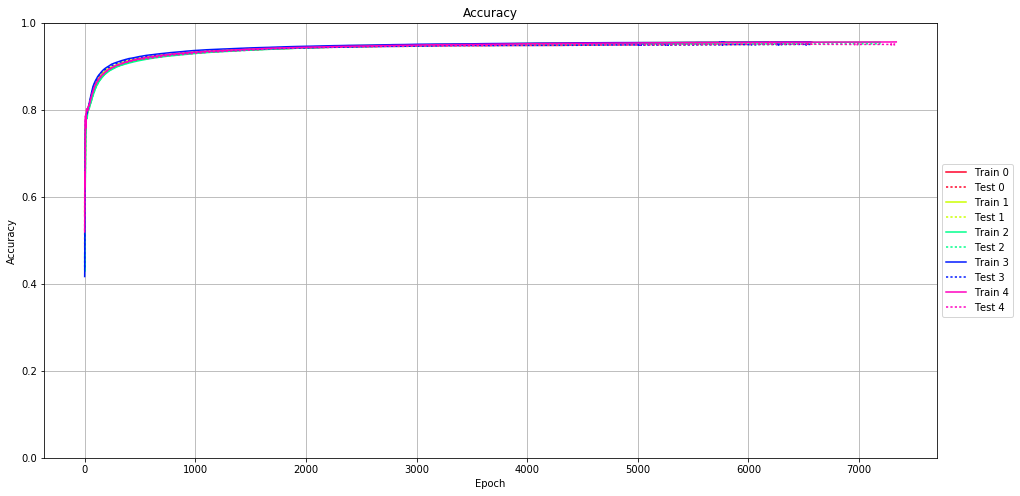

In [36]:
plot_acc(history)

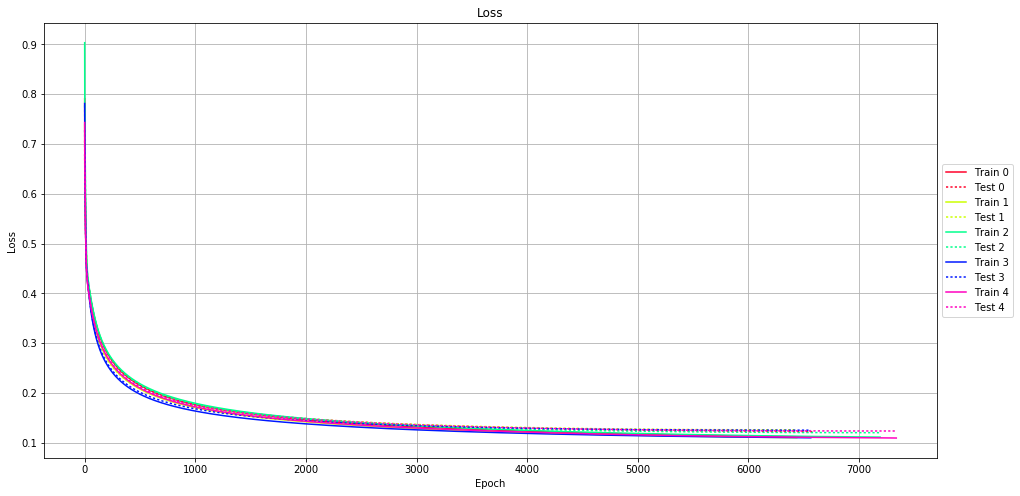

In [37]:
plot_loss(history)

Plotting the confusion matrix


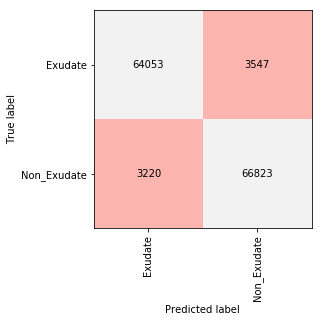

In [16]:
print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(5, 4)
plt.imshow(conf_mat,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(int(conf_mat[row][col])),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


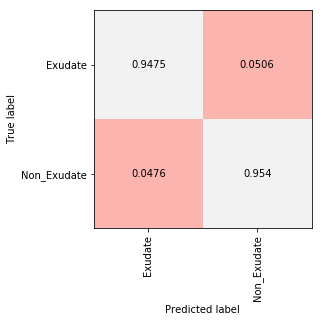

In [17]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/no_imgs  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=4)  # rounding to display in figure
figure = plt.gcf()
figure.set_size_inches(5, 4)
plt.imshow(conf_mat_norm,interpolation='nearest')
for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat_norm[row][col]),xy=(col,row),ha='center',va='center')
plt.xticks(range(len(list_fams)),list_fams,rotation=90,fontsize=10)
plt.yticks(range(len(list_fams)),list_fams,fontsize=10)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()